В цьому ноутбуці ми проведемо дослідницький аналіз даних про історичні платежі по кредитам клієнтами.

[Опис колонок в даних тут.](https://drive.google.com/file/d/1Yp2aOdC33QFAVfTyxav_gKGwi4M9VN1Z/view?usp=sharing)

Цільова змінна TARGET тут має наступне значення: 1 – клієнт із труднощами з оплатою: він/вона прострочив платіж понад X днів принаймні одного з перших Y платежів кредиту в нашій вибірці, 0 – усі інші випадки

Задача - виявити, яким клієнтам видавати кредит, а яким - не варто, бо вони з високою імовірністю його не повернуть.

Дані взяті з [Kaggle](https://www.kaggle.com/datasets/gauravduttakiit/loan-defaulter). Прошу використовувати саме ті, які надані в нашому курсі, аби нам бути впевненими, що ми точно працюємо з одними і тими ж даними.

# Імпорт необхідних бібліотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max.rows',130)
pd.set_option('display.max.columns',130)
pd.set_option('float_format','{:.2f}'.format)

pd.set_option() - задати опції до датасету  

# Імпорт даних

Вмонтуємо наш диск, якщо Ви працюєте в Google Colab. Якщо працюєте локально, пропустіть наступну клітинку.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Знайдемо, де лежать наші файли з даними. В мене вони знаходяться тут:

In [2]:
!ls application_data.csv 

application_data.csv


Якщо треба зчитати опис, то робимо це аналогічно.

In [3]:
df = pd.read_csv('application_data.csv')
descr = pd.read_csv("columns_description.csv")

In [4]:
descr[descr.Row == 'FLAG_OWN_CAR'].Description

#descr.head()

4    Flag if the client owns a car
Name: Description, dtype: object

In [5]:
descr.loc[1].Description

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

Зчитуємо дані.

In [6]:
# Огляд декількох записів з датафрейму
df.head(10)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   
5      100008       0         Cash loans           M            N   
6      100009       0         Cash loans           F            Y   
7      100010       0         Cash loans           M            Y   
8      100011       0         Cash loans           F            N   
9      100012       0    Revolving loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0         202500.00   406597.50     24700.50   
1               N             0         270000.00  1293502.50     35698.50   
2               Y             0          67500.00   135000.00      6750.00   
3               Y             0         135000.00   312682.50     29686.50   
4               Y             0         121500.00   513000.00     21865.50   
5               Y             0          99000.00   490495.50     27517.50   
6               Y             1         171000.00  1560726.00     41301.00   
7               Y             0         360000.00  1530000.00     42075.00   
8               Y             0         112500.00  1019610.00     33826.50   
9               Y             0         135000.00   405000.00     20250.00   

   AMT_GOODS_PRICE  NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0        351000.00    Unaccompanied               Working   
1       1129500.00           Family         State servant   
2        135000.00    Unaccompanied               Working   
3        297000.00    Unaccompanied               Working   
4        513000.00    Unaccompanied               Working   
5        454500.00  Spouse, partner         State servant   
6       1395000.00    Unaccompanied  Commercial associate   
7       1530000.00    Unaccompanied         State servant   
8        913500.00         Children             Pensioner   
9        405000.00    Unaccompanied               Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   
5  Secondary / secondary special               Married  House / apartment   
6               Higher education               Married  House / apartment   
7               Higher education               Married  House / apartment   
8  Secondary / secondary special               Married  House / apartment   
9  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02       -9461           -637           -3648.00   
1                        0.00      -16765          -1188           -1186.00   
2                        0.01      -19046           -225           -4260.00   
3                        0.01      -19005          -3039           -9833.00   
4                        0.03      -19932          -3038           -4311.00   
5                        0.04      -16941          -1588           -4970.00   
6                        0.04      -13778          -3130           -1213.00   
7                        0.00      -18850           -449           -4597.00   
8                        0.02      -20099         365243           -7427.00   
9                        0.02      -14469          -2019          -14437.0

# Перевірка структури даних

In [7]:
df.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

In [8]:
type(df)

pandas.core.frame.DataFrame

In [9]:
df.shape

(307511, 122)

Маємо ~307k рядків та 122 колонки.

## Статистичний звіт для числових змінних

In [10]:
df.describe()

SK_ID_CURR    TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
count   307511.00 307511.00     307511.00         307511.00   307511.00   
mean    278180.52      0.08          0.42         168797.92   599026.00   
std     102790.18      0.27          0.72         237123.15   402490.78   
min     100002.00      0.00          0.00          25650.00    45000.00   
25%     189145.50      0.00          0.00         112500.00   270000.00   
50%     278202.00      0.00          0.00         147150.00   513531.00   
75%     367142.50      0.00          1.00         202500.00   808650.00   
max     456255.00      1.00         19.00      117000000.00  4050000.00   

       AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
count    307499.00        307233.00                   307511.00   307511.00   
mean      27108.57        538396.21                        0.02   -16037.00   
std       14493.74        369446.46                        0.01     4363.99   
min        1615.50         40500.00                        0.00   -25229.00   
25%       16524.00        238500.00                        0.01   -19682.00   
50%       24903.00        450000.00                        0.02   -15750.00   
75%       34596.00        679500.00                        0.03   -12413.00   
max      258025.50       4050000.00                        0.07    -7489.00   

       DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
count      307511.00          307511.00        307511.00    104582.00   
mean        63815.05           -4986.12         -2994.20        12.06   
std        141275.77            3522.89          1509.45        11.94   
min        -17912.00          -24672.00         -7197.00         0.00   
25%         -2760.00           -7479.50         -4299.00         5.00   
50%         -1213.00           -4504.00         -3254.00         9.00   
75%          -289.00           -2010.00         -1720.00        15.00   
max        365243.00               0.00             0.00        91.00   

       FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
count   307511.00       307511.00        307511.00         307511.00   
mean         1.00            0.82             0.20              1.00   
std          0.00            0.38             0.40              0.04   
min          0.00            0.00             0.00              0.00   
25%          1.00            1.00             0.00              1.00   
50%          1.00            1.00             0.00              1.00   
75%          1.00            1.00             0.00              1.00   
max          1.00            1.00             1.00              1.00   

       FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count   307511.00   307511.00        307509.00             307511.00   
mean         0.28        0.06             2.15                  2.05   
std          0.45        0.23             0.91                  0.51   
min          0.00        0.00             1.00                  1.00   
25%          0.00        0.00             2.00                  2.00   
50%          0.00        0.00             2.00                  2.00   
75%          1.00        0.00             3.00                  2.00   
max          1.00        1.00            20.00                  3.00   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                    307511.00                307511.00   
mean                          2.03                    12.06   
std                           0.50                     3.27   
min                           1.00                     0.00   
25%                           2.00                    10.00   
50%                           2.00                    12.00   
75%                           2.00                    14.00   
max                           3.00                    23.00   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
count                   307511

# Аналіз категоріальних змінних

In [11]:
df.select_dtypes(include = "object").columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [12]:
df.select_dtypes(include='float').columns

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI'

In [13]:
df.select_dtypes(include='int').columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21'],
      dtype='object')

In [14]:
# Перевірка кількості категоріальних змінних
len(df.select_dtypes(include = "object").columns)

16

In [15]:
df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0         202500.00   406597.50     24700.50   
1               N             0         270000.00  1293502.50     35698.50   
2               Y             0          67500.00   135000.00      6750.00   
3               Y             0         135000.00   312682.50     29686.50   
4               Y             0         121500.00   513000.00     21865.50   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0        351000.00   Unaccompanied          Working   
1       1129500.00          Family    State servant   
2        135000.00   Unaccompanied          Working   
3        297000.00   Unaccompanied          Working   
4        513000.00   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                        0.02       -9461           -637           -3648.00   
1                        0.00      -16765          -1188           -1186.00   
2                        0.01      -19046           -225           -4260.00   
3                        0.01      -19005          -3039           -9833.00   
4                        0.03      -19932          -3038           -4311.00   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531        26.00           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers             1.00   
1                 1           1           0      Core staff             2.00   
2                 1           1           0        Laborers             1.00   
3                 1           0           0        Laborers             2.00   
4                 1           0           0      Core staff             1.00   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

Дані містять 16 `categorical` змінних

# Аналіз числових змінних

In [16]:
number_df = df.select_dtypes(include="number")

In [17]:
number_df.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=106)

In [18]:
# Перевірка кількості числових змінних
len(number_df.columns)

106

Дані міятять 106 `numerical` змінних

In [19]:
number_df.head()

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002       1             0         202500.00   406597.50   
1      100003       0             0         270000.00  1293502.50   
2      100004       0             0          67500.00   135000.00   
3      100006       0             0         135000.00   312682.50   
4      100007       0             0         121500.00   513000.00   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0     24700.50        351000.00                        0.02       -9461   
1     35698.50       1129500.00                        0.00      -16765   
2      6750.00        135000.00                        0.01      -19046   
3     29686.50        297000.00                        0.01      -19005   
4     21865.50        513000.00                        0.03      -19932   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0           -637           -3648.00            -2120          NaN           1   
1          -1188           -1186.00             -291          NaN           1   
2           -225           -4260.00            -2531        26.00           1   
3          -3039           -9833.00            -2437          NaN           1   
4          -3038           -4311.00            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0             1.00                     2                            2   
1             2.00                     1                            1   
2             1.00                     2                            2   
3             2.00                     2                            2   
4             1.00                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       1                        1   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0          0.08          0.26          0.14            0.02              0.04   
1          0.31          0.62           NaN            0.10              0.05   
2           NaN          0.56          0.73             NaN               NaN   
3           NaN          0.65           NaN             NaN               NaN   
4           NaN          0.32           NaN             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COM

# Робота з некоректними типами даних

Перевірка, чи немає у нас стовпця з неправильним типом даних

In [20]:
df.SK_ID_CURR.astype(str)
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [21]:
df.dtypes

SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64


Дивлячись на дані та відповідні їм типи даних, можна змінити тип стовпчика SKU.

In [22]:
df['SK_ID_CURR'] = df['SK_ID_CURR'].astype("str")

Також ми можемо змінити всі стовпці `flag` на тип даних, який є більш економний для зберігання.

Ось скільки пам'яті в Мб займають наші дані зараз.

In [23]:
df.memory_usage().sum()/1024/1024 #mb

286.22710037231445

In [24]:
'flag' in 'SK_ID_CURR'.lower()

False

In [25]:
flag_cols = ['flag' in col.lower() for col in df.columns]
flag_cols.count(True)

28

In [26]:
len(df.columns)

122

In [27]:
df[df.columns[flag_cols]].head()

FLAG_OWN_CAR FLAG_OWN_REALTY  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            N               Y           1               1                0   
1            N               N           1               1                0   
2            Y               Y           1               1                1   
3            N               Y           1               1                0   
4            N               Y           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
0                 1           1           0                0                1   
1                 1           1           0                0                1   
2                 1           1           0                0                0   
3                 1           0           0                0                1   
4                 1           0           0                0                0   

   FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  \
0                0                0                 0                 0   
1                0                0                 0                 0   
2                0                0                 0                 0   
3                0                0                 0                 0   
4                1                0                 0                 0   

   FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  FLAG_DOCUMENT_15  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  
0                 0                 0  
1                 0                 0  
2                 0                 0  
3                 0                 0  
4                 0                 0

In [28]:
df[df.columns[flag_cols]].dtypes #nunique()

FLAG_OWN_CAR        object
FLAG_OWN_REALTY     object
FLAG_MOBIL           int64
FLAG_EMP_PHONE       int64
FLAG_WORK_PHONE      int64
FLAG_CONT_MOBILE     int64
FLAG_PHONE           int64
FLAG_EMAIL           int64
FLAG_DOCUMENT_2      int64
FLAG_DOCUMENT_3      int64
FLAG_DOCUMENT_4      int64
FLAG_DOCUMENT_5      int64
FLAG_DOCUMENT_6      int64
FLAG_DOCUMENT_7      int64
FLAG_DOCUMENT_8      int64
FLAG_DOCUMENT_9      int64
FLAG_DOCUMENT_10     int64
FLAG_DOCUMENT_11     int64
FLAG_DOCUMENT_12     int64
FLAG_DOCUMENT_13     int64
FLAG_DOCUMENT_14     int64
FLAG_DOCUMENT_15     int64
FLAG_DOCUMENT_16     int64
FLAG_DOCUMENT_17     int64
FLAG_DOCUMENT_18     int64
FLAG_DOCUMENT_19     int64
FLAG_DOCUMENT_20     int64
FLAG_DOCUMENT_21     int64
dtype: object

Типи даних в pandas взяті з numpy, і ось тут список всіх типів даних в numpy:

https://numpy.org/doc/stable/user/basics.types.html

Кожен тип даних займає певну кількість байт у пам'яті. Давайте з'ясуємо, скільки займає 1 тип int8 та 1 тип int64 і скільки пам'яті ми заощадимо, якщо змінимо тип.

In [29]:
import numpy as np
from sys import getsizeof

In [30]:
getsizeof(np.int64(1))

32

In [31]:
getsizeof(np.int8(1))

25

In [32]:
7 * df.shape[0] * sum(flag_cols) / 1024 / 1024

57.48000717163086

Отже, ми можемо потенційно заощадити 57 Мб пам'яті! І трансформувати наш фрейм даних буде простіше. Давайте змінимо тип.


In [33]:
str_flag_cols = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

In [34]:
for col in str_flag_cols:
  df[col] = np.where(df[col]=='Y', 1, 0)

In [35]:
df[str_flag_cols].dtypes #nunique()

FLAG_OWN_CAR       int64
FLAG_OWN_REALTY    int64
dtype: object

In [36]:
df.columns[flag_cols]

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'],
      dtype='object')

In [37]:
df[df.columns[flag_cols]] = df[df.columns[flag_cols]].astype('int8')

In [38]:
df.memory_usage().sum()/1024/1024

228.7470932006836

# Робота з пропущеними значеннями

Найпростіше емпіричне правило для опрацювання пропущених значень: якщо пропущених значень більше за 40% - видаляємо колонку, якщо менше за 40% - аналізуємо, як можна заповнити і чи треба.
Зазвичай, якщо відсоток пропущених даних більший за 10 і немає чіткої (яка значно виділяється) моди (найчастішого) значення в даних, то лишаємо дані як є до використання методів машинного навчання. Далі якщо метод вимагає заповення пропущених значень, можемо експериментувати із заповеннями. Також хорошою практикою є створити окрему колонку-флаг (0/1), яка вказує, де були пропущені значення - це буде додаткова ознака для моделі.


Перевіримо, чи немає null-значень в нашому наборі даних

In [39]:
df.isnull().values.any()

True

Порахуємо загальну кількість null-значень в наборі даних

In [40]:
df.isnull().values.sum()

9152465

Сформуємо список із стовпців з null-значеннями

In [41]:
df.columns[df.isnull().any()]

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
       'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMI

In [42]:
len(df.columns[df.isnull().any()])

67

Усього `67` стовпців мають одне або більше NULL-значень в даних

## Кількість та відсоток пропущених значень у стовпцях

In [43]:
null_count = df.isnull().sum()
null_percentage = round((df.isnull().sum()/df.shape[0])*100, 2)
null_percentage

SK_ID_CURR                      0.00
TARGET                          0.00
NAME_CONTRACT_TYPE              0.00
CODE_GENDER                     0.00
FLAG_OWN_CAR                    0.00
FLAG_OWN_REALTY                 0.00
CNT_CHILDREN                    0.00
AMT_INCOME_TOTAL                0.00
AMT_CREDIT                      0.00
AMT_ANNUITY                     0.00
AMT_GOODS_PRICE                 0.09
NAME_TYPE_SUITE                 0.42
NAME_INCOME_TYPE                0.00
NAME_EDUCATION_TYPE             0.00
NAME_FAMILY_STATUS              0.00
NAME_HOUSING_TYPE               0.00
REGION_POPULATION_RELATIVE      0.00
DAYS_BIRTH                      0.00
DAYS_EMPLOYED                   0.00
DAYS_REGISTRATION               0.00
DAYS_ID_PUBLISH                 0.00
OWN_CAR_AGE                    65.99
FLAG_MOBIL                      0.00
FLAG_EMP_PHONE                  0.00
FLAG_WORK_PHONE                 0.00
FLAG_CONT_MOBILE                0.00
FLAG_PHONE                      0.00
F

In [44]:
df.shape[0]

307511

In [45]:
#створюємо датафрейм, який містить тільки нульові значення
null_df = pd.DataFrame({'column_name' : df.columns,'null_count' : null_count,'null_percentage': null_percentage})
null_df.reset_index(drop = True, inplace = True)

In [46]:
null_df.sort_values(by = 'null_percentage', ascending = False)

column_name  null_count  null_percentage
76                COMMONAREA_MEDI      214865            69.87
48                 COMMONAREA_AVG      214865            69.87
62                COMMONAREA_MODE      214865            69.87
70       NONLIVINGAPARTMENTS_MODE      213514            69.43
56        NONLIVINGAPARTMENTS_AVG      213514            69.43
84       NONLIVINGAPARTMENTS_MEDI      213514            69.43
86             FONDKAPREMONT_MODE      210295            68.39
68          LIVINGAPARTMENTS_MODE      210199            68.35
54           LIVINGAPARTMENTS_AVG      210199            68.35
82          LIVINGAPARTMENTS_MEDI      210199            68.35
52                  FLOORSMIN_AVG      208642            67.85
66                 FLOORSMIN_MODE      208642            67.85
80                 FLOORSMIN_MEDI      208642            67.85
75               YEARS_BUILD_MEDI      204488            66.50
61               YEARS_BUILD_MODE      204488            66.50
47                YEARS_BUILD_AVG      204488            66.50
21                    OWN_CAR_AGE      202929            65.99
81                  LANDAREA_MEDI      182590            59.38
67                  LANDAREA_MODE      182590            59.38
53                   LANDAREA_AVG      182590            59.38
73              BASEMENTAREA_MEDI      179943            58.52
45               BASEMENTAREA_AVG      179943            58.52
59              BASEMENTAREA_MODE      179943            58.52
41                   EXT_SOURCE_1      173378            56.38
71             NONLIVINGAREA_MODE      169682            55.18
57              NONLIVINGAREA_AVG      169682            55.18
85             NONLIVINGAREA_MEDI      169682            55.18
77                 ELEVATORS_MEDI      163891            53.30
49                  ELEVATORS_AVG      163891            53.30
63                 ELEVATORS_MODE      163891            53.30
89             WALLSMATERIAL_MODE      156341            50.84
72                APARTMENTS_MEDI      156061            50.75
44                 APARTMENTS_AVG      156061            50.75
58                APARTMENTS_MODE      156061            50.75
78                 ENTRANCES_MEDI      154828            50.35
50                  ENTRANCES_AVG      154828            50.35
64                 ENTRANCES_MODE      154828            50.35
55                 LIVINGAREA_AVG      154350            50.19
69                LIVINGAREA_MODE      154350            50.19
83                LIVINGAREA_MEDI      154350            50.19
87                 HOUSETYPE_MODE      154297            50.18
65                 FLOORSMAX_MODE      153020            49.76
79                 FLOORSMAX_MEDI      153020            49.76
51                  FLOORSMAX_AVG      153020            49.76
60   YEARS_BEGINEXPLUATATION_MODE      150007            48.78
74   YEARS_BEGINEXPLUATATION_MEDI      150007            48.78
46    YEARS_BEGINEXPLUATATION_AVG      150007            48.78
88                 TOTALAREA_MODE      148431            48.27
90            EMERGENCYSTATE_MODE      145755            47.40
28                OCCUPATION_TYPE       96391            31.35
43                   EXT_SOURCE_3       60965            19.83
116    AMT_REQ_CREDIT_BUREAU_HOUR       41519            13.50
117     AMT_REQ_CREDIT_BUREAU_DAY       41519            13.50
118    AMT_REQ_CREDIT_BUREAU_WEEK       41519            13.50
119     AMT_REQ_CREDIT_BUREAU_MON       41519            13.50
120     AMT_REQ_CREDIT_BUREAU_QRT       41519            13.50
121    AMT_REQ_CREDIT_BUREAU_YEAR       41519            13.50
11                NAME_TYPE_SUITE        1292             0.42
92       DEF_30_CNT_SOCIAL_CIRCLE        1021             0.33
91       OBS_30_CNT_SOCIAL_CIRCLE        1021             0.33
93       OBS_60_CNT_SOCIAL_CIRCLE        1021             0.33
94       DEF_60_CNT_SOCIAL_CIRCLE        1021             0.33
42                   EXT_SOURCE_2         660        

## Видалення стовпців з NULL значеннями > 40%

Сформуємо список стовпців з NULL значеннями > 40% у список. Ми видалимо ці стовпці з датафрейму, оскільки в них занадто багато пропущених значень.

In [47]:
columns_to_be_deleted = null_df[null_df['null_percentage'] > 40].column_name.to_list()
columns_to_be_deleted

['OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MOD

In [48]:
len(columns_to_be_deleted)

49

Всього потрібно видалити `49` стовпців. Видалення їх з основного датафрейму **`df`**

In [49]:
df.drop(columns = columns_to_be_deleted, inplace = True)

Перевірка підрахунку стовпців після видалення. Мало б залишитись лише `73` стовпці

In [50]:
df.shape

(307511, 73)

## Перевірка стовпців з NULL значеннями < 40%

Створення датафрейму `null_df_under40` зі стовпцями, де відсоток пропущених значеннь менше 40%

In [51]:
null_df_under40 = null_df[null_df['null_percentage'] < 40]

In [52]:
null_df_under40.sort_values(by = 'null_percentage', ascending = False)

column_name  null_count  null_percentage
28               OCCUPATION_TYPE       96391            31.35
43                  EXT_SOURCE_3       60965            19.83
121   AMT_REQ_CREDIT_BUREAU_YEAR       41519            13.50
120    AMT_REQ_CREDIT_BUREAU_QRT       41519            13.50
119    AMT_REQ_CREDIT_BUREAU_MON       41519            13.50
118   AMT_REQ_CREDIT_BUREAU_WEEK       41519            13.50
117    AMT_REQ_CREDIT_BUREAU_DAY       41519            13.50
116   AMT_REQ_CREDIT_BUREAU_HOUR       41519            13.50
11               NAME_TYPE_SUITE        1292             0.42
91      OBS_30_CNT_SOCIAL_CIRCLE        1021             0.33
92      DEF_30_CNT_SOCIAL_CIRCLE        1021             0.33
93      OBS_60_CNT_SOCIAL_CIRCLE        1021             0.33
94      DEF_60_CNT_SOCIAL_CIRCLE        1021             0.33
42                  EXT_SOURCE_2         660             0.21
10               AMT_GOODS_PRICE         278             0.09
101              FLAG_DOCUMENT_7           0             0.00
95        DAYS_LAST_PHONE_CHANGE           1             0.00
96               FLAG_DOCUMENT_2           0             0.00
97               FLAG_DOCUMENT_3           0             0.00
98               FLAG_DOCUMENT_4           0             0.00
99               FLAG_DOCUMENT_5           0             0.00
100              FLAG_DOCUMENT_6           0             0.00
105             FLAG_DOCUMENT_11           0             0.00
102              FLAG_DOCUMENT_8           0             0.00
103              FLAG_DOCUMENT_9           0             0.00
104             FLAG_DOCUMENT_10           0             0.00
39       LIVE_CITY_NOT_WORK_CITY           0             0.00
106             FLAG_DOCUMENT_12           0             0.00
107             FLAG_DOCUMENT_13           0             0.00
108             FLAG_DOCUMENT_14           0             0.00
109             FLAG_DOCUMENT_15           0             0.00
110             FLAG_DOCUMENT_16           0             0.00
111             FLAG_DOCUMENT_17           0             0.00
112             FLAG_DOCUMENT_18           0             0.00
113             FLAG_DOCUMENT_19           0             0.00
114             FLAG_DOCUMENT_20           0             0.00
115             FLAG_DOCUMENT_21           0             0.00
40             ORGANIZATION_TYPE           0             0.00
0                     SK_ID_CURR           0             0.00
38        REG_CITY_NOT_WORK_CITY           0             0.00
9                    AMT_ANNUITY          12             0.00
17                    DAYS_BIRTH           0             0.00
16    REGION_POPULATION_RELATIVE           0             0.00
15             NAME_HOUSING_TYPE           0             0.00
14            NAME_FAMILY_STATUS           0             0.00
13           NAME_EDUCATION_TYPE           0             0.00
12              NAME_INCOME_TYPE           0             0.00
8                     AMT_CREDIT           0             0.00
1                         TARGET           0             0.00
7               AMT_INCOME_TOTAL           0             0.00
6                   CNT_CHILDREN           0             0.00
5                FLAG_OWN_REALTY           0             0.00
4                   FLAG_OWN_CAR           0             0.00
3                    CODE_GENDER           0             0.00
2             NAME_CONTRACT_TYPE           0             0.00
18                 DAYS_EMPLOYED           0             0.00
19             DAYS_REGISTRATION           0             0.00
20               DAYS_ID_PUBLISH           0             0.00
22                    FLAG_MOBIL           0             0.00
23                FLAG_EMP_PHONE           0             0.00
24               FLAG_WORK_PHONE           0             0.00
25              FLAG_CONT_MOBILE           0             0.00
26                    FLAG_PHONE           0             0.00
27                    FLAG_EMAIL           0         

In [53]:
descr[descr.Row == 'OCCUPATION_TYPE']

Table              Row  \
28  application_data  OCCUPATION_TYPE   

                                     Description Special  
28  What kind of occupation does the client have     NaN

Опрацюємо кожну з колонок.

### Аналіз стовпця `OCCUPATION_TYPE`

- нульові значення = 31.35%

In [54]:
df['OCCUPATION_TYPE'].value_counts()

OCCUPATION_TYPE
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64

Заміна NULL-значень на категорією `Unknown`

In [55]:
df['OCCUPATION_TYPE'].fillna(value = 'Unknown', inplace = True)

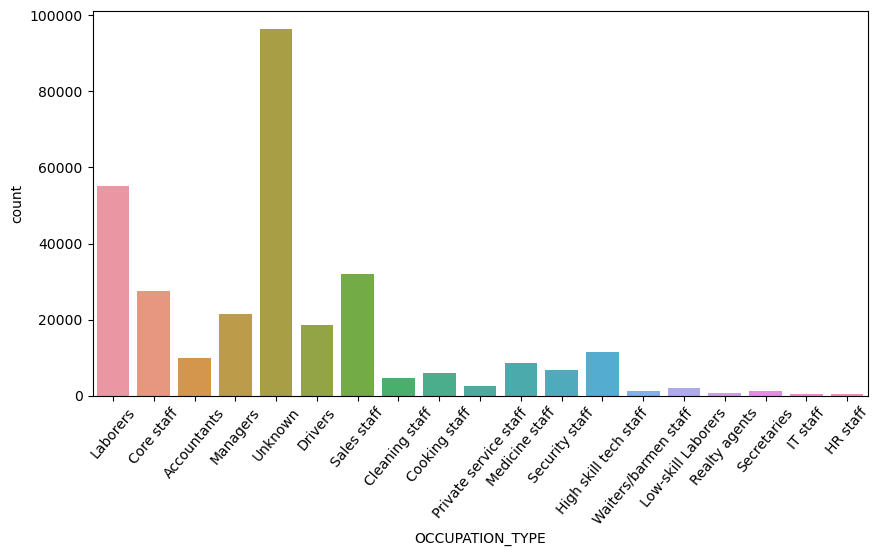

In [56]:
plt.figure(figsize = (10,5))
sns.countplot(data = df, x = "OCCUPATION_TYPE")
plt.xticks(rotation = 50)
plt.show()

**Спостереження**
- Якщо поглянути на графік, то найбільшу кількість заявників на кредит мають `Laborers`
- Для імпутації краще залишити дані як є (пропущені значення становлять 31,35%) і не проводити імпутацію за якоюсь константою, як-от мода або мін/макс медіана, якщо це числовий стовпчик, оскільки це може викривити дані в подальших розрахунках.

Існує також можливість імпутації за допомогою більш "розумних" методів, але ми вивчимо їх пізніше, а зараз ми робимо те, що можемо, за допомогою деяких найпростіших перетворень.

### Аналіз стовпця `EXT_SOURCE_3`

- пропущені значення = 19.83%

In [57]:
df.EXT_SOURCE_3.value_counts()#.head()

EXT_SOURCE_3
0.75    1460
0.71    1315
0.69    1276
0.67    1191
0.65    1154
        ... 
0.02       1
0.02       1
0.02       1
0.01       1
0.04       1
Name: count, Length: 814, dtype: int64

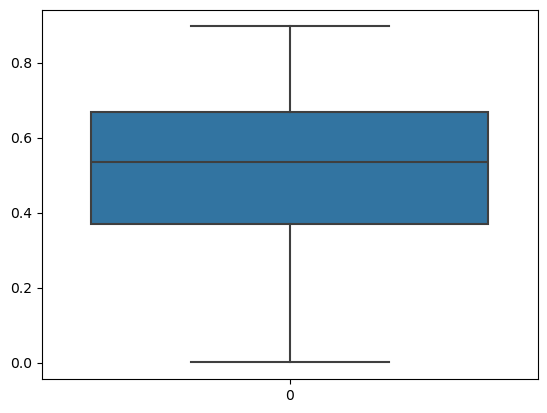

In [58]:
sns.boxplot(df.EXT_SOURCE_3)
plt.show()

Отримання процентильних значень для `EXT_SOURCE_3`

In [59]:
df.EXT_SOURCE_3.quantile(q = [0.25,0.5,0.75,1])

0.25   0.37
0.50   0.54
0.75   0.67
1.00   0.90
Name: EXT_SOURCE_3, dtype: float64

Найбільш повторюване значення в `EXT_SOURCE_3

In [61]:
df.EXT_SOURCE_3.mode()[0]

0.746300213050371

Перевірка середнього значення `EXT_SOURCE_3`

In [62]:
df.EXT_SOURCE_3.mean()

0.5108529061799658

**Спостереження**
-  Дивлячись на діагараму розмаху, медіана становить 0,535276
-  Найчастіше повторюване значення - 0,74630
-  Середнє значення - 0,51085
-  Хоча середнє та медіана є ближчими і можуть бути використані для імплікації, оскільки відсутнє відсоткове значення є більшим (19,83%), краще залишити дані як є і не проводити імплікації. Якщо метод вимагає імплікації, ми можемо імплікувати дані за допомогою медіани і створити ще один стовпчик, в якому буде позначено, які значення були імпліковані.

# ДЗ 1. Аналіз стовпців `AMT_REQ_CREDIT_BUREAU` з пропущеними значеннями

Виведіть середнє, моду, медіану та відсоток відсутніх даних для настуних колонок:

-  `AMT_REQ_CREDIT_BUREAU_YEAR`
-	`AMT_REQ_CREDIT_BUREAU_QRT`
-	`AMT_REQ_CREDIT_BUREAU_MON`
-	`AMT_REQ_CREDIT_BUREAU_WEEK`
-	`AMT_REQ_CREDIT_BUREAU_DAY`
-	`AMT_REQ_CREDIT_BUREAU_HOUR`

На основі виведених даних напишіть висновок про те, чи варто заповнювати пусті значення і якщо так, то яким чином?

Відсоток пропущених значень цих колонок - 13.50%. Що є не малою частиною і може впливати на подальший розрахунок, тому додатково проаналізуємо чи є чіткі значення в даних і ми зможемо їх замінити, видалити чи краще лишити без змін.

In [63]:
#якщо б це було в продовденні аналізу скоріш за все використовувала б фільтр для визначення цих колонок до прикладу наступний 
filter_1 = (null_df['null_percentage'] < 15) & (null_df['null_percentage'] > 10)
null_df_above_10 = null_df[filter_1].column_name.to_list()
null_df_above_10

['AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

подивимось опис колонки, та як вони виглядають, щоб більше зрозуміти важливість даних для розрахунків 

In [64]:
descr[descr.Row == 'AMT_REQ_CREDIT_BUREAU_WEEK'].Description

118    Number of enquiries to Credit Bureau about the...
Name: Description, dtype: object

це однотипні дані в різний часовий період, тому думаю їх можна аналізувати одночасно 

In [65]:
df[null_df_above_10].head()

AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.00                       0.00   
1                        0.00                       0.00   
2                        0.00                       0.00   
3                         NaN                        NaN   
4                        0.00                       0.00   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                        0.00                       0.00   
1                        0.00                       0.00   
2                        0.00                       0.00   
3                         NaN                        NaN   
4                        0.00                       0.00   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                       0.00                        1.00  
1                       0.00                        0.00  
2                       0.00                        0.00  
3                        NaN                         NaN  
4                       0.00                        0.00

вже бачу значення нулів і таким може бути весь масив, тому для перегляду загальної картини можемо подивитись квартиль

In [66]:
df[null_df_above_10].quantile(q = [0.25,0.5,0.75,1])

AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0.25                        0.00                       0.00   
0.50                        0.00                       0.00   
0.75                        0.00                       0.00   
1.00                        4.00                       9.00   

      AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0.25                        0.00                       0.00   
0.50                        0.00                       0.00   
0.75                        0.00                       0.00   
1.00                        8.00                      27.00   

      AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0.25                       0.00                        0.00  
0.50                       0.00                        1.00  
0.75                       0.00                        3.00  
1.00                     261.00                       25.00

з даного розподілу бачу, що в нас можна сказати більше 90% даних по колонках це 0, і так як це дані, які відповідаєють кількість звернень до Бюро кредитних історій за тиждень/місяць/квартал/рік, пусті значення також можна було б замінитиина саме на 0, а не середнє, але подивимось ще і інші розрахунки

In [67]:
df[null_df_above_10].mean()

AMT_REQ_CREDIT_BUREAU_HOUR   0.01
AMT_REQ_CREDIT_BUREAU_DAY    0.01
AMT_REQ_CREDIT_BUREAU_WEEK   0.03
AMT_REQ_CREDIT_BUREAU_MON    0.27
AMT_REQ_CREDIT_BUREAU_QRT    0.27
AMT_REQ_CREDIT_BUREAU_YEAR   1.90
dtype: float64

In [68]:
df[null_df_above_10].mode()

AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.00                       0.00   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                        0.00                       0.00   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                       0.00                        0.00

In [69]:
df.AMT_REQ_CREDIT_BUREAU_HOUR.value_counts()

AMT_REQ_CREDIT_BUREAU_HOUR
0.00    264366
1.00      1560
2.00        56
3.00         9
4.00         1
Name: count, dtype: int64

In [70]:
df.AMT_REQ_CREDIT_BUREAU_DAY.value_counts()

AMT_REQ_CREDIT_BUREAU_DAY
0.00    264503
1.00      1292
2.00       106
3.00        45
4.00        26
5.00         9
6.00         8
9.00         2
8.00         1
Name: count, dtype: int64

In [71]:
df.AMT_REQ_CREDIT_BUREAU_WEEK.value_counts()

AMT_REQ_CREDIT_BUREAU_WEEK
0.00    257456
1.00      8208
2.00       199
3.00        58
4.00        34
6.00        20
5.00        10
8.00         5
7.00         2
Name: count, dtype: int64

In [72]:
df.AMT_REQ_CREDIT_BUREAU_MON.value_counts()

AMT_REQ_CREDIT_BUREAU_MON
0.00     222233
1.00      33147
2.00       5386
3.00       1991
4.00       1076
5.00        602
6.00        343
7.00        298
9.00        206
8.00        185
10.00       132
11.00       119
12.00        77
13.00        72
14.00        40
15.00        35
16.00        23
17.00        14
18.00         6
19.00         3
24.00         1
23.00         1
27.00         1
22.00         1
Name: count, dtype: int64

In [73]:
df.AMT_REQ_CREDIT_BUREAU_QRT.value_counts()

AMT_REQ_CREDIT_BUREAU_QRT
0.00      215417
1.00       33862
2.00       14412
3.00        1717
4.00         476
5.00          64
6.00          28
8.00           7
7.00           7
261.00         1
19.00          1
Name: count, dtype: int64

In [74]:
df.AMT_REQ_CREDIT_BUREAU_YEAR.value_counts()

AMT_REQ_CREDIT_BUREAU_YEAR
0.00     71801
1.00     63405
2.00     50192
3.00     33628
4.00     20714
5.00     12052
6.00      6967
7.00      3869
8.00      2127
9.00      1096
11.00       31
12.00       30
10.00       22
13.00       19
14.00       10
17.00        7
15.00        6
19.00        4
18.00        4
16.00        3
25.00        1
23.00        1
22.00        1
21.00        1
20.00        1
Name: count, dtype: int64

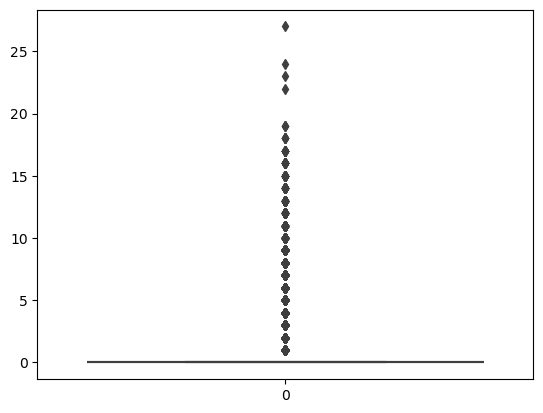

In [75]:
sns.boxplot(df.AMT_REQ_CREDIT_BUREAU_MON)
plt.show()

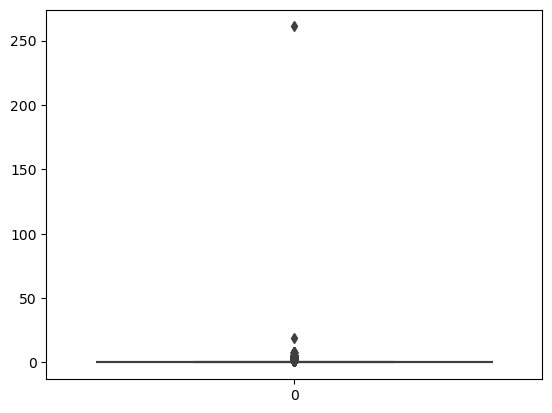

In [76]:
sns.boxplot(df.AMT_REQ_CREDIT_BUREAU_QRT)
plt.show()

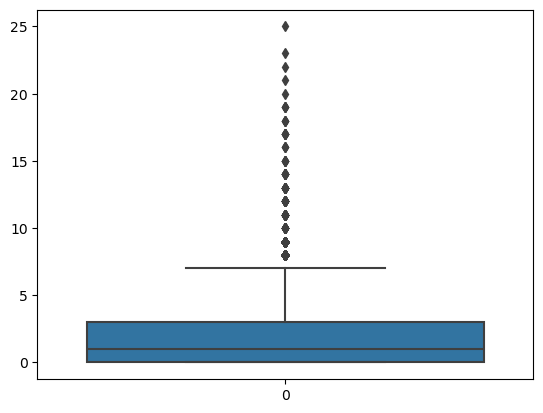

In [77]:
sns.boxplot(df.AMT_REQ_CREDIT_BUREAU_YEAR)
plt.show()

**Спостередження**
-  Найчастіше повторюване значення = 0
-  Середнє значення для періоду годин/днів/тижнів - близьке до 0, місяця і квартала = 0.27, а року =1.9 
-  А по кількості унікальних значень і діаграмі розмаху, бачимо, що значення, які є - вони великої відмінності від середньго

**Висновок**
-  Тож хоч в даному випадку ми маємо 13.50% пропущених значень, що могло б вплинути на прозрахунки, але ми можемо їх замінити на найчастіше значення = 0, 
так як по суті цих колонок буде не правильно виводити середнє чи приблизно видумане значення, оскільки клієнт міг зрертатись і тоді важливо точне значення , 
або не звертатись і тоді це = 0 

Тож нижче проведемо дану імплементацію 

In [91]:
df[null_df_above_10].fillna(0)

AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                             0.00                       0.00   
1                             0.00                       0.00   
2                             0.00                       0.00   
3                             0.00                       0.00   
4                             0.00                       0.00   
...                            ...                        ...   
307506                        0.00                       0.00   
307507                        0.00                       0.00   
307508                        1.00                       0.00   
307509                        0.00                       0.00   
307510                        0.00                       0.00   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                             0.00                       0.00   
1                             0.00                       0.00   
2                             0.00                       0.00   
3                             0.00                       0.00   
4                             0.00                       0.00   
...                            ...                        ...   
307506                        0.00                       0.00   
307507                        0.00                       0.00   
307508                        0.00                       1.00   
307509                        0.00                       0.00   
307510                        0.00                       2.00   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                            0.00                        1.00  
1                            0.00                        0.00  
2                            0.00                        0.00  
3                            0.00                        0.00  
4                            0.00                        0.00  
...                           ...                         ...  
307506                       0.00                        0.00  
307507                       0.00                        0.00  
307508                       0.00                        1.00  
307509                       0.00                        0.00  
307510                       0.00                        1.00  

[307511 rows x 6 columns]

## Перевірка стовпців зі значеннями NULL > 0% та < 1%

Створення датафрейму `null_df_under1` з відсотком пропущених значень > 0% та < 1% у кожному стовпці

In [79]:
null_df_under1 = null_df[(null_df['null_percentage'] > 0) & (null_df['null_percentage'] < 1)]

In [80]:
null_df_under1.sort_values(by = 'null_percentage', ascending = False)

column_name  null_count  null_percentage
11           NAME_TYPE_SUITE        1292             0.42
91  OBS_30_CNT_SOCIAL_CIRCLE        1021             0.33
92  DEF_30_CNT_SOCIAL_CIRCLE        1021             0.33
93  OBS_60_CNT_SOCIAL_CIRCLE        1021             0.33
94  DEF_60_CNT_SOCIAL_CIRCLE        1021             0.33
42              EXT_SOURCE_2         660             0.21
10           AMT_GOODS_PRICE         278             0.09

### Аналіз стовпця `NAME_TYPE_SUITE`

In [81]:
null_df_under1[null_df_under1.column_name == 'NAME_TYPE_SUITE']

column_name  null_count  null_percentage
11  NAME_TYPE_SUITE        1292             0.42

In [82]:
df['NAME_TYPE_SUITE'].value_counts()

NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64

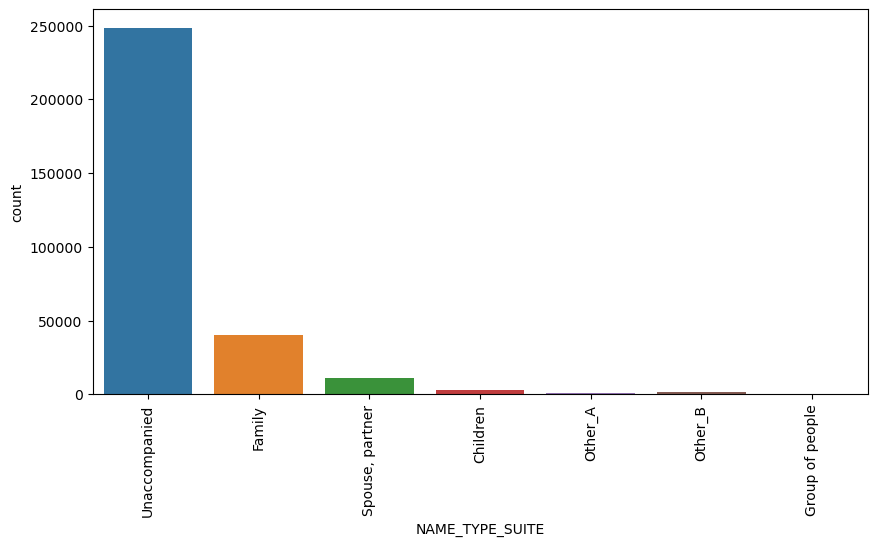

In [83]:
plt.figure(figsize = (10,5))
sns.countplot(data = df, x = "NAME_TYPE_SUITE")
plt.xticks(rotation = 90)
plt.show()

**Спостереження**
-   Дивлячись на графік, категорія `Unaccompanied` має найбільшу кількість заявників на отримання кредиту. Отже, більшість позичальників наважуються звертатися за кредитом без супроводу.
- Ми можемо продовжити і вказати `Unaccompanied` у датафреймі, але я б віддала перевагу другому варіанту.
- Ми також могли заповнити дані зі значенням "NA", оскільки цей стовпець є категоріальним.
- Так само, якщо в стовпці відсутні менше 1% даних, ми можемо видалити відсутні значення. Але якщо ми видалимо всі дані в усіх стовпцях, які мають <=1% відсутніх даних, ми можемо видалити забагато даних. Тому я переважно зберігаю дані, наскільки можу.

In [88]:
df['NAME_TYPE_SUITE'].fillna('NA', inplace=True)

In [89]:
df.NAME_TYPE_SUITE.value_counts().head(10)

NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
NA                   1292
Other_A               866
Group of people       271
Name: count, dtype: int64

### Analysis of `OBS_30_CNT_SOCIAL_CIRCLE` column

In [92]:
null_df_under1[null_df_under1.column_name == 'OBS_30_CNT_SOCIAL_CIRCLE']

column_name  null_count  null_percentage
91  OBS_30_CNT_SOCIAL_CIRCLE        1021             0.33

In [93]:
df.OBS_30_CNT_SOCIAL_CIRCLE.value_counts().head(10)

OBS_30_CNT_SOCIAL_CIRCLE
0.00    163910
1.00     48783
2.00     29808
3.00     20322
4.00     14143
5.00      9553
6.00      6453
7.00      4390
8.00      2967
9.00      2003
Name: count, dtype: int64

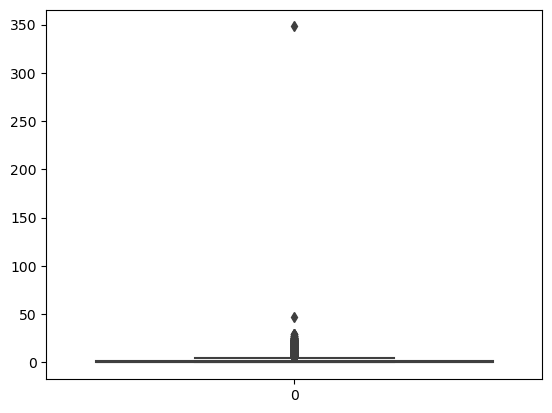

In [94]:
sns.boxplot(df.OBS_30_CNT_SOCIAL_CIRCLE)
plt.show()

Getting percentile values for `OBS_30_CNT_SOCIAL_CIRCLE`

In [95]:
df.OBS_30_CNT_SOCIAL_CIRCLE.quantile(q = [0.25,0.5,0.75,1])

0.25     0.00
0.50     0.00
0.75     2.00
1.00   348.00
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

Most recurring value in `OBS_30_CNT_SOCIAL_CIRCLE`

In [97]:
df.OBS_30_CNT_SOCIAL_CIRCLE.mode()[0]

0.0

Checking the average value of `OBS_30_CNT_SOCIAL_CIRCLE`

In [98]:
df.OBS_30_CNT_SOCIAL_CIRCLE.mean()

1.4222454239942575

**Спостереження**
- Дивлячись на боксплот, медіана становить 0,0
- Найчастіше повторюване значення становить 0,0
- Середнє значення 1,4222
- Є два виброси: 50 і 350.
- Середнє значення та мода близькі (відносно рангу даних у цьому стовпці) і можуть бути використані для імпутації. Це не призведе до зміщення, оскільки відсоток відсутнього значення невеликий (0,33%)

In [99]:
df['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(df['OBS_30_CNT_SOCIAL_CIRCLE'].median(), inplace=True)

# ДЗ 2. Аналіз і заповнення пустих значень у колонках з малим відсотком пропущених

За прикладом вище проведіть аналіз пропущених значень в колонках
- DEF_30_CNT_SOCIAL_CIRCLE
- EXT_SOURCE_2
- OBS_60_CNT_SOCIAL_CIRCLE
- DEF_60_CNT_SOCIAL_CIRCLE
- AMT_GOODS_PRICE

Для швидшого аналізу рекомендую написати фукнцію, яку Ви зможете викликати для кожної з колонок.

Зробіть висновок, що робити з пропущеними значеннями в кожному випадку і виконанайте ту дію, яку зазначили.

In [100]:
#cтворю список для аналізу даних
columns_null_df_under1 = [
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'AMT_GOODS_PRICE',
    'EXT_SOURCE_2'
    ]
display(columns_null_df_under1)

['DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_GOODS_PRICE',
 'EXT_SOURCE_2']

In [101]:
#напишемо функцію для аналізу пропущених значень
def null_value_analysis(df, column_name):
    column_descr = descr[descr.Row == column_name].Description
    null_perc = round((df[column_name].isnull().sum()/df.shape[0])*100, 2)
    column_data = df[column_name].dropna()
    mean = column_data.mean() 
    mode = column_data.mode()[0] 
    
    quantile = column_data.quantile(q = [0.25,0.5,0.75,1])
    value_counts = column_data.value_counts()

    sns.boxplot(column_data)
    plt.title(f'Box Plot for {column_name}')
    plt.show()
    
    analysis = {
        'Description': column_descr,
        'Null_perc': null_perc,
        'Mean': mean,
        'Mode': mode,
        'Quantile': quantile,
        'Value_counts': value_counts.head(15)
    }

    return analysis 
    

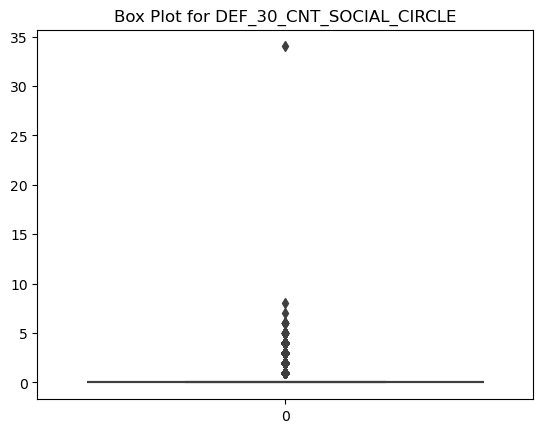

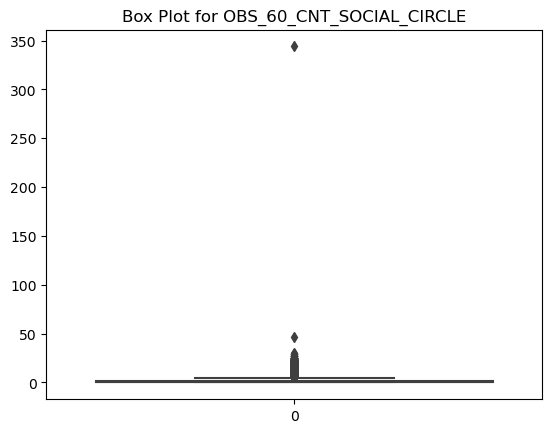

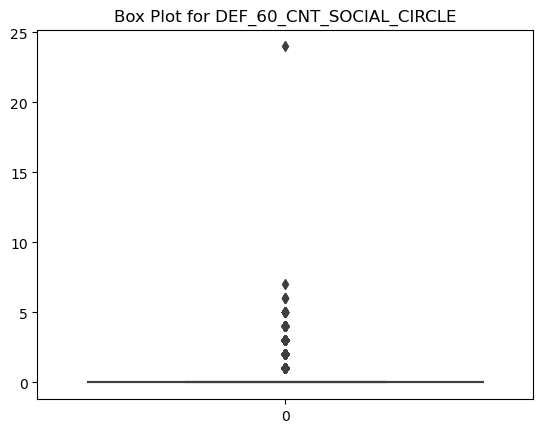

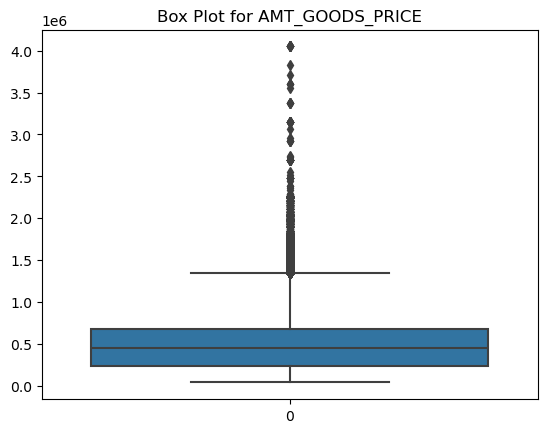

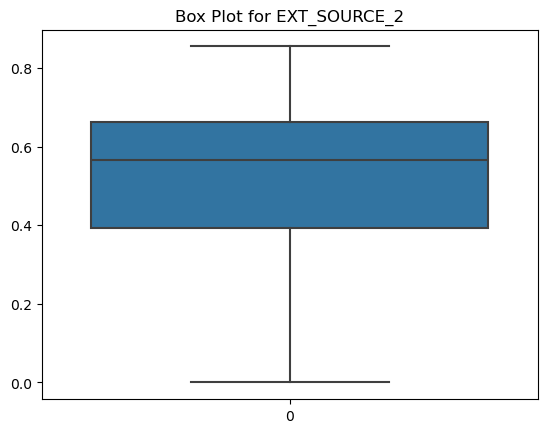

Analysis for column 'DEF_30_CNT_SOCIAL_CIRCLE':
  Description: 92    How many observation of client's social surrou...
Name: Description, dtype: object
  Null_perc: 0.33
  Mean: 0.1434206662533851
  Mode: 0.0
  Quantile: 0.25    0.00
0.50    0.00
0.75    0.00
1.00   34.00
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64
  Value_counts: DEF_30_CNT_SOCIAL_CIRCLE
0.00     271324
1.00      28328
2.00       5323
3.00       1192
4.00        253
5.00         56
6.00         11
7.00          1
34.00         1
8.00          1
Name: count, dtype: int64

Analysis for column 'OBS_60_CNT_SOCIAL_CIRCLE':
  Description: 93    How many observation of client's social surrou...
Name: Description, dtype: object
  Null_perc: 0.33
  Mean: 1.4052921791901856
  Mode: 0.0
  Quantile: 0.25     0.00
0.50     0.00
0.75     2.00
1.00   344.00
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64
  Value_counts: OBS_60_CNT_SOCIAL_CIRCLE
0.00     164666
1.00      48870
2.00      29766
3.00      20215
4.00      13946
5.00   

In [102]:
results = {col: null_value_analysis(df, col) for col in df[columns_null_df_under1]}

for col, analysis in results.items():
    print(f"Analysis for column '{col}':")
    for key, value in analysis.items():
        print(f"  {key}: {value}")
    print()



Для колонки: DEF_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE мають схожі результати :

**Спостереження**
- Дивлячись на боксплот, медіана становить 0,0
- Найчастіше повторюване значення становить 0,0
- Середнє значення між 0.1 і 1.4
- Є по декілька вибросів

**Висновки**
Отже використаємо медіану для заповнення, це не призведе до зміщення, оскільки відсоток відсутнього значення невеликий (0,33%) і мода та середнє близькі по значенню

In [103]:
column_to_fill = ['DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']

for col in column_to_fill:
    df[col].fillna(df[col].median(), inplace=True)

Для колонки AMT_GOODS_PRICE

**Спостереження**
- Маємо великий розмах даних дивлячись на боксплот, і медіана становить 450000.00
- Що сходиться з найчастіше повторюваним значенням 450000.00
- Середнє значення: 538396.21

**Висновок**
- Відсоток пустих значень мінімальний 0.09%, і можна було б видалити ці строки, але для максимольного збереження інших даних заповнимо їх також медіаною 

In [105]:
df['AMT_GOODS_PRICE'].fillna(df['AMT_GOODS_PRICE'].median(), inplace=True)

Для колонки EXT_SOURCE_2

**Спостереження**
- На блокплоті бачимо, що дані більш менш сконцентровані в невеликому діапазоні , і медіана становить 0.57
- Найчастіше повторюваним значення 0.28
- Середнє значення: 0.51

**Висновок**
- Відсоток пустих значень - 0.21%, можна замінити ці значеня середнім, так як вони близькі з медіаною, але середнім, так як воно ближче до найбільш повторюваного 

In [104]:
df['EXT_SOURCE_2'].fillna(df['EXT_SOURCE_2'].mean(), inplace=True)

# Робота з неправильними/невідомими значеннями даних

### Аналіз стовпця `CODE_GENDER`

Перевірка діапазону значень

In [106]:
df['CODE_GENDER'].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

Стать має бути тільки чоловіча або жіноча. Значення `XNA` може вказувати на те, що значення не було надано заявником або пропущено кредитним спеціалістом, який перевіряє заявку

In [107]:
df[df['CODE_GENDER'] == 'XNA']

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
35657      141289       0    Revolving loans         XNA             1   
38566      144669       0    Revolving loans         XNA             0   
83382      196708       0    Revolving loans         XNA             0   
189640     319880       0    Revolving loans         XNA             1   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
35657                 1             0         207000.00   382500.00   
38566                 1             2         157500.00   270000.00   
83382                 1             1         135000.00   405000.00   
189640                1             0         247500.00   540000.00   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
35657      19125.00        337500.00   Unaccompanied               Working   
38566      13500.00        225000.00          Family               Working   
83382      20250.00        225000.00   Unaccompanied               Working   
189640     27000.00        900000.00   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  \
35657   Secondary / secondary special            Married  Municipal apartment   
38566   Secondary / secondary special            Married    House / apartment   
83382                Higher education            Married    House / apartment   
189640              Incomplete higher     Civil marriage    House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
35657                         0.02      -20232         -10044   
38566                         0.03      -13717          -2797   
83382                         0.04      -10647          -1228   
189640                        0.04       -9649          -2293   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
35657           -10024.00            -3537           1               1   
38566            -2241.00            -4659           1               1   
83382             -183.00            -1671           1               1   
189640           -4099.00            -2326           1               1   

        FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
35657                 1                 1           1           0   
38566                 1                 1           1           0   
83382                 1                 1           1           0   
189640                1                 1           1           0   

           OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
35657              Unknown             2.00                     3   
38566   Low-skill Laborers             4.00                     2   
83382           Core staff             3.00                     2   
189640             Unknown             2.00                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
35657                             3                    TUESDAY   
38566                             2                     FRIDAY   
83382                             2                   THURSDAY   
189640                            2                     FRIDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
35657                        10                           0   
38566                        16                           0   
83382                        15                           0   
189640                       15                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
35657                            0                            0   
38566                            0                            0   
83382                            0                            0   
189640                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
35657                        0                       

Оскільки дані виглядають достовірними, ми перевіримо можливість застосування методу імпутації.
- Заявників-жінок удвічі більше, ніж заявників-чоловіків
- Отже, ми прирівняємо `CODE_GENDER` до 'F'

In [108]:
df['CODE_GENDER_CHANGED'] = df['CODE_GENDER'].apply(lambda x: 1 if x == 'XNA' else 0)

In [109]:
df['CODE_GENDER'] = df['CODE_GENDER'].apply(lambda x: 'F' if x == 'XNA' else x)

Перевірка, чи вилучено `XNA

In [110]:
df['CODE_GENDER'].value_counts()

CODE_GENDER
F    202452
M    105059
Name: count, dtype: int64

### Аналіз стовпця `DAYS_BIRTH`

In [111]:
df['DAYS_BIRTH'].value_counts().head()

DAYS_BIRTH
-13749    43
-13481    42
-18248    41
-10020    41
-15771    40
Name: count, dtype: int64

Існує ~17K+ унікальних записів, всі з яких, схоже, мають від'ємні значення

In [112]:
df['DAYS_BIRTH'].unique()

array([ -9461, -16765, -19046, ...,  -7951,  -7857, -25061])

In [113]:
df['DAYS_BIRTH'].nunique()

17460

In [114]:
df['DAYS_BIRTH'].describe()

count   307511.00
mean    -16037.00
std       4363.99
min     -25229.00
25%     -19682.00
50%     -15750.00
75%     -12413.00
max      -7489.00
Name: DAYS_BIRTH, dtype: float64

Перетворення `Days Birth` на додатні дні

In [116]:
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x: -x if x < 0 else x)

In [117]:
df['DAYS_BIRTH'].describe()

count   307511.00
mean     16037.00
std       4363.99
min       7489.00
25%      12413.00
50%      15750.00
75%      19682.00
max      25229.00
Name: DAYS_BIRTH, dtype: float64

Всі дні в `DAYS_BIRTH` мають додатні значення - це може бути зручніше для аналізу.

#### Створимо нову колонку `YEARS_BIRTH` для зручності аналізу

In [118]:
df['YEARS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x: round(x/365))

### Аналіз стовпця `NAME_FAMILY_STATUS`

Перевірка діапазону значень

In [119]:
df['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64

Стать має бути тільки чоловіча або жіноча. Значення `Unknown` може означати, що значення не було вказане заявником або пропущене кредитним спеціалістом, який перевіряє заявку

In [120]:
df[df['NAME_FAMILY_STATUS'] == 'Unknown']

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
41982      148605       0    Revolving loans           M             0   
187348     317181       0    Revolving loans           F             0   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
41982                 1             0         450000.00   675000.00   
187348                1             0         202500.00   585000.00   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
41982      33750.00        450000.00              NA  Commercial associate   
187348     29250.00        450000.00              NA  Commercial associate   

       NAME_EDUCATION_TYPE NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  \
41982      Lower secondary            Unknown  Municipal apartment   
187348    Higher education            Unknown    House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
41982                         0.02       12396          -1161   
187348                        0.03       12844           -232   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
41982            -3265.00            -4489           1               1   
187348           -1597.00            -1571           1               1   

        FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
41982                 1                 1           1           0   
187348                0                 1           0           0   

       OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
41982         Managers              NaN                     2   
187348     Accountants              NaN                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
41982                             2                   THURSDAY   
187348                            2                     FRIDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
41982                        15                           0   
187348                       14                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
41982                            1                            1   
187348                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
41982                        0                       1   
187348                       0                       0   

        LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_2  \
41982                         1               Insurance          0.70   
187348                        0  Business Entity Type 2          0.65   

        EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
41982            NaN                      3.00                      0.00   
187348          0.67                      1.00                      0.00   

        OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
41982                       3.00                      0.00   
187348                      1.00                      0.00   

        DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
41982                  -876.00                0                0   
187348                 -654.00                0                0   

        FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
41982                 0                1                0                0   
187348                0                0                0                1   

        FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  \
41982                 0                0                 0                 0   
187348                0                0                 0                 0   

        FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  \
41982                  0                 0                 0   
187348                 0                 0                 0   

        FLAG_DOCUMENT_15 

In [121]:
df['NAME_FAMILY_STATUS'].value_counts(normalize = True) * 100

NAME_FAMILY_STATUS
Married                63.88
Single / not married   14.78
Civil marriage          9.68
Separated               6.43
Widow                   5.23
Unknown                 0.00
Name: proportion, dtype: float64

Оскільки дані виглядають достовірними, ми продовжимо перевірку методу імплікації.
- Одружені заявники складають понад 63% заявників.
- Отже, ми прирівняємо `NAME_FAMILY_STATUS` до `Married`.

In [122]:
df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].apply(lambda x: 'Married' if x == 'Unknown' else x)

Перевірка чи вилучено `Unknown`

In [123]:
df['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 196434
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Name: count, dtype: int64

### Аналіз стовпця`DAYS_EMPLOYED`

In [124]:
df['DAYS_EMPLOYED'].value_counts().head()

DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
Name: count, dtype: int64

In [125]:
df['DAYS_EMPLOYED'].value_counts(normalize = True) * 100

DAYS_EMPLOYED
 365243   18.01
-200       0.05
-224       0.05
-230       0.05
-199       0.05
           ... 
-13961     0.00
-11827     0.00
-10176     0.00
-9459      0.00
-8694      0.00
Name: proportion, Length: 12574, dtype: float64

In [126]:
len(df[df['DAYS_EMPLOYED'] < 365243])

252137

In [127]:
df[df['DAYS_EMPLOYED'] < 365243].DAYS_EMPLOYED.value_counts()

DAYS_EMPLOYED
-200      156
-224      152
-199      151
-230      151
-212      150
         ... 
-13961      1
-11827      1
-10176      1
-9459       1
-8694       1
Name: count, Length: 12573, dtype: int64

In [128]:
df['DAYS_EMPLOYED'].unique()

array([  -637,  -1188,   -225, ..., -12971, -11084,  -8694])

In [129]:
df['DAYS_EMPLOYED'].nunique()

12574

**Спостереження**
- Існує ~55K+ записів, для яких `DAYS_EMPLOYED` дорівнює 365243 дням
- Решта 252K+ записів мають від'ємне значення днів
- Існує 12 574 унікальних значень для `DAYS_EMPLOYED

 - Колонка `DAYS_EMPLOYED` вказує на те, за скільки днів до подачі заявки особа почала поточну роботу, заявник/кредитний спеціаліст повинен ввести від'ємні значення, щоб вказати дні, що передують даті подачі заявки.<br>
 - Ми конвертуємо від'ємні значення в `DAYS_EMPLOYED` в додатні дні, щоб стандартизувати дні під час використання в розрахунках

In [130]:
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: -x if x < 0 else x)

In [131]:
df['DAYS_EMPLOYED'].value_counts().head()

DAYS_EMPLOYED
365243    55374
200         156
224         152
230         151
199         151
Name: count, dtype: int64

Ми бачимо, що всі дні в `DAYS_EMPLOYED` мають додатні значення.

**Для ~55K+ записів, для яких `DAYS_EMPLOYED` становить 365243 дні**
- Конвертуючи це в роки, ми отримуємо 1000 років, які фізично неможливо використати для працевлаштування заявника
- Це відповідає 18% даних і не може бути аномалією
- Вони можуть бути або "пенсіонерами", або "безробітними", і, дивлячись на дані, наш висновок є правильним

> Є два способи впоратися з цим
>> 1) Ми залишаємо дані такими, якими вони є, і враховуємо це під час аналізу АБО  <br>
>> 2) Ми розраховуємо середню кількість днів зайнятості без урахування цієї категорії та вписуємо її замість 365243 днів для пенсіонерів. <br>
>> Для безробітних кількість днів зайнятості може дорівнювати 0

*Примітка*
 - Під час розрахунків у цьому стовпчику ми повинні враховувати цей сценарій, оскільки інакше він спотворює наші результати

In [132]:
days_median = df[df['DAYS_EMPLOYED'] != 365243].DAYS_EMPLOYED.median()
days_median

1648.0

In [133]:
df_days_employed = df['DAYS_EMPLOYED'].apply(lambda x: days_median if x==365243 else x)

<Axes: >

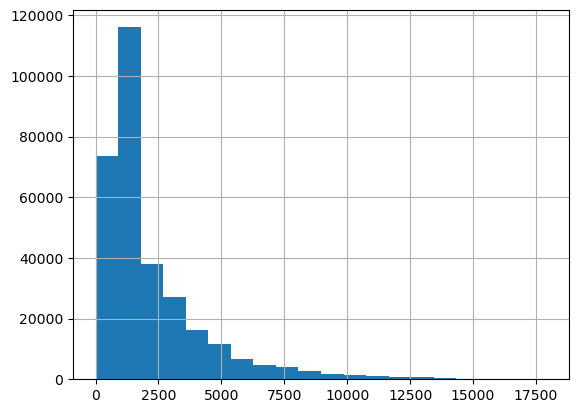

In [134]:
df_days_employed.hist(bins=20)

<Axes: >

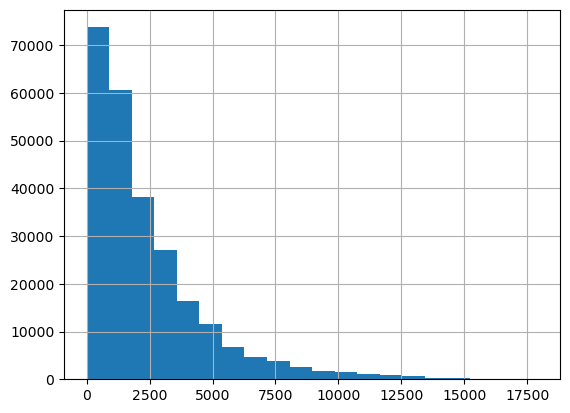

In [135]:
df[df['DAYS_EMPLOYED'] != 365243].DAYS_EMPLOYED.hist(bins=20)

In [136]:
df[df['DAYS_EMPLOYED'] == 365243].NAME_INCOME_TYPE.value_counts()

NAME_INCOME_TYPE
Pensioner     55352
Unemployed       22
Name: count, dtype: int64

#### Створимо нову колонку `YEARS_EMPLOYED` для зручності аналізу

In [137]:
df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: round(x/365))

### Аналіз стовпця `DAYS_REGISTRATION`

In [138]:
df['DAYS_REGISTRATION'].value_counts().head()

DAYS_REGISTRATION
-1.00    113
-7.00     98
-6.00     96
-4.00     92
-2.00     92
Name: count, dtype: int64

In [139]:
df['DAYS_REGISTRATION'].value_counts(normalize = True).head()

DAYS_REGISTRATION
-1.00   0.00
-7.00   0.00
-6.00   0.00
-4.00   0.00
-2.00   0.00
Name: proportion, dtype: float64

In [140]:
df['DAYS_REGISTRATION'].unique()

array([ -3648.,  -1186.,  -4260., ..., -16396., -14558., -14798.])

In [141]:
df['DAYS_REGISTRATION'].nunique()

15688

Перетворення `DAYS_REGISTRATION` в додатні дні

In [142]:
df['DAYS_REGISTRATION'] = df['DAYS_REGISTRATION'].apply(lambda x: -x if x < 0 else x)

In [143]:
df['DAYS_REGISTRATION'].value_counts().head()

DAYS_REGISTRATION
1.00    113
7.00     98
6.00     96
4.00     92
2.00     92
Name: count, dtype: int64

Всі дні в `DAYS_REGISTRATION` мають додатні значення

#### Створимо нову колонку `YEARS_REGISTRATION` для зручності аналізу

In [144]:
df['YEARS_REGISTRATION'] = df['DAYS_REGISTRATION'].apply(lambda x: round(x/365))

### Аналіз стовпця `DAYS_ID_PUBLISH`

In [145]:
df['DAYS_ID_PUBLISH'].value_counts().head()

DAYS_ID_PUBLISH
-4053    169
-4095    162
-4046    161
-4417    159
-4256    158
Name: count, dtype: int64

In [146]:
df['DAYS_ID_PUBLISH'].value_counts(normalize = True).head()

DAYS_ID_PUBLISH
-4053   0.00
-4095   0.00
-4046   0.00
-4417   0.00
-4256   0.00
Name: proportion, dtype: float64

In [147]:
df['DAYS_ID_PUBLISH'].unique()

array([-2120,  -291, -2531, ..., -6194, -5854, -6211])

In [148]:
df['DAYS_ID_PUBLISH'].nunique()

6168

Перетворення `DAYS_ID_PUBLISH` в додатні дні

In [149]:
df['DAYS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].apply(lambda x: -x if x < 0 else x)

In [150]:
df['DAYS_ID_PUBLISH'].value_counts().head()

DAYS_ID_PUBLISH
4053    169
4095    162
4046    161
4417    159
4256    158
Name: count, dtype: int64

Всі дні в `DAYS_ID_PUBLISH` мають додатні значення

#### Створимо нову колонку `YEARS_ID_PUBLISH` для зручності аналізу

In [151]:
df['YEARS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].apply(lambda x: round(x/365))

### Аналіз стовпця `DAYS_LAST_PHONE_CHANGE`

In [152]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts().head()

DAYS_LAST_PHONE_CHANGE
0.00     37672
-1.00     2812
-2.00     2318
-3.00     1763
-4.00     1285
Name: count, dtype: int64

In [153]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts(normalize = True).head()

DAYS_LAST_PHONE_CHANGE
0.00    0.12
-1.00   0.01
-2.00   0.01
-3.00   0.01
-4.00   0.00
Name: proportion, dtype: float64

In [154]:
df['DAYS_LAST_PHONE_CHANGE'].unique()

array([-1134.,  -828.,  -815., ..., -3988., -3899., -3538.])

In [155]:
df['DAYS_LAST_PHONE_CHANGE'].nunique()

3773

Перетворення `DAYS_LAST_PHONE_CHANGE` в додатні дні

In [156]:
df['DAYS_LAST_PHONE_CHANGE'] = df['DAYS_LAST_PHONE_CHANGE'].apply(lambda x: -x if x < 0 else x)

In [157]:
df['DAYS_LAST_PHONE_CHANGE'].value_counts().head()

DAYS_LAST_PHONE_CHANGE
0.00    37672
1.00     2812
2.00     2318
3.00     1763
4.00     1285
Name: count, dtype: int64

Всі дні в `DAYS_LAST_PHONE_CHANGE` мають додатні значення

#### Створення нової колонки `YEARS_LAST_PHONE_CHANGE` для зручності аналізу

In [158]:
df['YEARS_LAST_PHONE_CHANGE'] = df['DAYS_LAST_PHONE_CHANGE'].apply(lambda x: round(x/365,0))

# Функції для автоматизації

### Створення функції `age_cat` для категоризації даних, що містять інформацію про роки

In [159]:
def age_cat(years):
    if years <= 20:
        return '0-20'
    elif years > 20 and years <= 30:
        return '20-30'
    elif years > 30 and years <= 40:
        return '30-40'
    elif years > 40 and years <= 50:
        return '40-50'
    elif years > 50 and years <= 60:
        return '50-60'
    elif years > 60 and years <= 70:
        return '60-70'
    elif years > 70:
        return '70+'

### Одномірний (категоріальний vs цільовий) та двомірний (категоріальний vs категоріальний) аналіз (гістограма) - категоріальні стовпчики

In [160]:
import matplotlib.pyplot as plt


def bi_cat_countplot(df, column, hue_column):
    unique_hue_values = df[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,6)

    pltname = f'Нормалізований розподіл значень за категорією: {column}'
    proportions = df.groupby(hue_column)[column].value_counts(normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[0], title=pltname)

    # анотація значень в барплоті
    for container in ax.containers:
        ax.bar_label(container, fmt='{:,.1f}%')

    pltname = f'Кількість даних за категорією: {column}'
    counts = df.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[1], title=pltname)

    for container in ax.containers:
      ax.bar_label(container)


def uni_cat_target_compare(df, column):
    bi_cat_countplot(df, column, hue_column='TARGET')


### Обчислення мінімального та максимального діапазону відхилень для числових стовпців

In [161]:
def outlier_range(dataset,column):
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    Min_value = (Q1 - 1.5 * IQR)
    Max_value = (Q3 + 1.5 * IQR)
    return Max_value

### Робота з викидами для числових стовпців

In [162]:
import warnings

def dist_box(dataset, column):
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")

      plt.figure(figsize=(16,6))

      plt.subplot(1,2,1)
      sns.distplot(dataset[column], color = 'purple')
      pltname = 'Графік розподілу для ' + column
      plt.ticklabel_format(style='plain', axis='x')
      plt.title(pltname)

      plt.subplot(1,2,2)
      red_diamond = dict(markerfacecolor='r', marker='D')
      sns.boxplot(y = column, data = dataset, flierprops = red_diamond)
      pltname = 'Боксплот для ' + column
      plt.title(pltname)

      plt.show()

### Аналіз стовпця`CNT_CHILDREN`

In [163]:
df['CNT_CHILDREN'].value_counts().sort_values(ascending = False);

In [164]:
(df['CNT_CHILDREN'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

CNT_CHILDREN
0   70.04
1   19.88
2    8.70
3    1.21
4    0.14
Name: proportion, dtype: float64

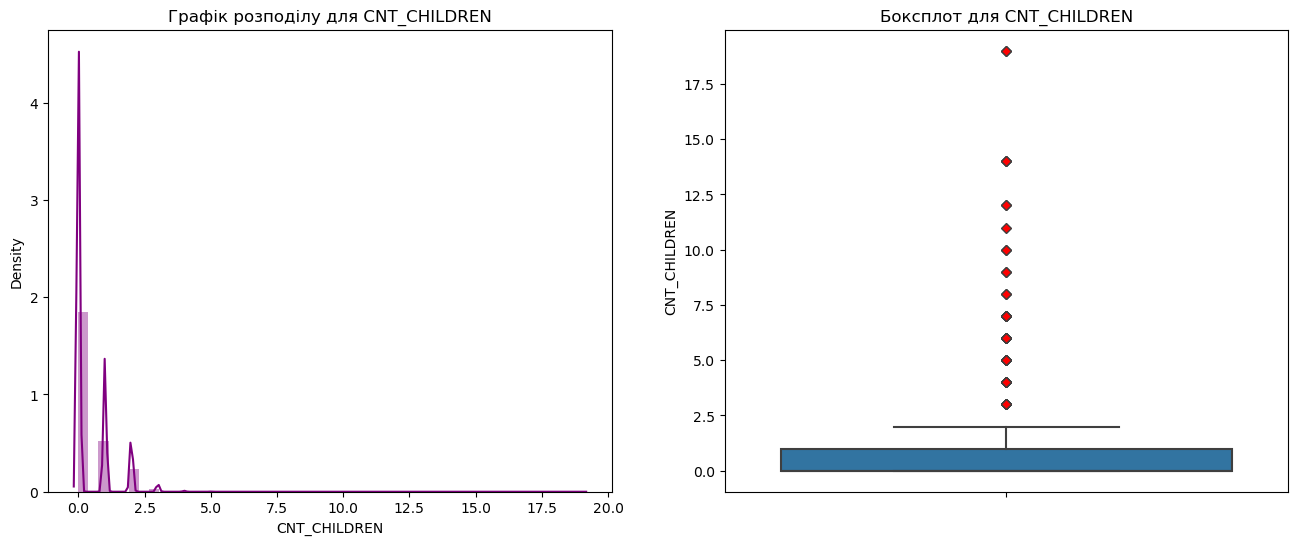

In [165]:
dist_box(df,'CNT_CHILDREN')

Розрахуємо IQR (Inter Quartile range)

In [166]:
Q1 = df['CNT_CHILDREN'].quantile(0.25)
Q3 = df['CNT_CHILDREN'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

1.0


In [167]:
Q1, Q3

(0.0, 1.0)

Значення *до* (Q1 - 1,5 * IQR) та *після* (Q3 + 1,5 * IQR) є викидами

In [168]:
Min_value = (Q1 - 1.5 * IQR)
Max_value = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value))

Мінімальне значення, до якого існують викиди: -1.5
Максимальне значення, після якого існують викиди: 2.5


In [169]:
df[df['CNT_CHILDREN'].isin(range(10,20))].YEARS_BIRTH

34545     47
80948     39
132585    31
155369    30
171125    38
176011    49
183878    56
186820    41
265784    28
267998    42
Name: YEARS_BIRTH, dtype: int64

In [170]:
df[df['CNT_CHILDREN'].isin([10])][['SK_ID_CURR', 'CNT_CHILDREN', 'YEARS_BIRTH']]

SK_ID_CURR  CNT_CHILDREN  YEARS_BIRTH
132585     253779            10           31
186820     316580            10           41

**Спостереження**
- Дивлячись на дані, ми бачимо, що кількість заявників, які мають більше 7 дітей, є дуже мінімальною (2 або 3 в кожній категорії)
- Крім того, дивлячись на дані для заявників з 10 дітьми, заявники мають лише 31 й 41 рік відповідно. Це виглядає як одиничний випадок й може розглядатися як відхилення від норми
- Як дистрибутивні, так і діаграми розмаху чітко показують, що значення, які перевищують значення 2.5, є відхиленнями від норми.

**Висновок**
- Заявники, які мають 3 або більше дітей, є випадками, що відхиляються від норми. Ми можемо надати спеціальний аналіз для цих випадків.

### Аналіз стовпця `AMT_INCOME_TOTAL`

In [171]:
df['AMT_INCOME_TOTAL'].value_counts().sort_values(ascending = False).head()

AMT_INCOME_TOTAL
135000.00    35750
112500.00    31019
157500.00    26556
180000.00    24719
90000.00     22483
Name: count, dtype: int64

In [172]:
(df['AMT_INCOME_TOTAL'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

AMT_INCOME_TOTAL
135000.00   11.63
112500.00   10.09
157500.00    8.64
180000.00    8.04
90000.00     7.31
Name: proportion, dtype: float64

In [173]:
df['AMT_INCOME_TOTAL'].describe(percentiles = [0.75,0.99,0.999])

count      307511.00
mean       168797.92
std        237123.15
min         25650.00
50%        147150.00
75%        202500.00
99%        472500.00
99.9%      900000.00
max     117000000.00
Name: AMT_INCOME_TOTAL, dtype: float64

Побудуємо графік для `AMT_INCOME_TOTAL`

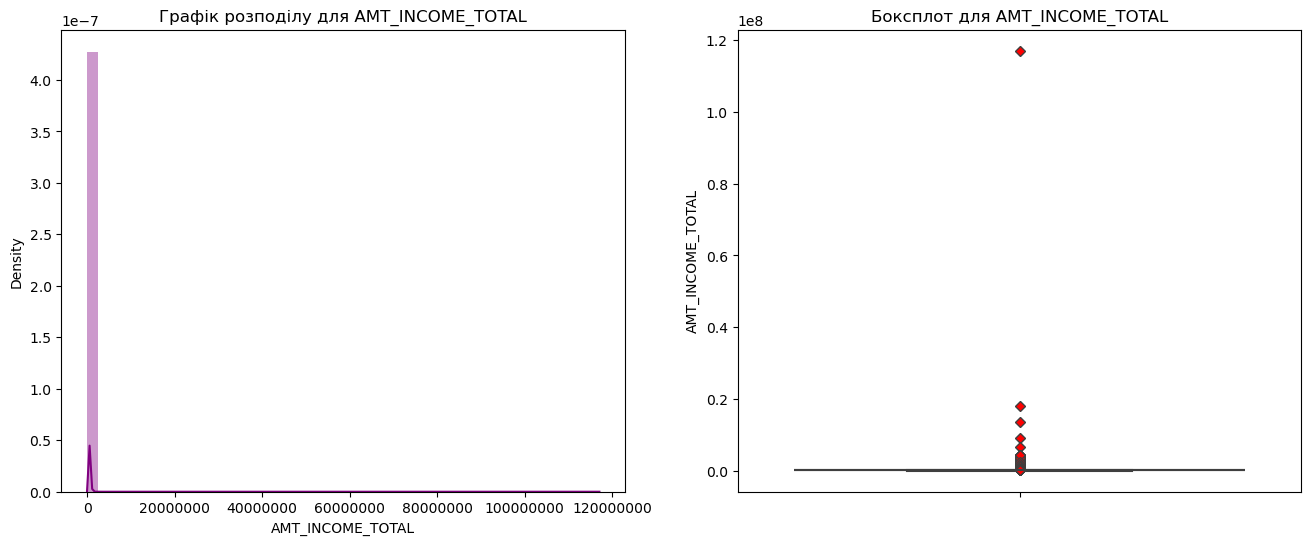

In [174]:
dist_box(df,'AMT_INCOME_TOTAL')

- Графіки кінцевого результату дуже тонкі, й ми можемо спостерігати викид близько ~120 мільйонів.
- Давайте побудуємо графік, розглядаючи лише дохід нижче 99,9% значення, тобто 900 тисяч.

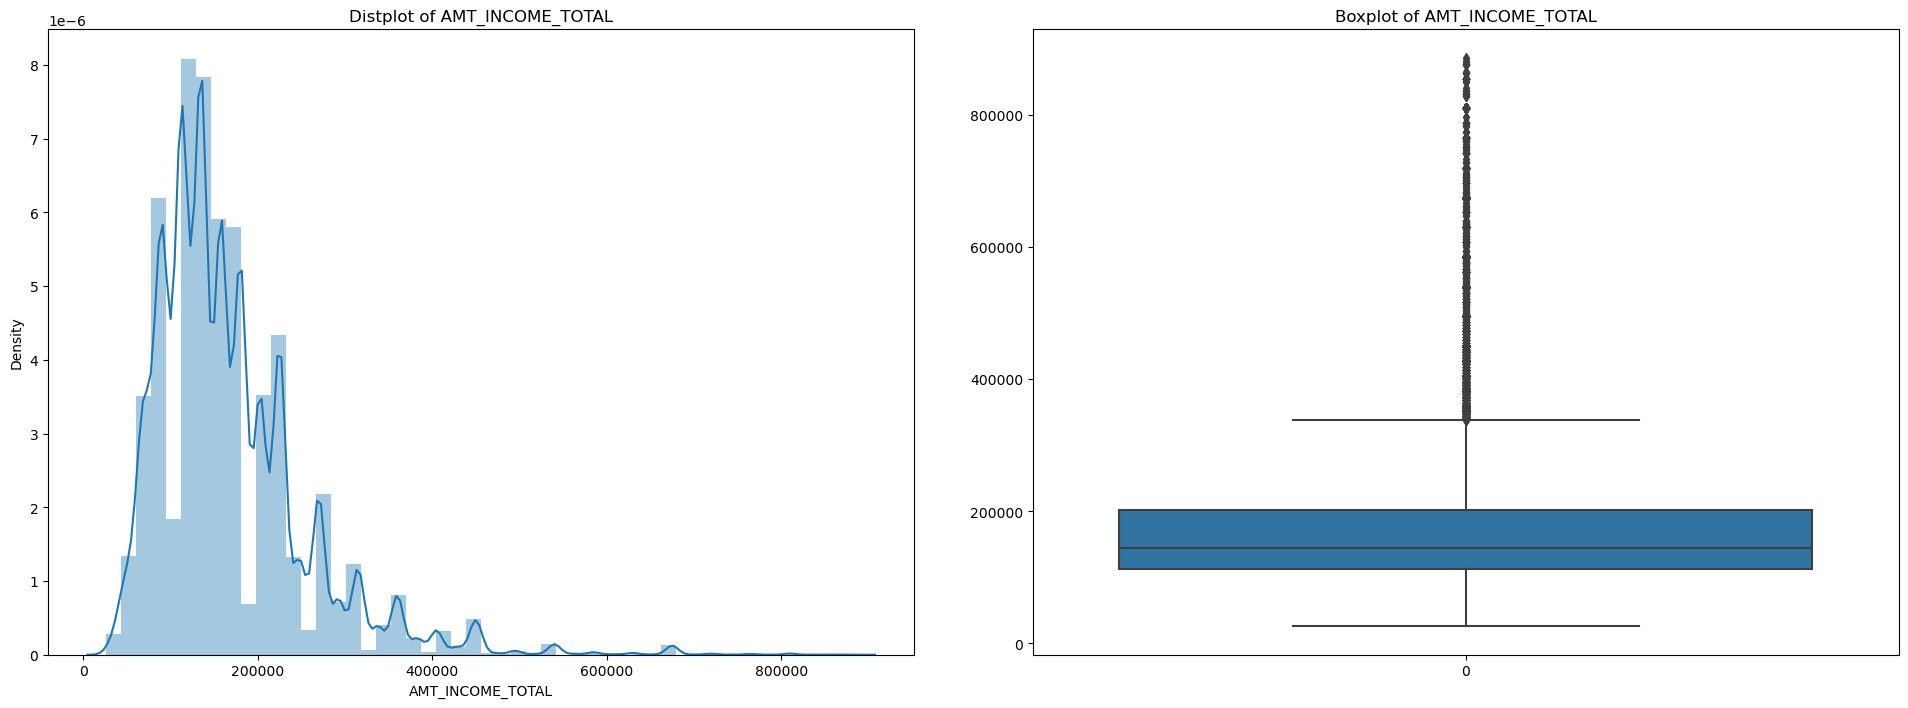

In [175]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.subplots(1,2 ,figsize = (20,8))

    plt.subplot(121)
    sns.distplot(df[df['AMT_INCOME_TOTAL'] < 900000].AMT_INCOME_TOTAL)
    pltname = 'Distplot of ' + 'AMT_INCOME_TOTAL'
    plt.title(pltname)

    plt.subplot(122)
    sns.boxplot(df[df['AMT_INCOME_TOTAL'] < 900000].AMT_INCOME_TOTAL)
    pltname = 'Boxplot of ' + 'AMT_INCOME_TOTAL'
    plt.title(pltname)

    plt.tight_layout(pad = 4)
    plt.show()

Тепер ми можемо чітко побачити розподіл і діапазон даних на обох графіках.
 - Це означає, що значення понад 900 тис. грн доходу явно є викидами

In [176]:
df[df['AMT_INCOME_TOTAL'] > 900000].head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
1504     101769       0    Revolving loans           M             1   
1723     102015       0         Cash loans           F             0   
3371     103938       0         Cash loans           F             0   
4603     105384       0    Revolving loans           F             1   
5673     106637       0         Cash loans           M             1   

      FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
1504                1             0        1080000.00   180000.00   
1723                1             0        1935000.00   269550.00   
3371                0             1        1350000.00  2410380.00   
4603                1             0        1350000.00   405000.00   
5673                1             3         967500.00   450000.00   

      AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
1504      9000.00        180000.00   Unaccompanied  Commercial associate   
1723     10534.50        225000.00   Unaccompanied             Pensioner   
3371    109053.00       2250000.00              NA  Commercial associate   
4603     20250.00        405000.00   Unaccompanied  Commercial associate   
5673     30073.50        450000.00   Unaccompanied  Commercial associate   

                NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
1504               Higher education            Married  House / apartment   
1723  Secondary / secondary special            Married  House / apartment   
3371               Higher education            Married  House / apartment   
4603               Higher education            Married  House / apartment   
5673               Higher education            Married  House / apartment   

      REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
1504                        0.07       13633           5536   
1723                        0.01       18636         365243   
3371                        0.07       12213            843   
4603                        0.02       14781           4768   
5673                        0.05       11901            546   

      DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
1504               3.00             4971           1               1   
1723            3401.00             2168           1               0   
3371             757.00             4132           1               1   
4603            3469.00             4045           1               1   
5673            2932.00              215           1               1   

      FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
1504                0                 1           0           0   
1723                0                 1           1           0   
3371                0                 1           1           0   
4603                0                 1           0           0   
5673                0                 1           0           0   

     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
1504         Unknown             2.00                     1   
1723         Unknown             2.00                     2   
3371        Managers             3.00                     1   
4603        Managers             2.00                     2   
5673        Managers             5.00                     1   

      REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
1504                            1                     FRIDAY   
1723                            2                     MONDAY   
3371                            1                     SUNDAY   
4603                            2                    TUESDAY   
5673                            1                     MONDAY   

      HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
1504                       13                           0   
1723                       11                           0   
3371                       13                           0   
4603          

**Спостереження**
- Дивлячись на дані, ми бачимо, що дохід понад 900 тис. грн (99,9% значення) є викидом
- Як діаграма розподілу, так і діаграма розмаху чітко показують нам ту саму тенденцію

**Висновок**
- Апліканти з доходом понад 900 тис. грн (99,9% значення) є викидами

# ДЗ 3. Аналіз викидів

Подібно до прикладу, проаналізуйте на викиди колонок
- `CNT_FAM_MEMBERS`
- `AMT_ANNUITY`

Зазначте, які значення в них можна вважати викидами.

### Аналіз стовпця - CNT_FAM_MEMBERS

Подивимось розподіл значень по к-ті

In [177]:
df['CNT_FAM_MEMBERS'].value_counts().sort_values(ascending = False)

CNT_FAM_MEMBERS
2.00     158357
1.00      67847
3.00      52601
4.00      24697
5.00       3478
6.00        408
7.00         81
8.00         20
9.00          6
10.00         3
14.00         2
12.00         2
20.00         2
16.00         2
13.00         1
15.00         1
11.00         1
Name: count, dtype: int64

Найбільшу к-ть мають сімʼ з 2 осіб, перевіримо скільки це у відсотковому відношенні

In [178]:
(df['CNT_FAM_MEMBERS'].value_counts(normalize = True).sort_values(ascending = False) * 100).head(10)

CNT_FAM_MEMBERS
2.00    51.50
1.00    22.06
3.00    17.11
4.00     8.03
5.00     1.13
6.00     0.13
7.00     0.03
8.00     0.01
9.00     0.00
10.00    0.00
Name: proportion, dtype: float64

Використаємо функцію, для відображення даних, щоб ліпше зрозуміти розподіл даних та побачити викиди 

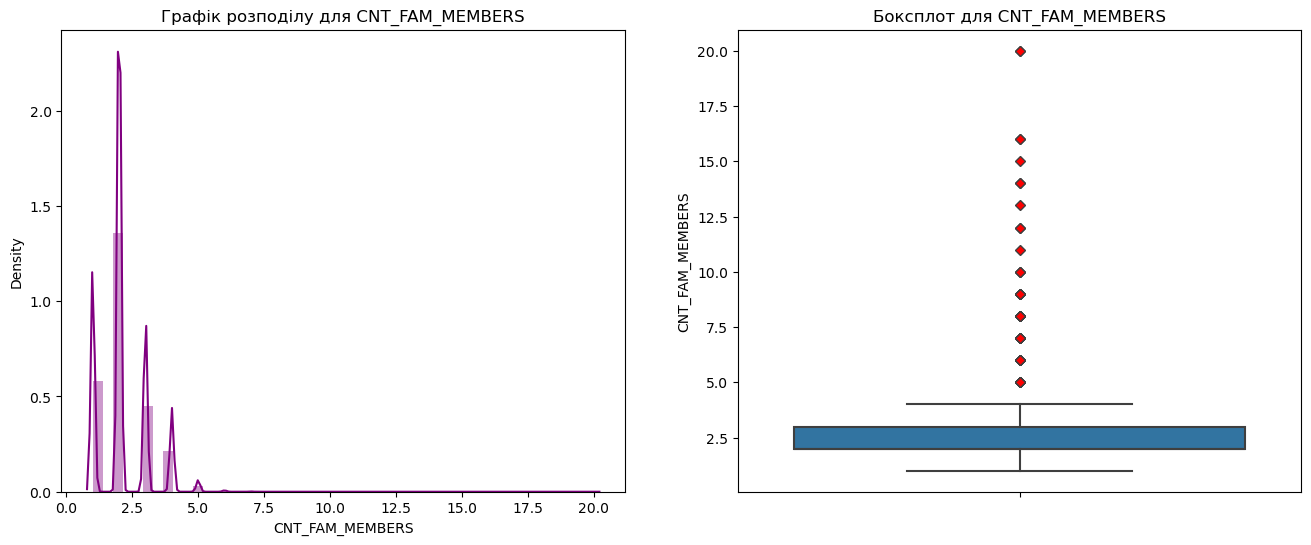

In [179]:
dist_box(df,'CNT_FAM_MEMBERS')

По візуалізації бачимо, що в нас є викиди коли в сімʼї є більше ніж 5 осіб, що дійсно може бути як вийняток і таких сімей не багато, що може бути правдою, 

Порахуємо IQR, щоб побачити, що можна вважати викидами математично з відсоткового значення

In [180]:
Q1 = df['CNT_FAM_MEMBERS'].quantile(0.25)
Q3 = df['CNT_FAM_MEMBERS'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

1.0


In [181]:
Min_value = (Q1 - 1.5 * IQR)
Max_value = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value))

Мінімальне значення, до якого існують викиди: 0.5
Максимальне значення, після якого існують викиди: 4.5


Якщо заокруглити значення, так як ми не можемо мати пів особи, бачимо, що попередні аналіз підтверджується і можна вважати викидами сім'ї - де більше 5 осіб.

Подивимось в якій віковій категорії люди, що мають великі сімʼї

In [203]:
df[df['CNT_FAM_MEMBERS'].isin(range(9,20))].YEARS_BIRTH #.apply(age_cat).sort_values(ascending = False)

3079      48
12615     42
23881     30
26195     41
34545     47
80948     39
116428    34
132585    31
154317    31
171125    38
176011    49
183878    56
186820    41
190547    48
220134    38
233611    48
267998    42
276768    40
Name: YEARS_BIRTH, dtype: int64

In [183]:
df[df['CNT_FAM_MEMBERS'].isin([9])][['SK_ID_CURR', 'CNT_FAM_MEMBERS', 'YEARS_BIRTH']]

SK_ID_CURR  CNT_FAM_MEMBERS  YEARS_BIRTH
3079       103596             9.00           48
26195      130468             9.00           41
116428     235015             9.00           34
190547     320933             9.00           48
220134     355015             9.00           38
233611     370590             9.00           48

**Спостереження**
- Дивлячись на дані, ми бачимо, що кількість заявників, які мають більше 9 осіб в сімʼї, є дуже мінімальною й може розглядатися як відхилення від норми
- Як дистрибутивні, так і діаграми розмаху чітко показують, що значення, які перевищують значення 4.5, є відхиленнями від норми.

**Висновок**
- Заявники, які мають 5 або більше осіб в сімʼї, є випадками, що відхиляються від норми. Ми можемо надати спеціальний аналіз для цих випадків.

#### Зробимо аналіз - AMT_ANNUITY

In [184]:
df['AMT_ANNUITY'].value_counts().sort_values(ascending = False)

AMT_ANNUITY
9000.00     6385
13500.00    5514
6750.00     2279
10125.00    2035
37800.00    1602
            ... 
72067.50       1
62856.00       1
60975.00       1
47655.00       1
77809.50       1
Name: count, Length: 13672, dtype: int64

In [185]:
(df['AMT_ANNUITY'].value_counts(normalize = True).sort_values(ascending = False) * 100).head(5)

AMT_ANNUITY
9000.00    2.08
13500.00   1.79
6750.00    0.74
10125.00   0.66
37800.00   0.52
Name: proportion, dtype: float64

По цьому розподілу бачимо, що дуже великий відсоток значень є унікальними і важко зробити якийсь висновок

Перевіримо розподіл персентилями

In [186]:
df['AMT_ANNUITY'].describe(percentiles = [0.75,0.99,0.999])

count   307499.00
mean     27108.57
std      14493.74
min       1615.50
50%      24903.00
75%      34596.00
99%      70006.50
99.9%   110047.50
max     258025.50
Name: AMT_ANNUITY, dtype: float64

Маємо велику різницю між значеннями 99%, 99.9% і max, тобто є невелика к-ть людей з дуже високою дохідністю від оренди.

Поглянемо на графіку

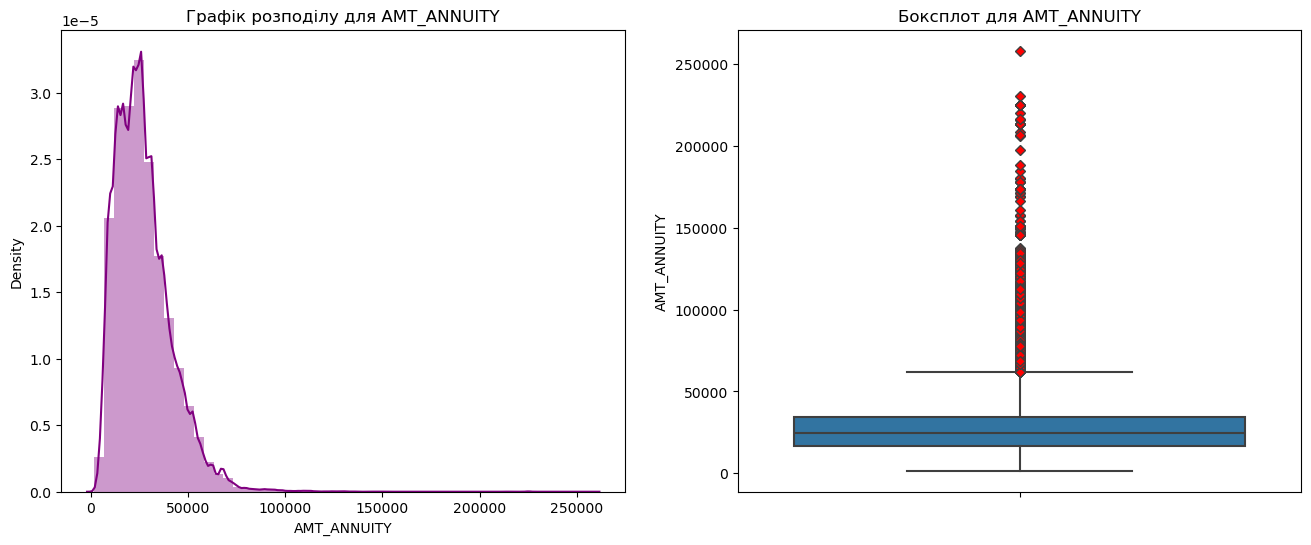

In [187]:
dist_box(df,'AMT_ANNUITY')

Графік більш менш показовий ми бачимо значеня які явно відхиляються від середнього, але поглянемо графік без цих випадів, і зробимо обмеження до значення, яке потрапляє в 99.9% = 110000

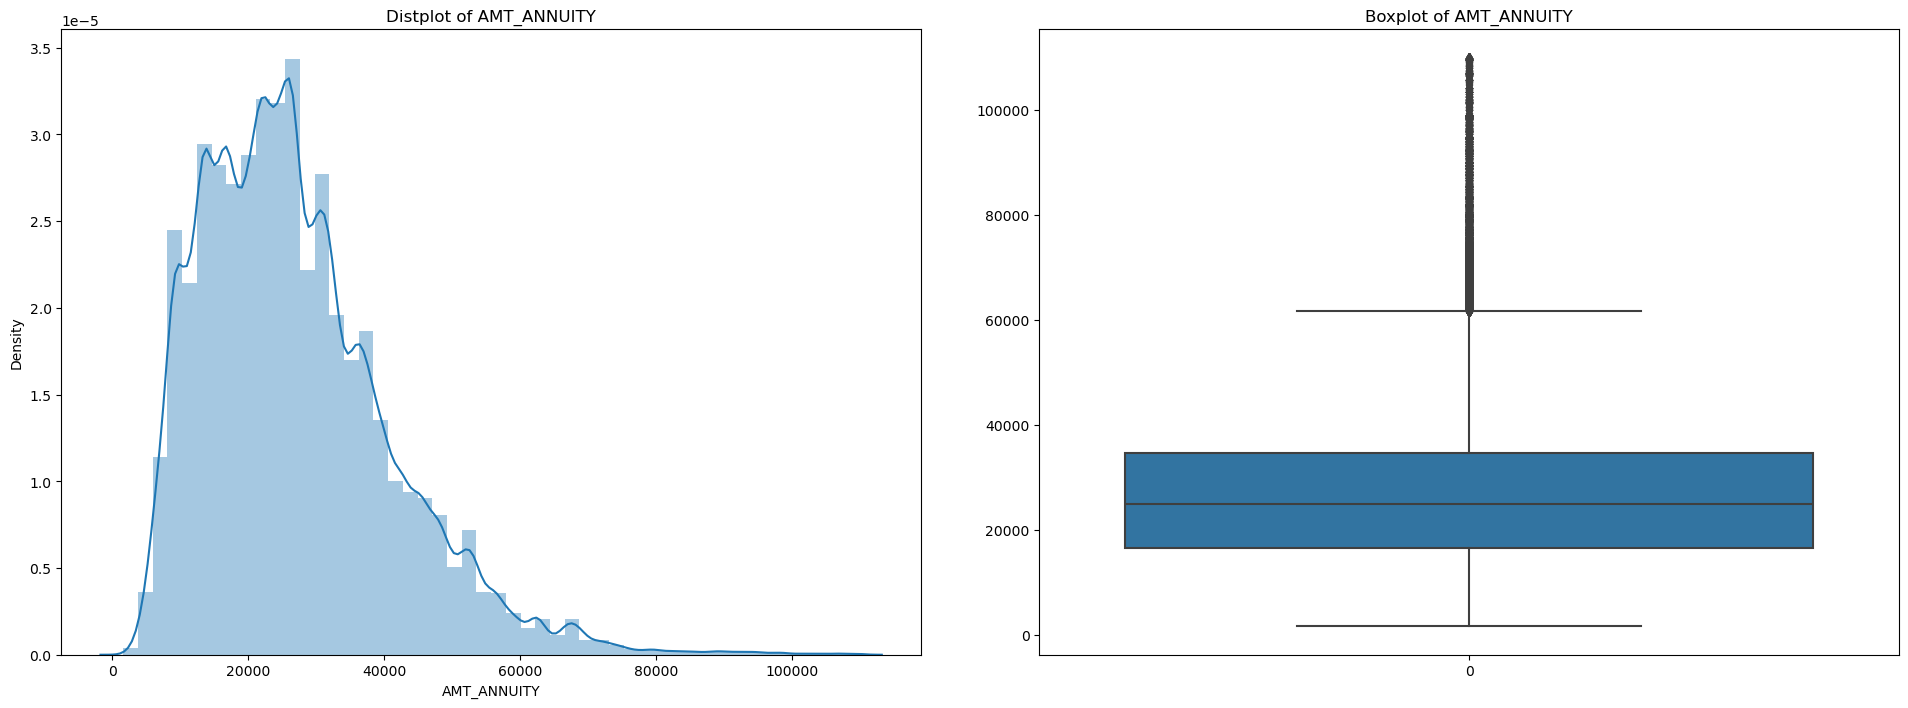

In [188]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.subplots(1,2 ,figsize = (20,8))

    plt.subplot(121)
    sns.distplot(df[df['AMT_ANNUITY'] < 110000].AMT_ANNUITY)
    pltname = 'Distplot of ' + 'AMT_ANNUITY'
    plt.title(pltname)

    plt.subplot(122)
    sns.boxplot(df[df['AMT_ANNUITY'] < 110000].AMT_ANNUITY)
    pltname = 'Boxplot of ' + 'AMT_ANNUITY'
    plt.title(pltname)

    plt.tight_layout(pad = 4)
    plt.show()

In [189]:
df[df['AMT_ANNUITY'] > 110000].head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
485      100559       0         Cash loans           F             1   
1446     101701       0         Cash loans           F             1   
2513     102931       0         Cash loans           F             1   
3228     103767       0         Cash loans           M             1   
3428     104003       0         Cash loans           F             1   

      FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
485                 1             0         450000.00  2286211.50   
1446                0             1         360000.00  2250000.00   
2513                1             1         292500.00  1409719.50   
3228                1             0         468000.00  2356920.00   
3428                1             1         180000.00  1157670.00   

      AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
485     116266.50       2182500.00    Unaccompanied         State servant   
1446    116505.00       2250000.00    Unaccompanied               Working   
2513    135936.00       1377000.00    Unaccompanied               Working   
3228    119731.50       2250000.00  Spouse, partner  Commercial associate   
3428    112909.50       1125000.00    Unaccompanied  Commercial associate   

                NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
485                Higher education            Married  House / apartment   
1446  Secondary / secondary special     Civil marriage  House / apartment   
2513  Secondary / secondary special            Married  House / apartment   
3228               Higher education     Civil marriage  House / apartment   
3428               Higher education            Married  House / apartment   

      REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
485                         0.02       20589          13994   
1446                        0.01       13374           1563   
2513                        0.05       13928           6099   
3228                        0.07        9293            953   
3428                        0.01       10414           1188   

      DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
485             5893.00             4106           1               1   
1446            4890.00             2890           1               1   
2513            7991.00             3163           1               1   
3228            4171.00             1966           1               1   
3428            4880.00             1169           1               1   

      FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
485                 0                 1           0           0   
1446                1                 1           1           0   
2513                0                 1           1           0   
3228                0                 1           0           0   
3428                0                 1           0           0   

     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
485       Core staff             2.00                     2   
1446     Sales staff             3.00                     3   
2513         Unknown             3.00                     1   
3228         Unknown             2.00                     1   
3428      Core staff             3.00                     3   

      REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
485                             2                     MONDAY   
1446                            3                  WEDNESDAY   
2513                            1                     MONDAY   
3228                            1                     MONDAY   
3428                            3                    TUESDAY   

      HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
485                        16                           0   
1446                       12                           0   
2513                       14                           0   
3228    

**Висновок**
- Заявники які мають дохід від орендної плати більше ніж 110000 можна вважати викидати

# Розбиття на біни безперервних колонок для аналізу

### Категоризація стовпця `AMT_GOODS_PRICE

In [190]:
df['AMT_GOODS_PRICE'].value_counts().sort_values(ascending = False).head()

AMT_GOODS_PRICE
450000.00    26300
225000.00    25282
675000.00    24962
900000.00    15416
270000.00    11428
Name: count, dtype: int64

In [191]:
(df['AMT_GOODS_PRICE'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

AMT_GOODS_PRICE
450000.00   8.55
225000.00   8.22
675000.00   8.12
900000.00   5.01
270000.00   3.72
Name: proportion, dtype: float64

Подивимось статистичний звіт для `AMT_GOODS_PRICE

In [192]:
df['AMT_GOODS_PRICE'].describe(percentiles = [0.25,0.75,0.99,0.9999])

count     307511.00
mean      538316.29
std       369288.98
min        40500.00
25%       238500.00
50%       450000.00
75%       679500.00
99%      1800000.00
99.99%   2933964.00
max      4050000.00
Name: AMT_GOODS_PRICE, dtype: float64

Розподілимо значення в `AMT_GOODS_PRICE` на 5 бінів і створимо новий стовпець `AMT_GOODS_PRICE_CATEGORY`.

In [193]:
df['AMT_GOODS_PRICE_CATEGORY'] = pd.cut(df['AMT_GOODS_PRICE'],
                                        bins = 5, labels = ['very low', 'low', 'medium', 'high', 'very high'])

Перевірка заповнення значень згідно з очікуванням

In [194]:
df['AMT_GOODS_PRICE_CATEGORY'].value_counts()

AMT_GOODS_PRICE_CATEGORY
very low     247251
low           56087
medium         4108
high             47
very high        18
Name: count, dtype: int64

### Категоризація стовпця `YEARS_BIRTH`

Ми будемо класифікувати `YEARS_BIRTH` замість `DAYS_BIRTH`, оскільки роки легше інтерпретувати, ніж дні

In [195]:
df['YEARS_BIRTH'].value_counts().sort_values(ascending = False).head()

YEARS_BIRTH
39    9023
38    8793
37    8727
40    8602
41    8495
Name: count, dtype: int64

In [196]:
(df['YEARS_BIRTH'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

YEARS_BIRTH
39   2.93
38   2.86
37   2.84
40   2.80
41   2.76
Name: proportion, dtype: float64

Подивимось статистичний звіт для  `YEARS_BIRTH`

In [197]:
df['YEARS_BIRTH'].describe(percentiles = [0.25,0.75,0.99,0.9999])

count    307511.00
mean         43.94
std          11.96
min          21.00
25%          34.00
50%          43.00
75%          54.00
99%          67.00
99.99%       69.00
max          69.00
Name: YEARS_BIRTH, dtype: float64

Категоризуймо значення з `YEARS_BIRTH` у новий стовпець `YEARS_BIRTH_CATEGORY`.

In [198]:
df['YEARS_BIRTH_CATEGORY'] = df['YEARS_BIRTH'].apply(age_cat)

Перевірка заповнення значень згідно з очікуванням

In [199]:
df['YEARS_BIRTH_CATEGORY'].value_counts().sort_values(ascending = False)

YEARS_BIRTH_CATEGORY
30-40    82770
40-50    75509
50-60    67955
20-30    48869
60-70    32408
Name: count, dtype: int64

### Категоризація стовпця `YEARS_REGISTRATION`

Ми будемо класифікувати `YEARS_REGISTRATION` замість `DAYS_REGISTRATION`, оскільки роки легше інтерпретувати, ніж дні

In [204]:
df['YEARS_REGISTRATION'].value_counts().sort_values(ascending = False).head()

YEARS_REGISTRATION
1     15661
2     15564
3     13894
13    12866
12    12697
Name: count, dtype: int64

In [205]:
(df['YEARS_REGISTRATION'].value_counts(normalize = True).sort_values(ascending = False) * 100).head()

YEARS_REGISTRATION
1    5.09
2    5.06
3    4.52
13   4.18
12   4.13
Name: proportion, dtype: float64

Подивимось статистичний звіт для `YEARS_REGISTRATION`

In [206]:
df['YEARS_REGISTRATION'].describe(percentiles = [0.25,0.75,0.99,0.9999])

count    307511.00
mean         13.66
std           9.66
min           0.00
25%           6.00
50%          12.00
75%          20.00
99%          38.00
99.99%       54.25
max          68.00
Name: YEARS_REGISTRATION, dtype: float64

Категоризуймо значення з `YEARS_REGISTRATION` в новий стовпець `YEARS_REGISTRATION_CATEGORY`.

In [207]:
df['YEARS_REGISTRATION_CATEGORY'] = df['YEARS_REGISTRATION'].apply(age_cat)

Перевірка заповнення значень згідно з очікуванням

In [208]:
df['YEARS_REGISTRATION_CATEGORY'].value_counts().sort_values(ascending = False)

YEARS_REGISTRATION_CATEGORY
0-20     230697
20-30     59288
30-40     16051
40-50      1406
50-60        60
60-70         9
Name: count, dtype: int64

# Зберігання оновлених даних зі стисненням

In [209]:
filename = "application_data_1.csv"
#"drive/MyDrive/Machine Learning для людей/data/credit/application_data_processed"
compression_options = dict(method='zip', archive_name=f'{filename}.csv')
df.to_csv(f'{filename}.zip', compression=compression_options, index=False)

In [ ]:
# якщо Вам треба буде зчитати оновлені дані - замініть шлях на свій і можна зчитати їх тут
#df = pd.read_csv("application_data_1.csv.zip")
    #(drive/MyDrive/Machine Learning для людей/data/credit/application_data_processed.zip')

In [210]:
df

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  \
0          100002       1         Cash loans           M             0   
1          100003       0         Cash loans           F             0   
2          100004       0    Revolving loans           M             1   
3          100006       0         Cash loans           F             0   
4          100007       0         Cash loans           M             0   
...           ...     ...                ...         ...           ...   
307506     456251       0         Cash loans           M             0   
307507     456252       0         Cash loans           F             0   
307508     456253       0         Cash loans           F             0   
307509     456254       1         Cash loans           F             0   
307510     456255       0         Cash loans           F             0   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                     1             0         202500.00   406597.50   
1                     0             0         270000.00  1293502.50   
2                     1             0          67500.00   135000.00   
3                     1             0         135000.00   312682.50   
4                     1             0         121500.00   513000.00   
...                 ...           ...               ...         ...   
307506                0             0         157500.00   254700.00   
307507                1             0          72000.00   269550.00   
307508                1             0         153000.00   677664.00   
307509                1             0         171000.00   370107.00   
307510                0             0         157500.00   675000.00   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0          24700.50        351000.00   Unaccompanied               Working   
1          35698.50       1129500.00          Family         State servant   
2           6750.00        135000.00   Unaccompanied               Working   
3          29686.50        297000.00   Unaccompanied               Working   
4          21865.50        513000.00   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307506     27558.00        225000.00   Unaccompanied               Working   
307507     12001.50        225000.00   Unaccompanied             Pensioner   
307508     29979.00        585000.00   Unaccompanied               Working   
307509     20205.00        319500.00   Unaccompanied  Commercial associate   
307510     49117.50        675000.00   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary / secondary special  Single / not married   
1                    Higher education               Married   
2       Secondary / secondary special  Single / not married   
3       Secondary / secondary special        Civil marriage   
4       Secondary / secondary special  Single / not married   
...                               ...                   ...   
307506  Secondary / secondary special             Separated   
307507  Secondary / secondary special                 Widow   
307508               Higher education             Separated   
307509  Secondary / secondary special               Married   
307510               Higher education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House / apartment                        0.02        9461   
1       House / apartment                        0.00       16765   
2       House / apartment                        0.01       19046   
3       House / apartment                        0.01       19005   
4       House / apartment                        0.03       19932   
...                   ...                         ...         ...   
307506       With parents                        0.03        9327   
307507  House / apa

# Перевірка дисбалансу для цільового стовпця `TARGET`

### Аналіз стовпця `TARGET`

In [211]:
df['TARGET'].value_counts().sort_values(ascending = False)

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [212]:
df['TARGET'].value_counts(normalize = True).sort_values(ascending = False) * 100

TARGET
0   91.93
1    8.07
Name: proportion, dtype: float64

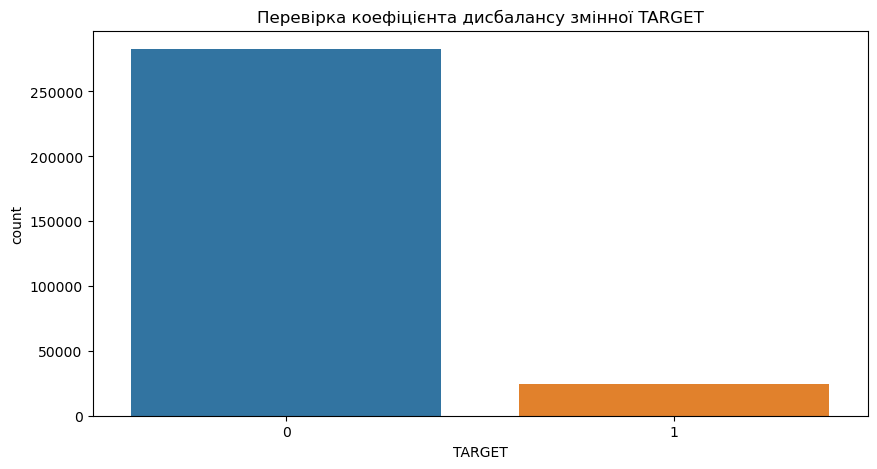

In [214]:
plt.figure(figsize = (10,5))
sns.countplot(x = df['TARGET'], data = df)
plt.title('Перевірка коефіцієнта дисбалансу змінної TARGET')
plt.show()

**Спостереження**

- Ми маємо дисбаланс у змінній `TARGET` на основі % спостережень
 - Значення `TARGET` 1 - це клієнт, який має труднощі з оплатою (прострочення платежу більше ніж на X днів принаймні за одним з перших Y платежів за кредитом). Це лише 8,07% даних
 - Значення `TARGET` 0 - всі інші випадки, окрім 1. Це 91,93% даних

# Розподіл даних на основі `TARGET`

### Створіть новий фрейм даних зі значенням `TARGET` 1
- Значення `TARGET` 1 представляє клієнта з платіжними труднощами (він/вона прострочив платіж більш ніж на X днів принаймні по одному з перших Y платежів за кредитом). Це лише 8,07% даних

In [215]:
df1 = df[df['TARGET'] == 1]

In [217]:
df1.TARGET.value_counts()

TARGET
1    24825
Name: count, dtype: int64

### Створити новий фрейм даних зі значенням `TARGET` 0
- Значення `TARGET` 0 представляє всі інші випадки, крім 1. Це 91.93% даних

In [218]:
df0 = df[df['TARGET'] == 0]

In [219]:
df0.TARGET.value_counts()

TARGET
0    282686
Name: count, dtype: int64

# Одномірний аналіз категоріальних змінних

### Аналіз стовпця `NAME_CONTRACT_TYPE`

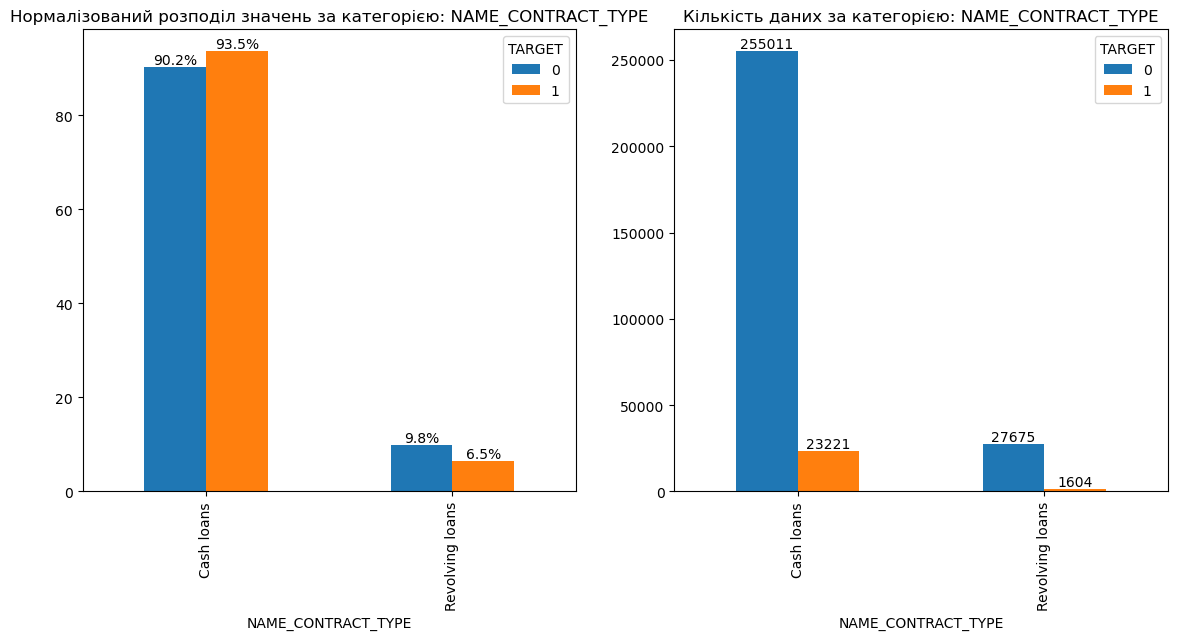

In [220]:
uni_cat_target_compare(df, 'NAME_CONTRACT_TYPE')

**Спостереження**

- Дивлячись на гістограми, ми не бачимо суттєвих відмінностей у `NAME_CONTRACT_TYPE` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно

**Висновок**
- Колонка `NAME_CONTRACT_TYPE` не надає жодних переконливих доказів на користь клієнтів, які мають труднощі з оплатою АБО вчасно сплачують

# ДЗ 4. Одновимірний аналіз категоріальної колонки

Проведіть подібний аналіз для колонок
- CODE_GENDER
- FLAG_OWN_CAR
- NAME_INCOME_TYPE

Опціонально
- NAME_EDUCATION_TYPE
- NAME_FAMILY_STATUS


Чи є вплив цих змінних на цільову та який саме?

### Аналіз стовпця `CODE_GENDER`

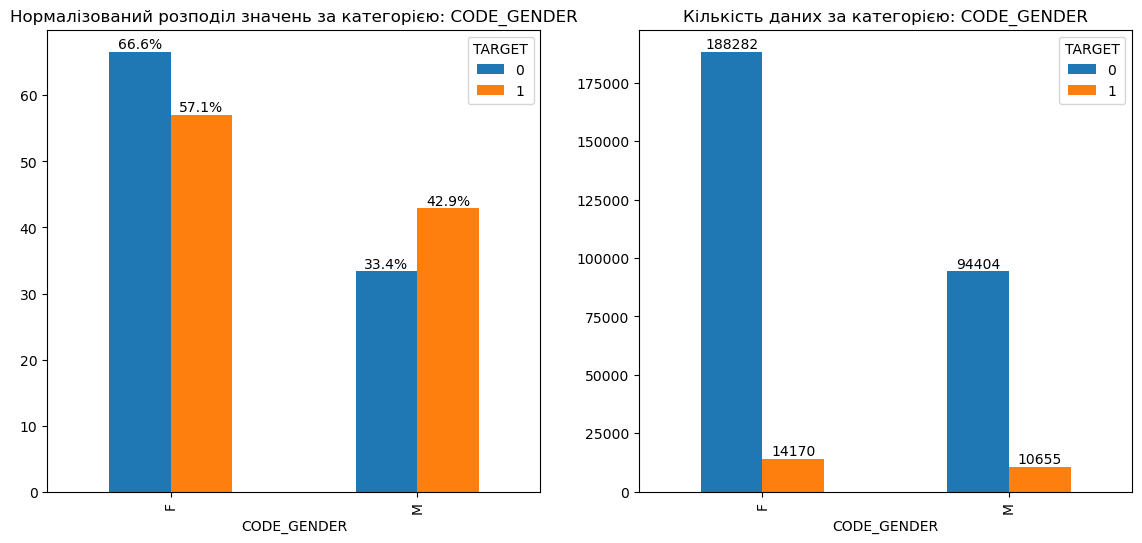

In [221]:
uni_cat_target_compare(df, 'CODE_GENDER')

**Спостереження**

- Дивлячись на гістограми, бачимо більшу відмінність ніж з `NAME_CONTRACT_TYPE` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасною, одже можемо зробити певні гіпотези
- Клієнтів жінок більше ніж чоловіків 
- В порівнянні клієнти жінки мають менше проблемних виплат, ніж чоловіки 

**Висновок**
- Колонка `CODE_GENDER`, має відмінність, і в співвідношенні до к-ті жінок і чоловіків, саме чоловіки мають більше  труднощів з виплатами

### Аналіз стовпця `FLAG_OWN_CAR`

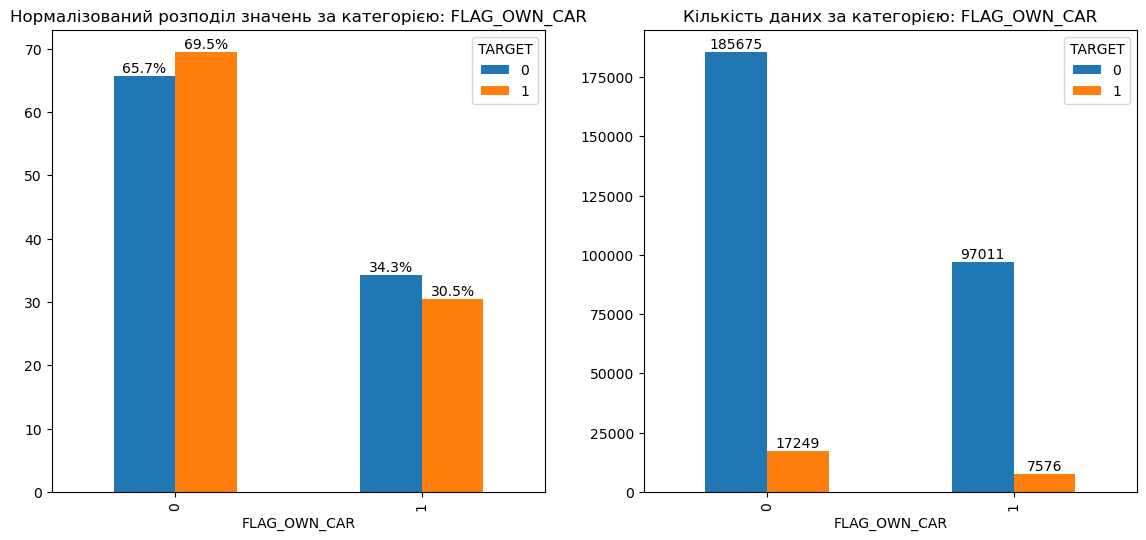

In [222]:
uni_cat_target_compare(df, 'FLAG_OWN_CAR')

**Спостереження**

- Дивлячись на гістограми, ми не бачимо суттєвих відмінностей у `FLAG_OWN_CAR` між клієнтами, які мають труднощі з оплатою, та клієнтами, які платять вчасно

**Висновок**
- Колонка `FLAG_OWN_CAR` можливо вказує нам на те ,що люди без машини можуть мати більше проблем з оплатою, але ця відмінність не суттєва, щоб зробити основний висновок на користь клієнтів, які мають труднощі з оплатою АБО вчасно сплачують

### Аналіз стовпця `NAME_INCOME_TYPE`

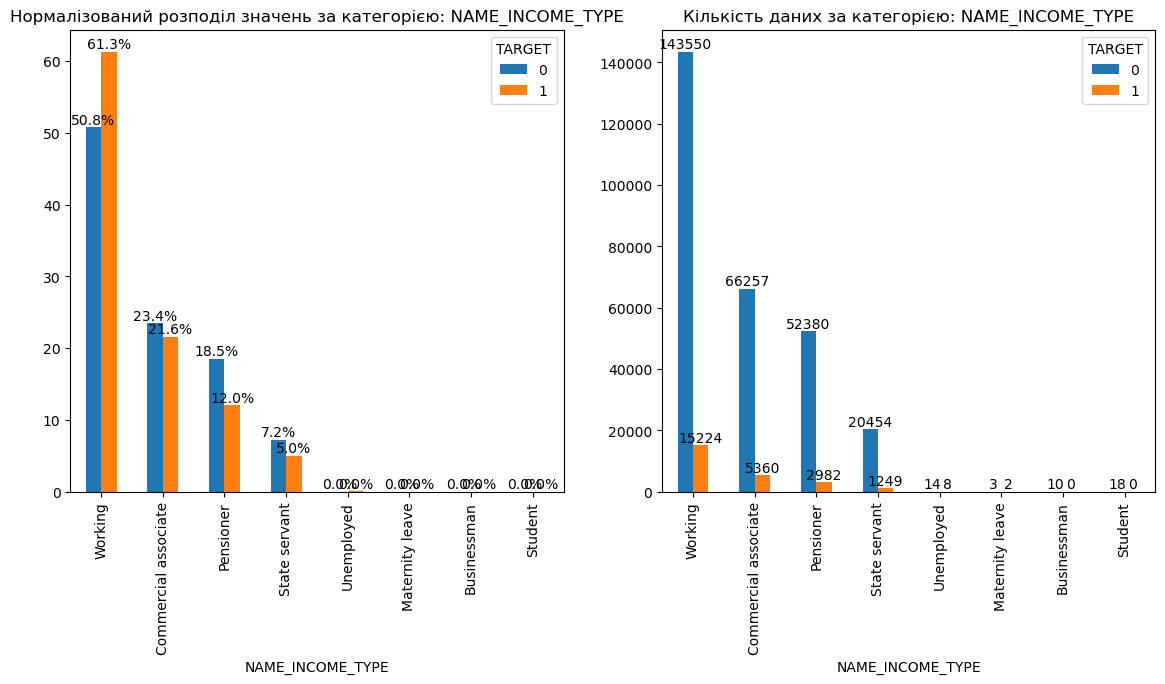

In [223]:
uni_cat_target_compare(df, 'NAME_INCOME_TYPE')

**Спостереження**

- Дивлячись на гістограми, бачимо, що акцент можна зробити на основні 4 категорії - 'Working', 'State servant', 'Commercial associate', 'Pensioner', і найбільше випалків трудностей з оплатами є в категорії 'Working', але переконливих відмінностей навести не можу, так як це можу бути через найбільшу кількість клієнтів в цій категорії

**Висновок**
- Колонка `NAME_INCOME_TYPE` показує, що категорія клієнтів з доходом 'Working' має більше випадків з трудностями по оплаті, візьмемо це до уваги та за необхідності зробимо додатковий аналіз додавши допоміжну змінну

### Аналіз стовпця `NAME_EDUCATION_TYPE`

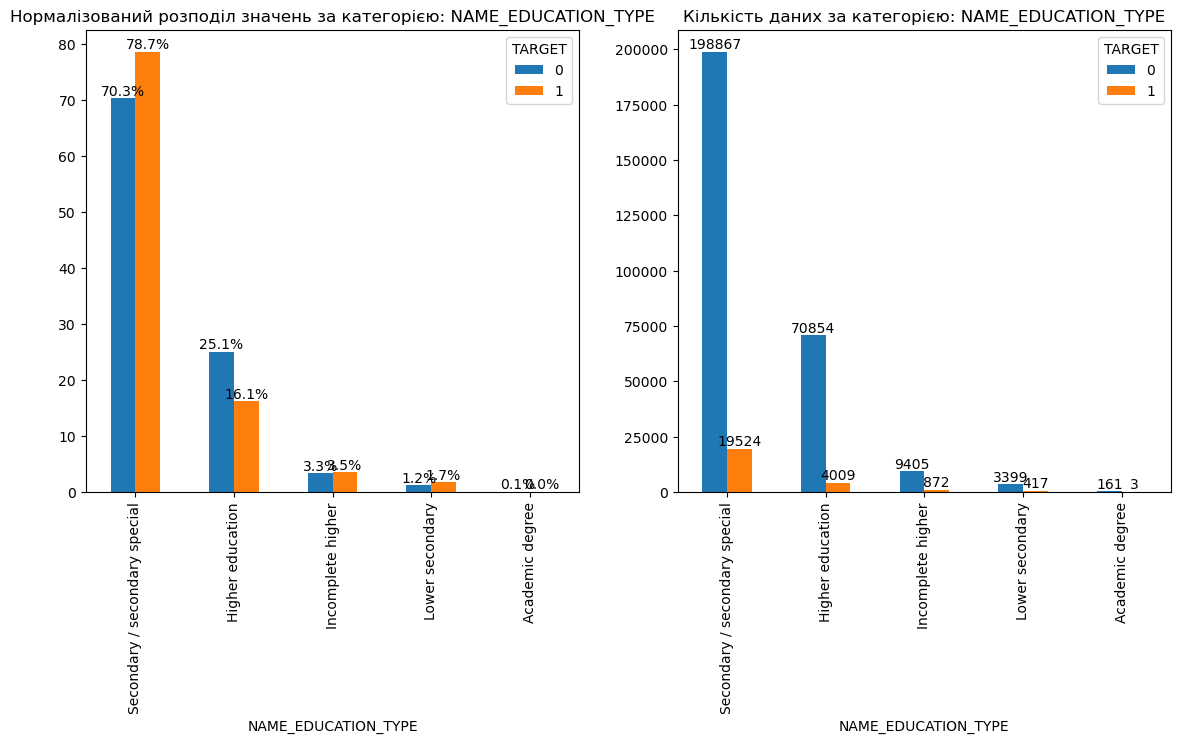

In [224]:
uni_cat_target_compare(df, 'NAME_EDUCATION_TYPE')

**Спостереження**

- Дивлячись на гістограми, ми бачимо певну залежність рівня освіти до виплат і чим вища оствіта тим відсотково менше проблемних випадків з виплатамии

**Висновок**
- Колонка `NAME_EDUCATION_TYPE` показує нам певну залежність від рівня освіти та випадками проблем з виплатами і чим вища освіта тим менше проблемних випадків з виплатами, можемо взяти це до уваги, і проаналізуємо наступні дані 

### Аналіз стовпця `NAME_FAMILY_STATUS`

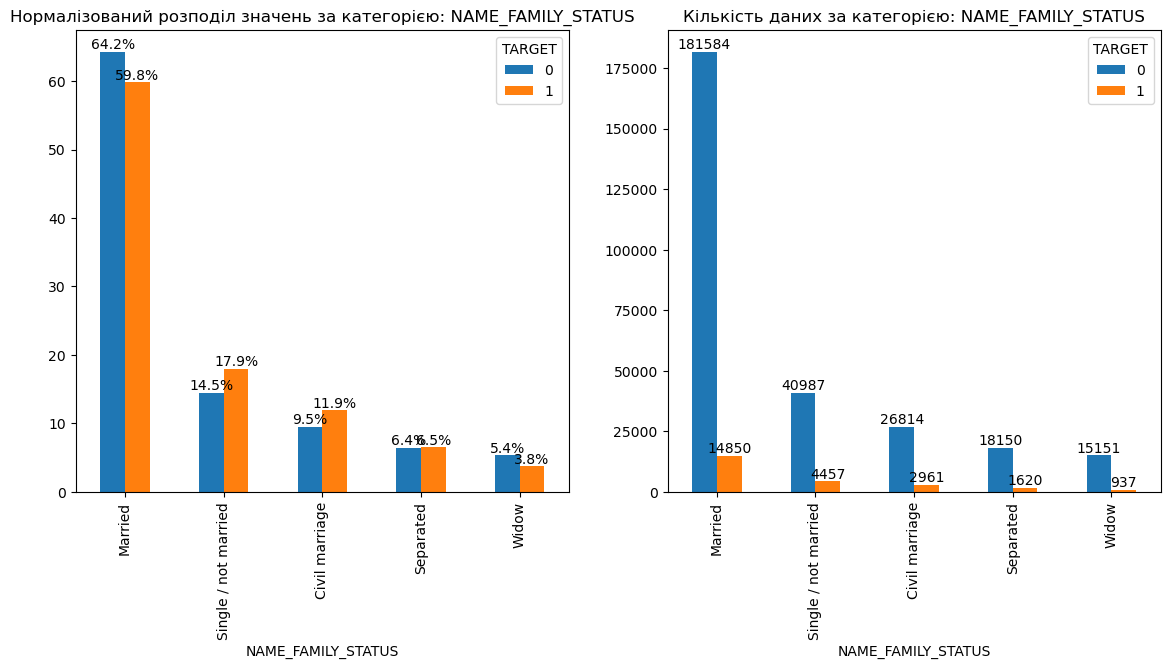

In [225]:
uni_cat_target_compare(df, 'NAME_FAMILY_STATUS') 

**Спостереження**

- Дивлячись на гістограми, Саме одружені клієнти найчастіше беруть кредити і мають найбільший відсоток в проблемах з рахунками, але к-ть клієнтів в іншому статусі значно менша щоб стврерджувати цей факт

**Висновок**
- Колонка `NAME_FAMILY_STATUS` має показник того, що одружені клієнти мають більше проблемних випадків з оплатами, і можна це взяти до уваги при подальшому аналізі, але враховувати, що потрібно більше даних для аналізу цієї категоріі,

# Кореляційний аналіз числових змінних

### Побудова кореляційної матриці для випадків із платіжними труднощами

In [226]:
df1.select_dtypes(include='number').shape

(24825, 68)

Є 67 числових стовпчиків. Створимо кореляційну матрицб `corr` для кращого перегляду результатів

In [227]:
corr_df1 = df1.select_dtypes(include='number').corr()

In [228]:
corr_df1.head()

TARGET  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
TARGET               NaN           NaN              NaN           NaN   
FLAG_OWN_CAR         NaN          1.00             0.02          0.07   
FLAG_OWN_REALTY      NaN          0.02             1.00          0.02   
CNT_CHILDREN         NaN          0.07             0.02          1.00   
AMT_INCOME_TOTAL     NaN          0.02             0.01          0.00   

                  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
TARGET                         NaN         NaN          NaN              NaN   
FLAG_OWN_CAR                  0.02        0.10         0.14             0.10   
FLAG_OWN_REALTY               0.01       -0.01         0.00            -0.02   
CNT_CHILDREN                  0.00       -0.00         0.03            -0.01   
AMT_INCOME_TOTAL              1.00        0.04         0.05             0.04   

                  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
TARGET                                   NaN         NaN            NaN   
FLAG_OWN_CAR                            0.03       -0.07          -0.11   
FLAG_OWN_REALTY                         0.03        0.11           0.06   
CNT_CHILDREN                           -0.03       -0.26          -0.19   
AMT_INCOME_TOTAL                        0.01       -0.00          -0.01   

                  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
TARGET                          NaN              NaN         NaN   
FLAG_OWN_CAR                  -0.07             0.02         NaN   
FLAG_OWN_REALTY                0.01            -0.02         NaN   
CNT_CHILDREN                  -0.15             0.03         NaN   
AMT_INCOME_TOTAL              -0.00             0.00         NaN   

                  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
TARGET                       NaN              NaN               NaN   
FLAG_OWN_CAR                0.11            -0.02              0.00   
FLAG_OWN_REALTY            -0.06            -0.14             -0.01   
CNT_CHILDREN                0.19             0.05              0.00   
AMT_INCOME_TOTAL            0.01            -0.01             -0.00   

                  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
TARGET                   NaN         NaN              NaN   
FLAG_OWN_CAR           -0.00        0.03             0.11   
FLAG_OWN_REALTY        -0.05        0.03             0.03   
CNT_CHILDREN           -0.02        0.01             0.89   
AMT_INCOME_TOTAL       -0.00        0.01             0.01   

                  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
TARGET                             NaN                          NaN   
FLAG_OWN_CAR                     -0.01                        -0.01   
FLAG_OWN_REALTY                  -0.01                        -0.01   
CNT_CHILDREN                      0.04                         0.04   
AMT_INCOME_TOTAL                 -0.02                        -0.02   

                  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
TARGET                                NaN                         NaN   
FLAG_OWN_CAR                         0.01                       -0.00   
FLAG_OWN_REALTY                     -0.12                       -0.05   
CNT_CHILDREN                        -0.02                       -0.02   
AMT_INCOME_TOTAL                     0.01                        0.01   

                  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
TARGET                                   NaN                          NaN   
FLAG_OWN_CAR                            0.02                         0.02   
FLAG_OWN_REALTY                        -0.04                        -0.02   
CNT_CHILDREN                           -0.02                        -0.01   
AMT_INCOME_TOTAL                        0.01                         0.01   

                  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
TARGET                               NaN       

Перегляд повної кореляційної матриці

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


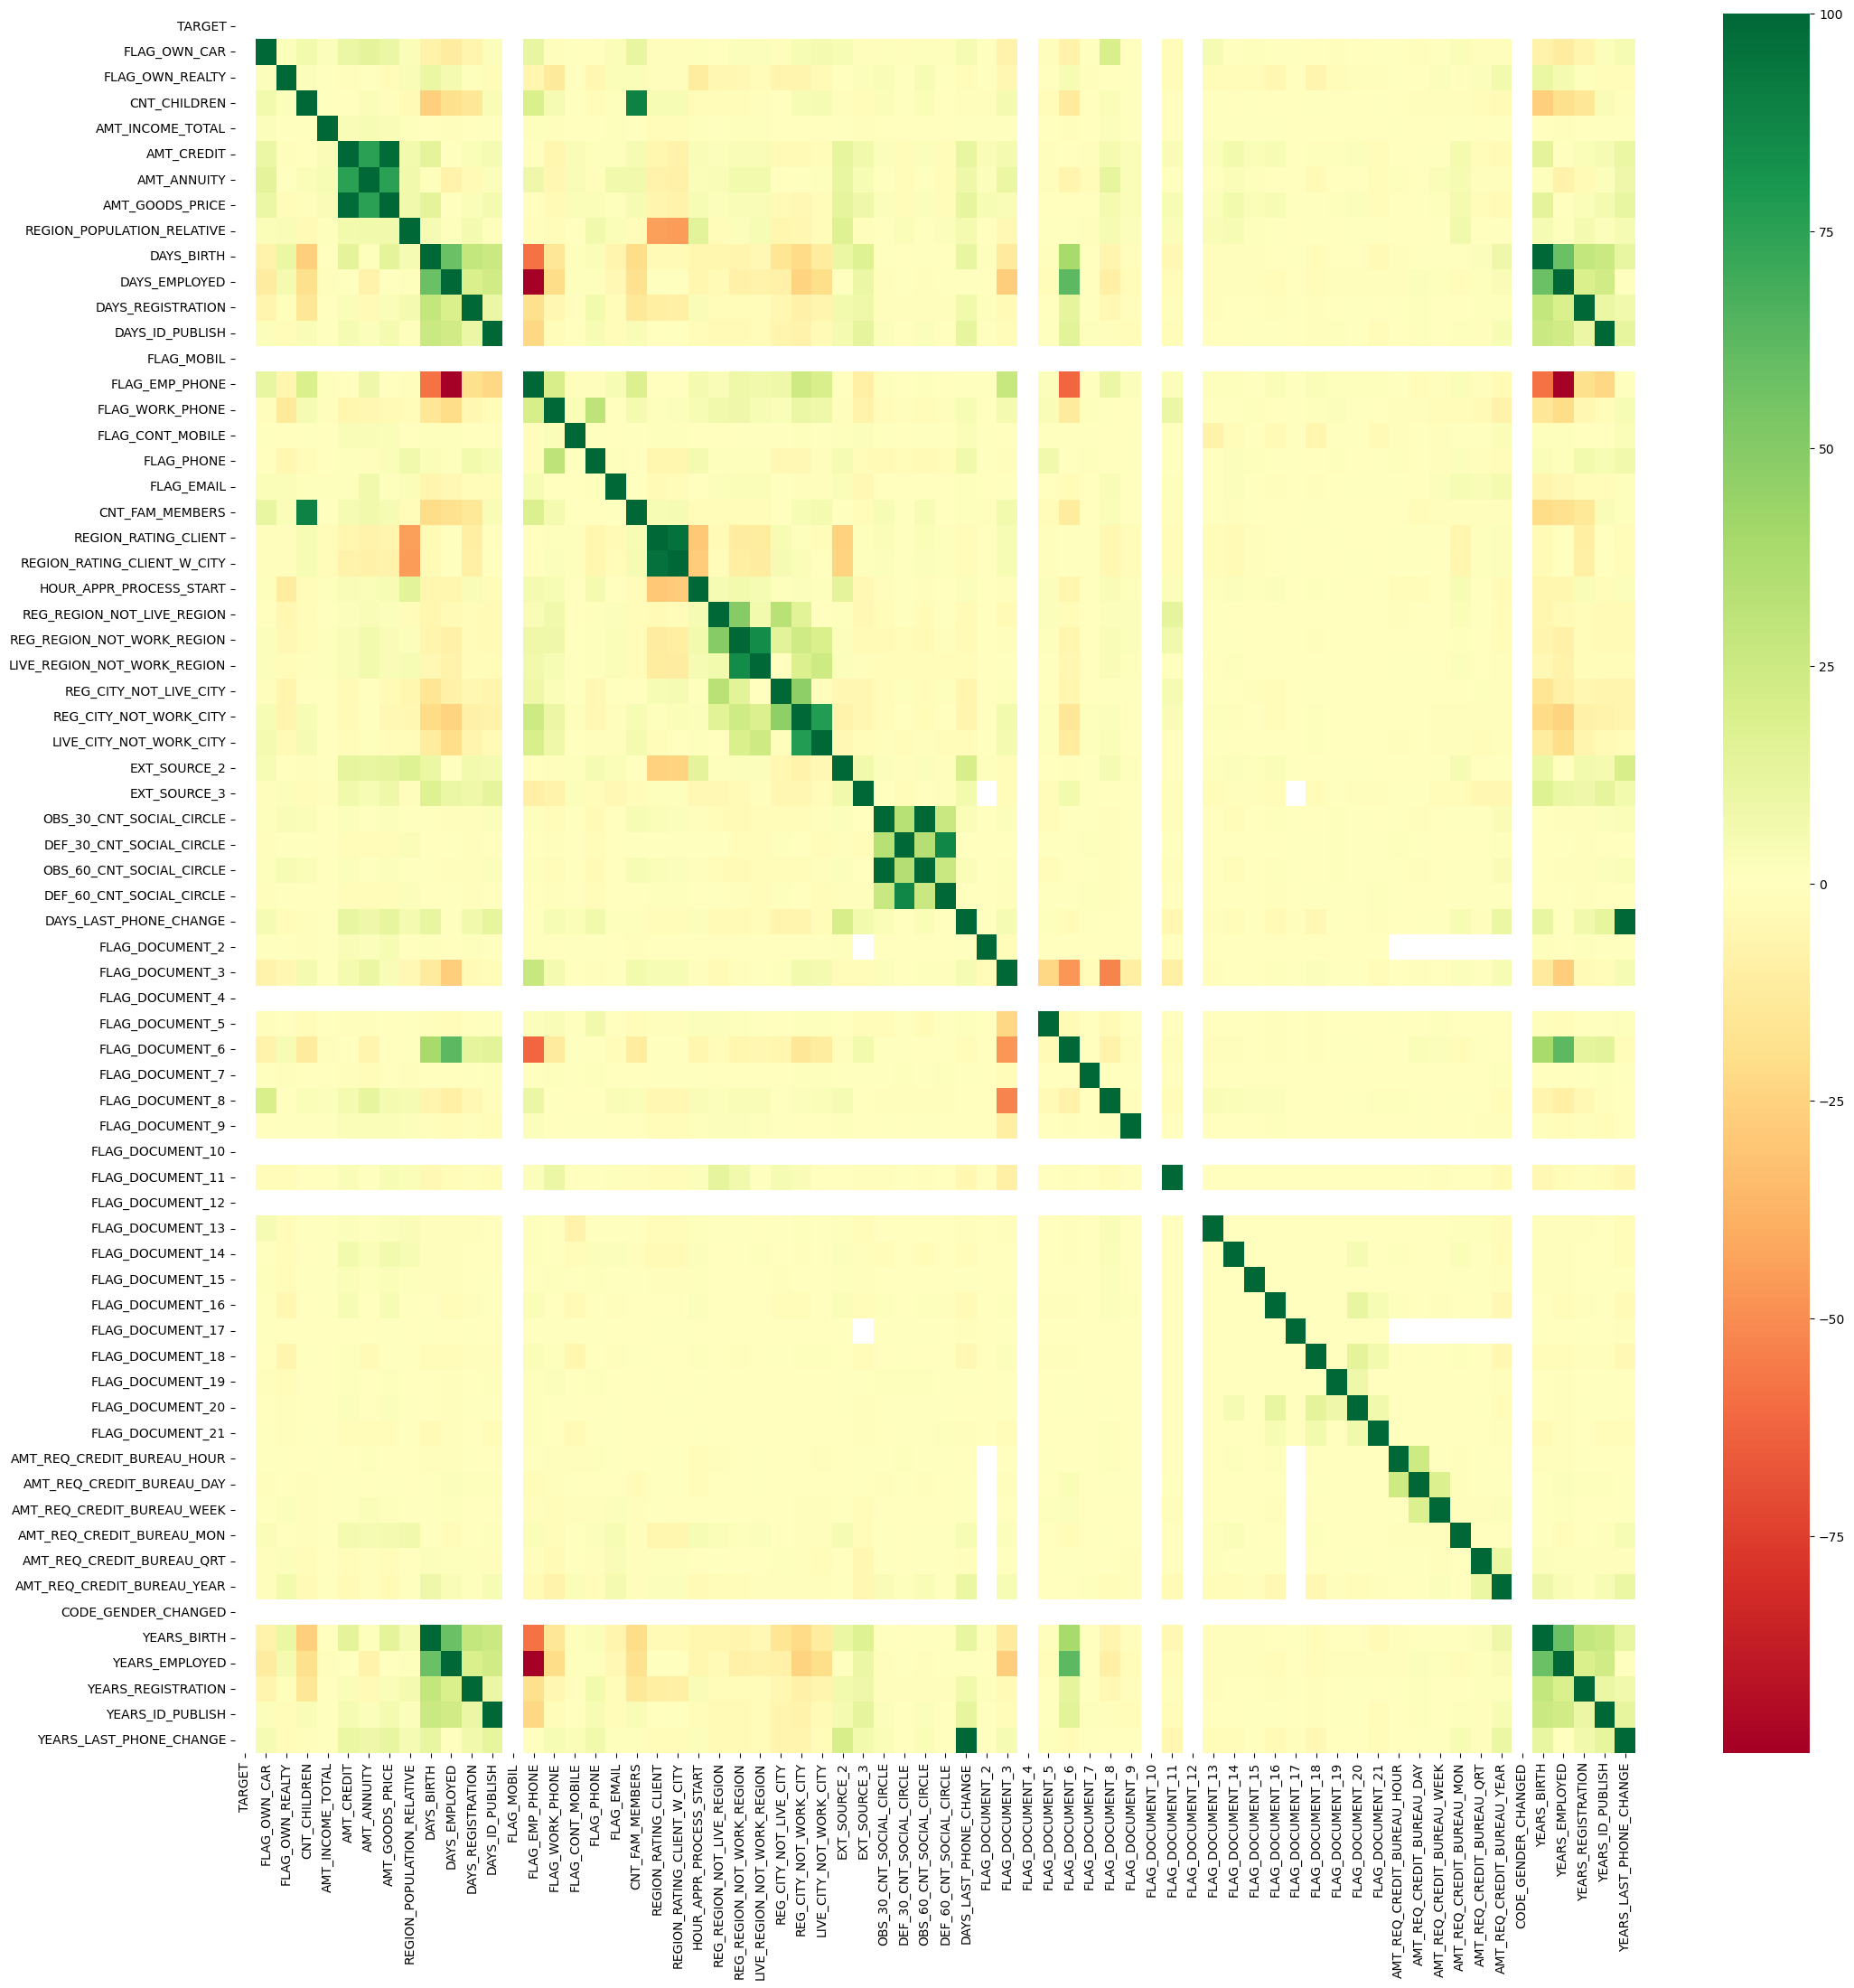

In [229]:
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df1*100, annot = True, cmap = "RdYlGn", cbar = True, fmt='.0f')
plt.show()

Створимо теплову карту для перегляду кореляцій вище 80% і 99,99%

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


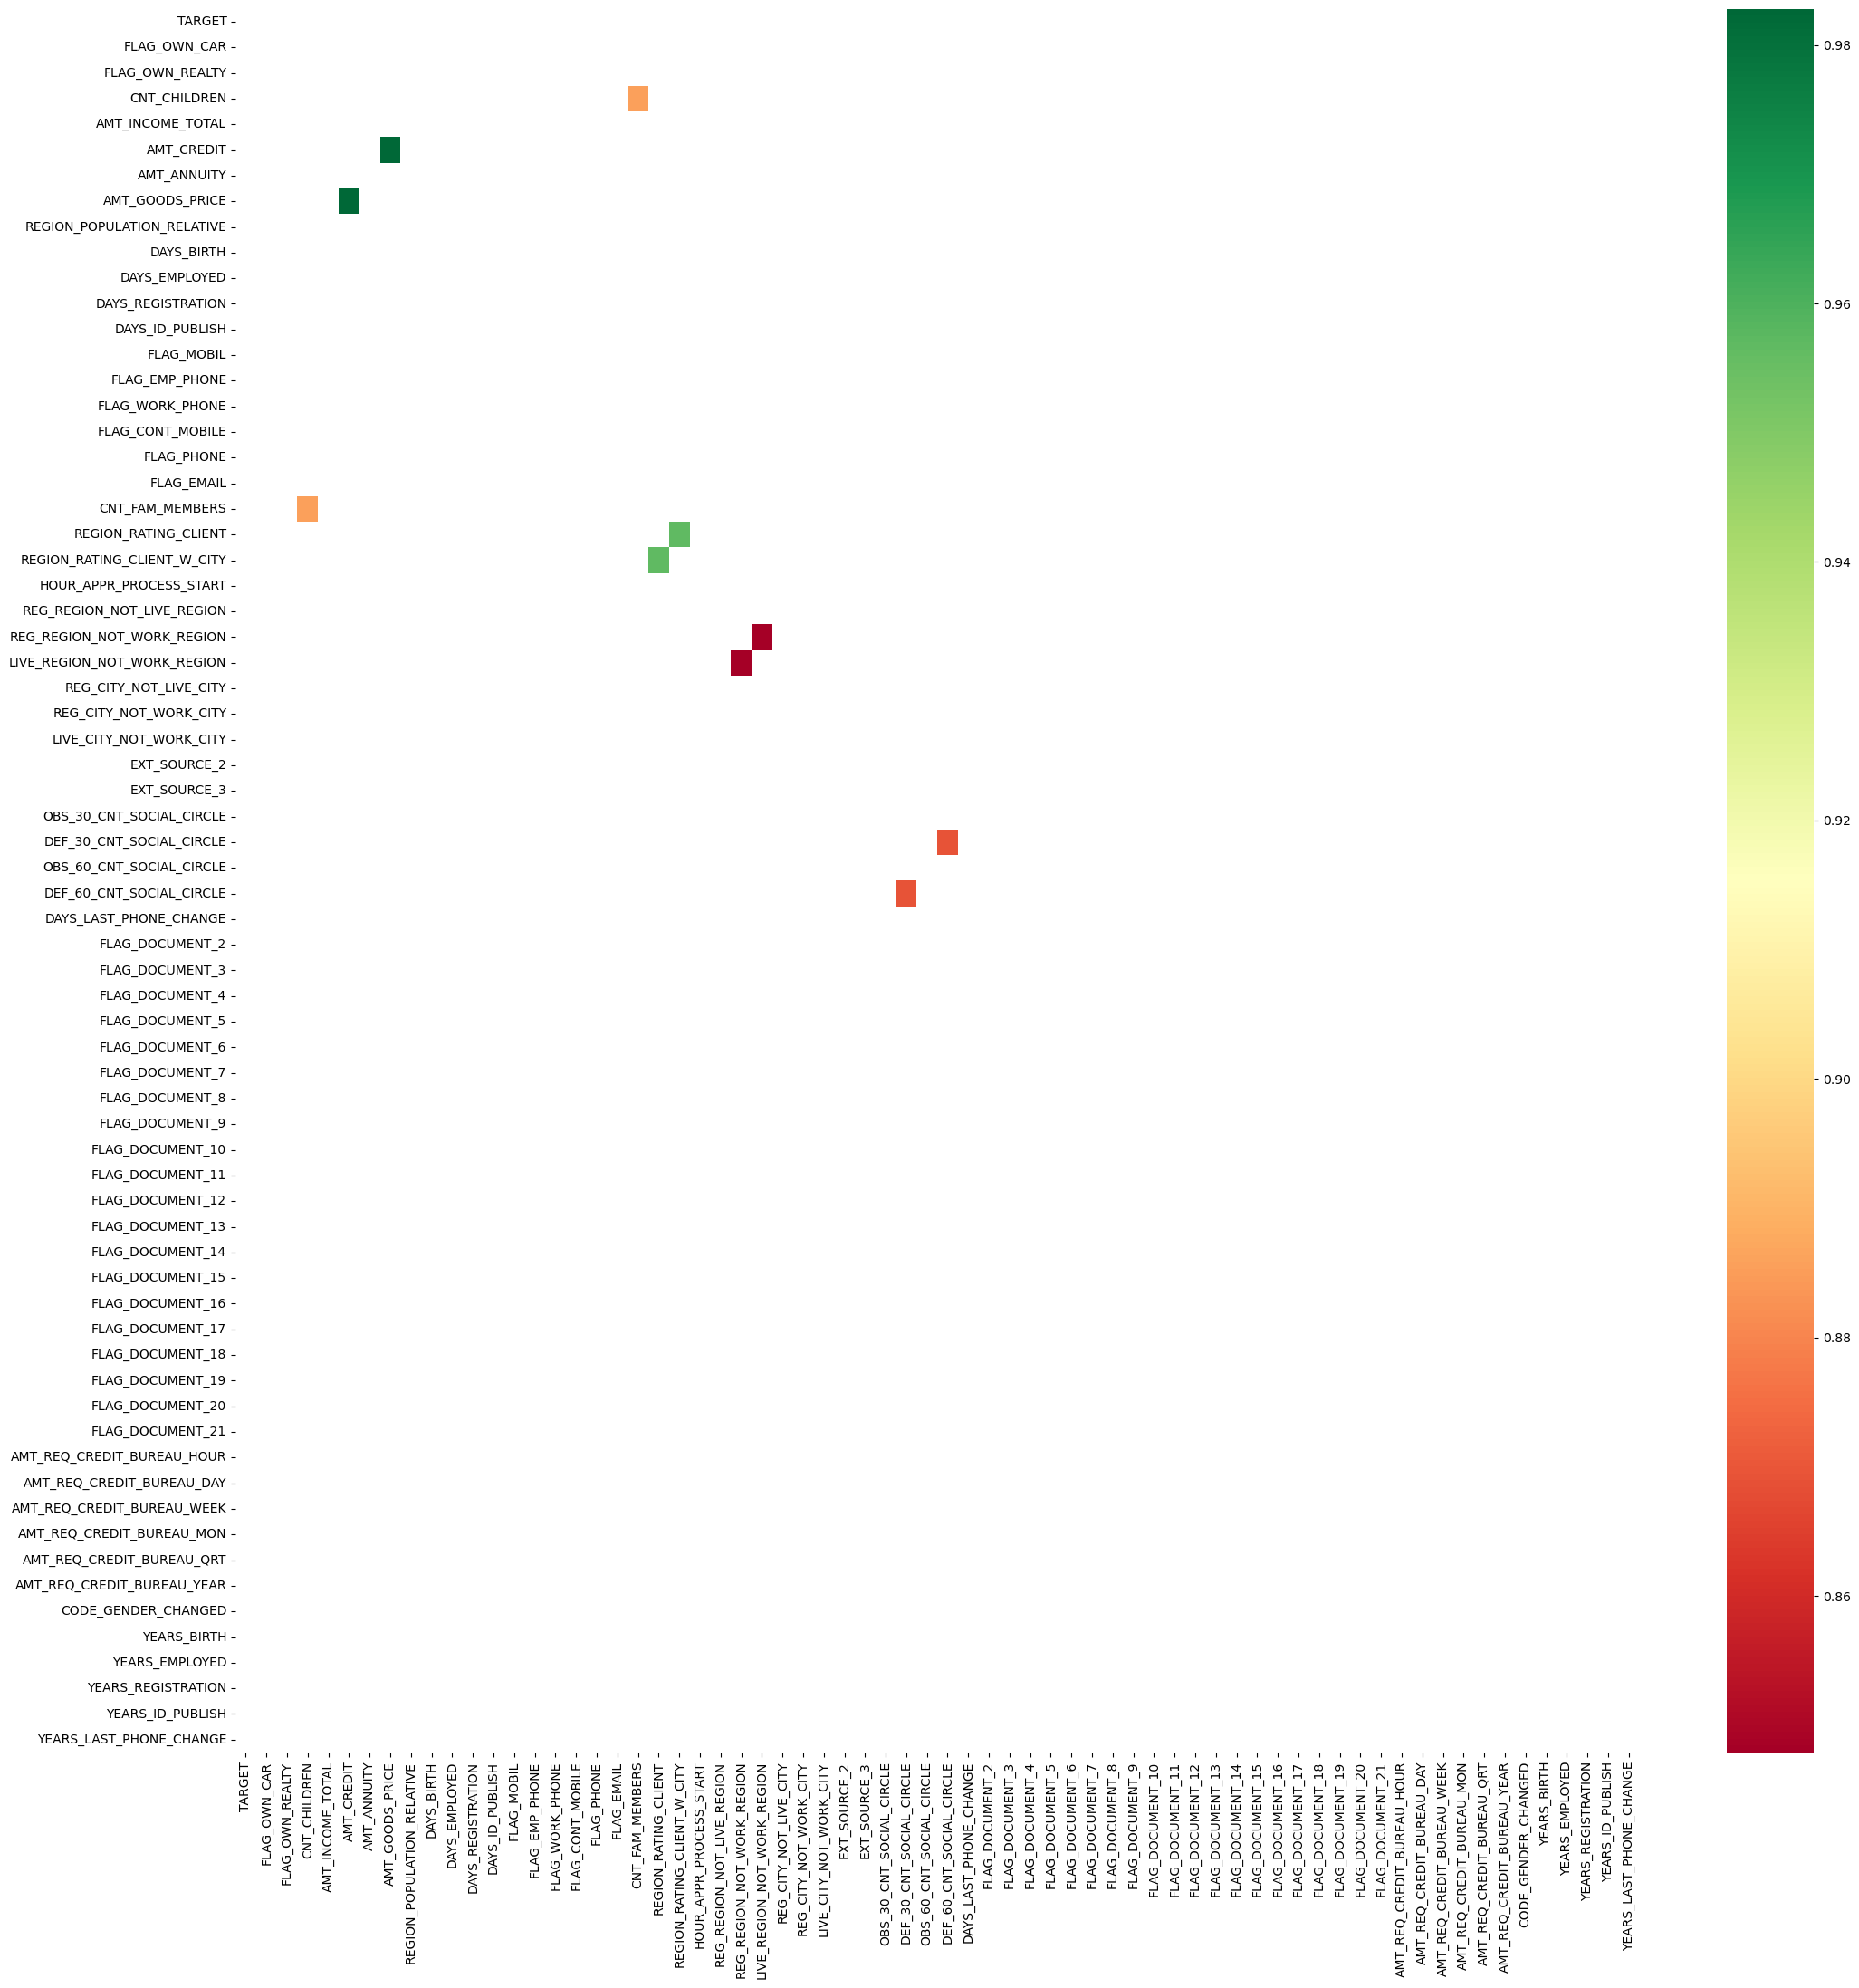

In [230]:
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df1[(corr_df1 >= 0.8) & (corr_df1 < 0.99)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()

### Подивимось на 10 найкращих кореляцій для випадків із платіжними труднощами

In [231]:
corr_df1[corr_df1 <= 0.99].unstack().sort_values(ascending = False).head(22)

AMT_CREDIT                   AMT_GOODS_PRICE               0.98
AMT_GOODS_PRICE              AMT_CREDIT                    0.98
REGION_RATING_CLIENT         REGION_RATING_CLIENT_W_CITY   0.96
REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT          0.96
CNT_CHILDREN                 CNT_FAM_MEMBERS               0.89
CNT_FAM_MEMBERS              CNT_CHILDREN                  0.89
DEF_30_CNT_SOCIAL_CIRCLE     DEF_60_CNT_SOCIAL_CIRCLE      0.87
DEF_60_CNT_SOCIAL_CIRCLE     DEF_30_CNT_SOCIAL_CIRCLE      0.87
LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION    0.85
REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION   0.85
REG_CITY_NOT_WORK_CITY       LIVE_CITY_NOT_WORK_CITY       0.78
LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.78
AMT_GOODS_PRICE              AMT_ANNUITY                   0.75
AMT_ANNUITY                  AMT_GOODS_PRICE               0.75
                             AMT_CREDIT                    0.75
AMT_CREDIT                   AMT_ANNUITY

Оскільки у нас є комбінації, що повторюються, дивлячись на наведену вище таблицю і видаляючи дублі, ми отримуємо топ-10 кореляцій, як показано нижче:

- AMT_GOODS_PRICE -              AMT_CREDIT                    0.98
- REGION_RATING_CLIENT -         REGION_RATING_CLIENT_W_CITY   0.96
- CNT_FAM_MEMBERS -              CNT_CHILDREN                  0.89
- DEF_60_CNT_SOCIAL_CIRCLE -     DEF_30_CNT_SOCIAL_CIRCLE      0.87
- REG_REGION_NOT_WORK_REGION -   LIVE_REGION_NOT_WORK_REGION   0.85
- LIVE_CITY_NOT_WORK_CITY -      REG_CITY_NOT_WORK_CITY        0.78
- AMT_ANNUITY -                  AMT_GOODS_PRICE               0.75
- AMT_ANNUITY -                  AMT_CREDIT                    0.75
- DAYS_EMPLOYED -                FLAG_DOCUMENT_6               0.62
- DAYS_BIRTH -                   DAYS_EMPLOYED                 0.58

### Побудова кореляційної матриці для випадків із вчасними платежеми

In [232]:
df0.select_dtypes(include='number').shape

(282686, 68)

Є 68 числових стовпчиків. Створимо кореляційну матрицю `corr` для кращого перегляду результатів

In [234]:
corr_df0 = df0.select_dtypes(include='number').corr()

In [235]:
corr_df0.head()

TARGET  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
TARGET               NaN           NaN              NaN           NaN   
FLAG_OWN_CAR         NaN          1.00            -0.01          0.11   
FLAG_OWN_REALTY      NaN         -0.01             1.00         -0.00   
CNT_CHILDREN         NaN          0.11            -0.00          1.00   
AMT_INCOME_TOTAL     NaN          0.18             0.00          0.03   

                  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
TARGET                         NaN         NaN          NaN              NaN   
FLAG_OWN_CAR                  0.18        0.12         0.14             0.12   
FLAG_OWN_REALTY               0.00       -0.04        -0.01            -0.05   
CNT_CHILDREN                  0.03        0.00         0.02            -0.00   
AMT_INCOME_TOTAL              1.00        0.34         0.42             0.35   

                  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
TARGET                                   NaN         NaN            NaN   
FLAG_OWN_CAR                            0.04       -0.14          -0.16   
FLAG_OWN_REALTY                         0.01        0.12           0.07   
CNT_CHILDREN                           -0.02       -0.34          -0.25   
AMT_INCOME_TOTAL                        0.17       -0.06          -0.14   

                  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
TARGET                          NaN              NaN         NaN   
FLAG_OWN_CAR                  -0.09            -0.02       -0.00   
FLAG_OWN_REALTY                0.03            -0.01       -0.00   
CNT_CHILDREN                  -0.19             0.03        0.00   
AMT_INCOME_TOTAL              -0.06            -0.02        0.00   

                  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
TARGET                       NaN              NaN               NaN   
FLAG_OWN_CAR                0.16             0.01             -0.01   
FLAG_OWN_REALTY            -0.07            -0.11              0.01   
CNT_CHILDREN                0.24             0.06             -0.00   
AMT_INCOME_TOTAL            0.14            -0.03             -0.02   

                  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
TARGET                   NaN         NaN              NaN   
FLAG_OWN_CAR           -0.01        0.03             0.15   
FLAG_OWN_REALTY        -0.04        0.03             0.01   
CNT_CHILDREN           -0.03        0.02             0.88   
AMT_INCOME_TOTAL        0.00        0.08             0.03   

                  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
TARGET                             NaN                          NaN   
FLAG_OWN_CAR                     -0.02                        -0.02   
FLAG_OWN_REALTY                   0.00                         0.00   
CNT_CHILDREN                      0.02                         0.02   
AMT_INCOME_TOTAL                 -0.19                        -0.20   

                  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
TARGET                                NaN                         NaN   
FLAG_OWN_CAR                         0.01                       -0.00   
FLAG_OWN_REALTY                     -0.10                       -0.03   
CNT_CHILDREN                        -0.01                       -0.01   
AMT_INCOME_TOTAL                     0.08                        0.07   

                  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
TARGET                                   NaN                          NaN   
FLAG_OWN_CAR                            0.04                         0.05   
FLAG_OWN_REALTY                        -0.03                        -0.02   
CNT_CHILDREN                            0.01                         0.02   
AMT_INCOME_TOTAL                        0.14                         0.13   

                  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
TARGET                               NaN       

Створимо теплову карту для перегляду кореляцій вище 80% і 99,99%

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


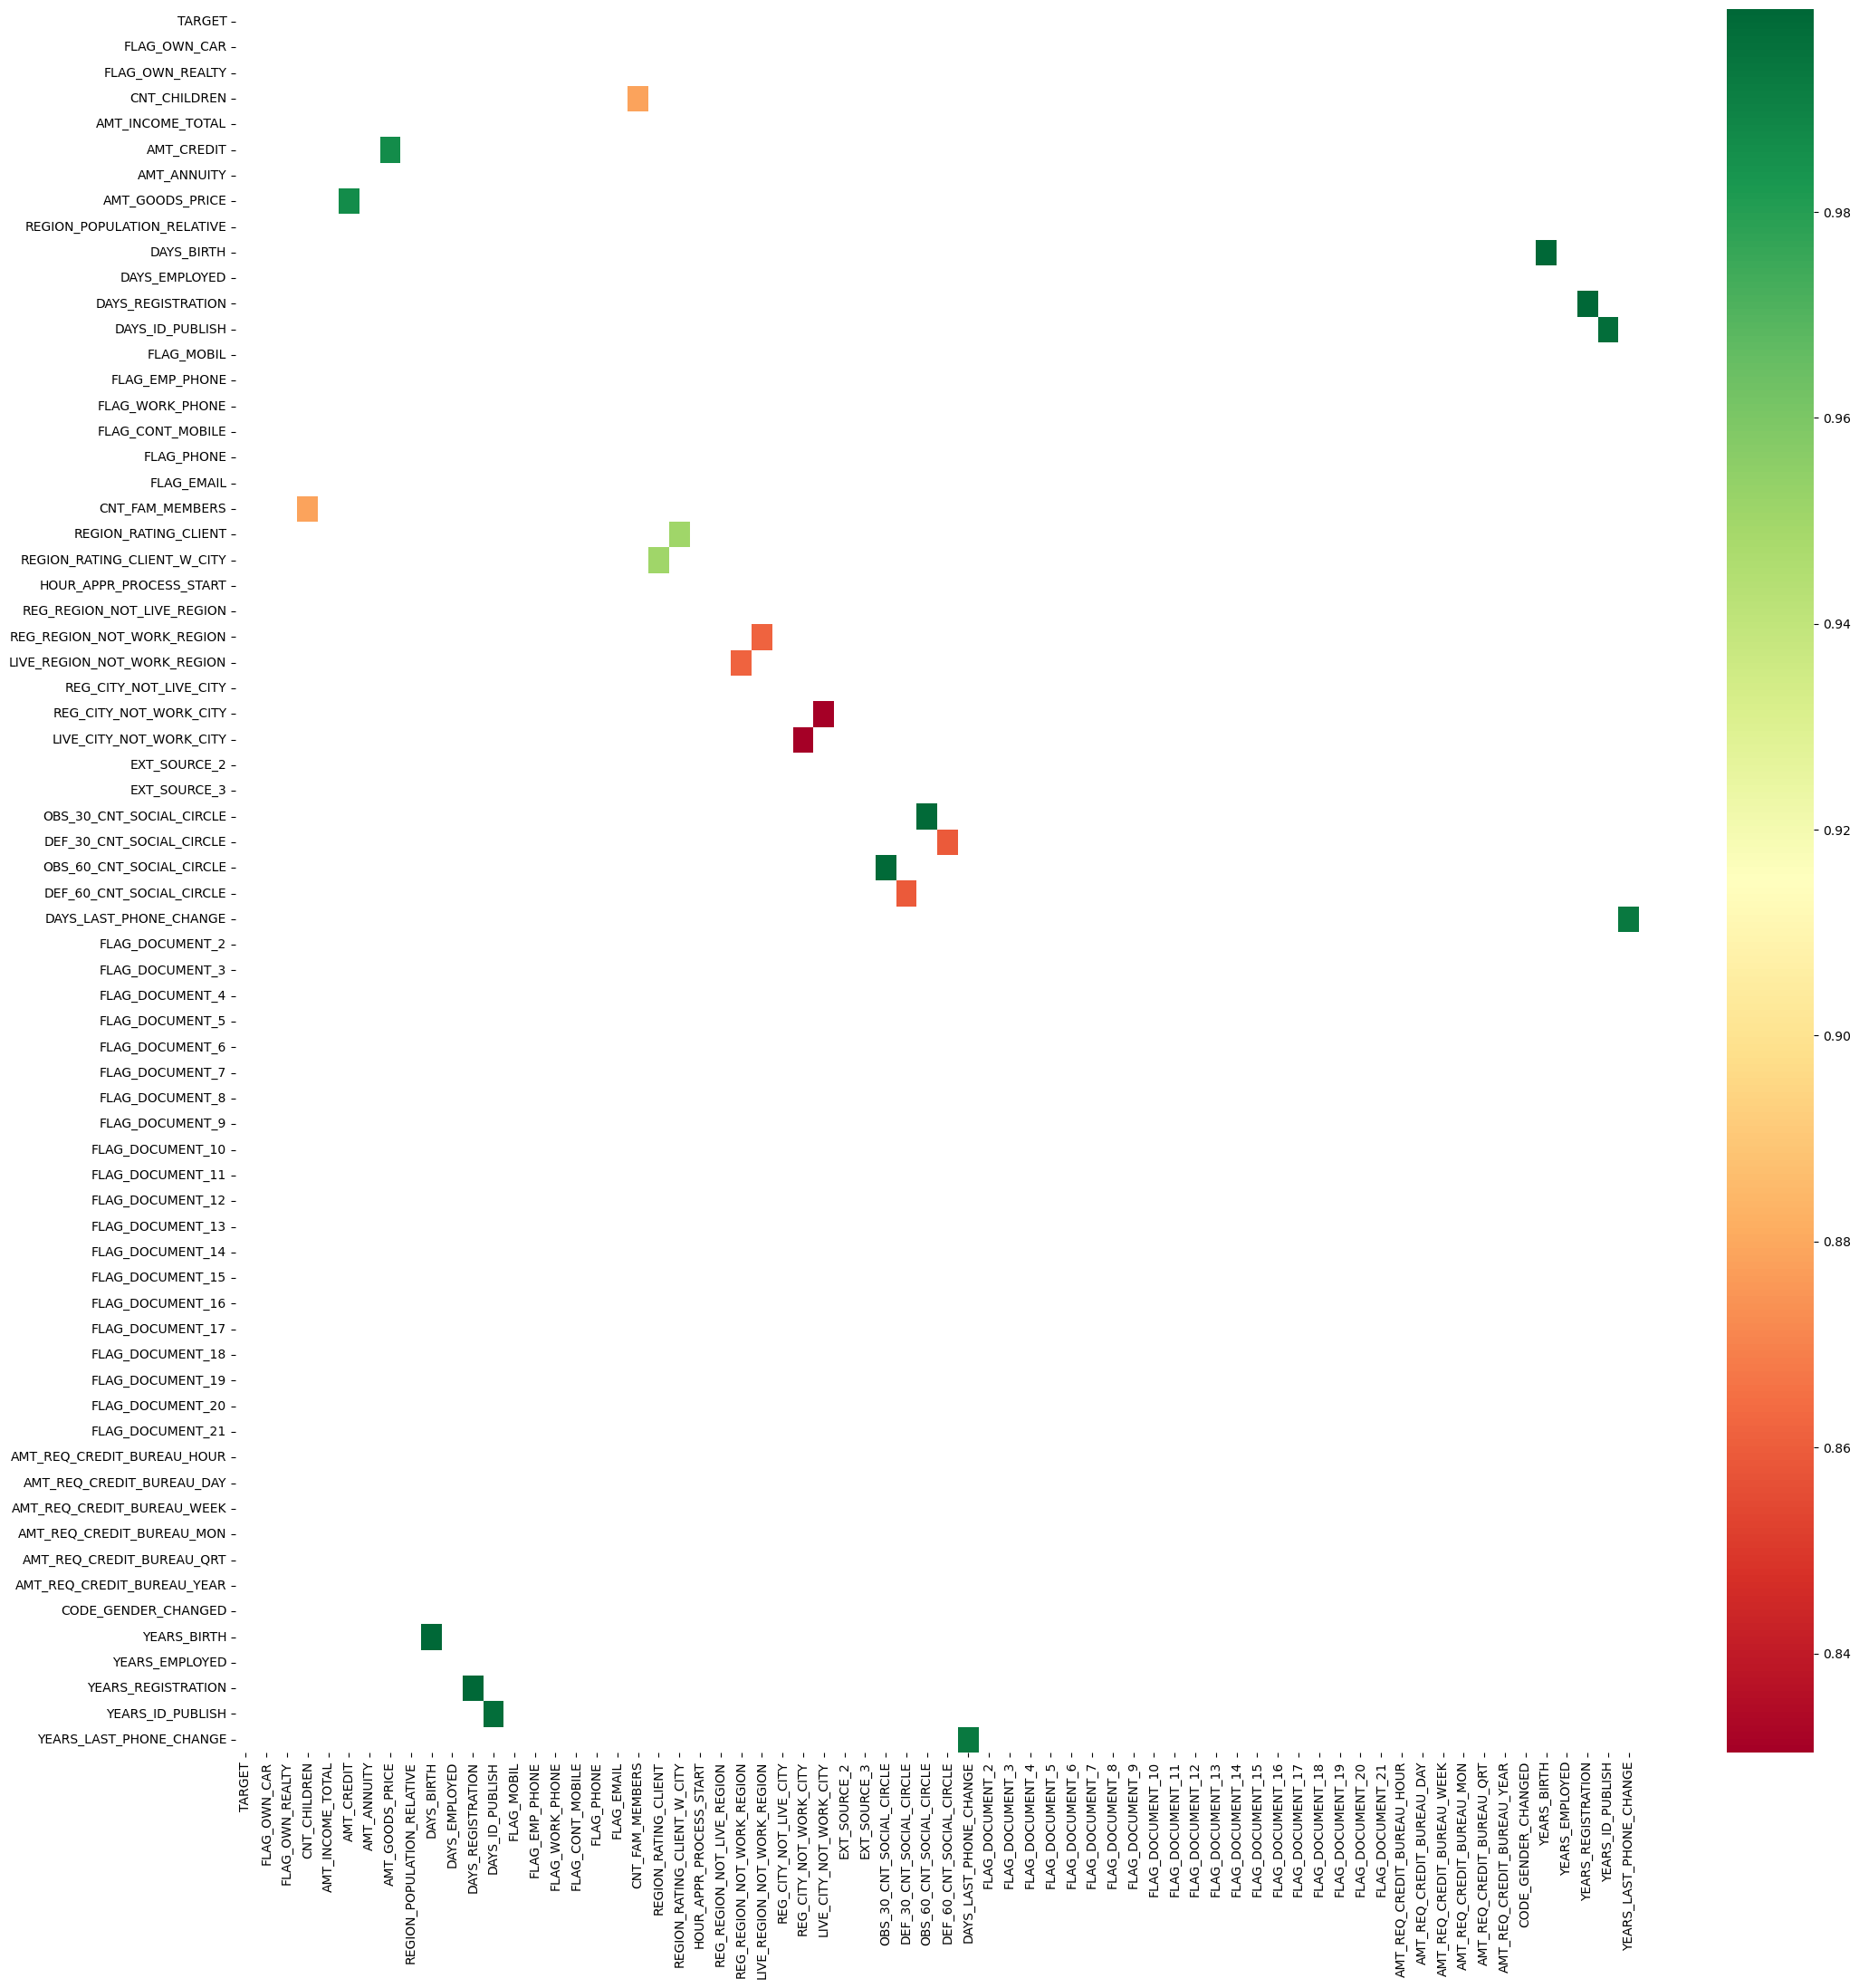

In [236]:
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df0[(corr_df0 >= 0.8) & (corr_df0 < 0.9999)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()

### Подивимось на 10 найкращих кореляцій для вчасних платежів

In [237]:
corr_df0[corr_df0 <= 0.99].unstack().sort_values(ascending = False).head(28)

AMT_CREDIT                   AMT_GOODS_PRICE               0.99
AMT_GOODS_PRICE              AMT_CREDIT                    0.99
REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT          0.95
REGION_RATING_CLIENT         REGION_RATING_CLIENT_W_CITY   0.95
CNT_CHILDREN                 CNT_FAM_MEMBERS               0.88
CNT_FAM_MEMBERS              CNT_CHILDREN                  0.88
REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION   0.86
LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION    0.86
DEF_60_CNT_SOCIAL_CIRCLE     DEF_30_CNT_SOCIAL_CIRCLE      0.86
DEF_30_CNT_SOCIAL_CIRCLE     DEF_60_CNT_SOCIAL_CIRCLE      0.86
REG_CITY_NOT_WORK_CITY       LIVE_CITY_NOT_WORK_CITY       0.83
LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.83
AMT_GOODS_PRICE              AMT_ANNUITY                   0.78
AMT_ANNUITY                  AMT_GOODS_PRICE               0.78
AMT_CREDIT                   AMT_ANNUITY                   0.77
AMT_ANNUITY                  AMT_CREDIT 

Оскільки у нас є комбінації, що повторюються, дивлячись на наведену вище таблицю і видаляючи дублі, ми отримуємо топ-10 кореляцій, як показано нижче:

- AMT_GOODS_PRICE              AMT_CREDIT                    0.99
- REGION_RATING_CLIENT         REGION_RATING_CLIENT_W_CITY   0.95
- CNT_FAM_MEMBERS              CNT_CHILDREN                  0.88
- REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION   0.86
- DEF_30_CNT_SOCIAL_CIRCLE     DEF_60_CNT_SOCIAL_CIRCLE      0.86
- LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.83
- AMT_ANNUITY                  AMT_GOODS_PRICE               0.78
- AMT_ANNUITY                  AMT_CREDIT                    0.77
- DAYS_BIRTH                   DAYS_EMPLOYED                 0.63
- DAYS_EMPLOYED                FLAG_DOCUMENT_6               0.60

### Порівняємо 10 найкращих кореляцій між випадками із платіжними труднощами та вчасними платежами

**Спостереження**

- Топ-10 кореляцій для Труднощів з оплатою та Вчасних платежів однакові, за винятком незначних відмінностей у відсотках кореляції
- Найвища кореляція для комбінації `AMT_GOODS_PRICE` та `AMT_CREDIT`.
- Для набору даних "Труднощі з оплатою" кореляція між `AMT_GOODS_PRICE` та `AMT_CREDIT` становить 0,98
- Для набору даних "Вчасні платежі" кореляція між `AMT_GOODS_PRICE` та `AMT_CREDIT` становить 0,99

# Одновимірний аналіз числових змінних

### Аналіз стовпця `AMT_CREDIT`

#### Пошук викидів в `AMT_CREDIT` при випадках із платіжними труднощами

Розрахунок IQR (Inter Quartile range)

In [238]:
Q1 = df1['AMT_CREDIT'].quantile(0.25)
Q3 = df1['AMT_CREDIT'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

448915.5


Значення *до* (Q1 - 1.5 * IQR) та *після* (Q3 + 1.5 * IQR) є викидами.

In [239]:
Min_value1 = (Q1 - 1.5 * IQR)
Max_value1 = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value1))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value1))

Мінімальне значення, до якого існують викиди: -388973.25
Максимальне значення, після якого існують викиди: 1406688.75


#### Пошук викидів в `AMT_CREDIT` при випадках із вчасними оплатами

Розрахунок IQR (Inter Quartile range)

In [240]:
Q1 = df0['AMT_CREDIT'].quantile(0.25)
Q3 = df0['AMT_CREDIT'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

540000.0


Значення *до* (Q1 - 1.5 * IQR) та *після* (Q3 + 1.5 * IQR) є викидами.

In [241]:
Min_value0 = (Q1 - 1.5 * IQR)
Max_value0 = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value0))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value0))

Мінімальне значення, до якого існують викиди: -540000.0
Максимальне значення, після якого існують викиди: 1620000.0


Видалення викидів і побудова діаграми розподілу

In [242]:
def kde_no_outliers(df0, df1, Max_value0, Max_value1, column):
  plt.figure(figsize = (14,6))
  sns.kdeplot(df1[df1[column] <= Max_value1][column],label = 'Payment difficulties')
  sns.kdeplot(df0[df0[column] <= Max_value0][column],label = 'On-Time Payments')
  plt.ticklabel_format(style='plain', axis='x')
  plt.xticks(rotation = 45)
  plt.legend()
  plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


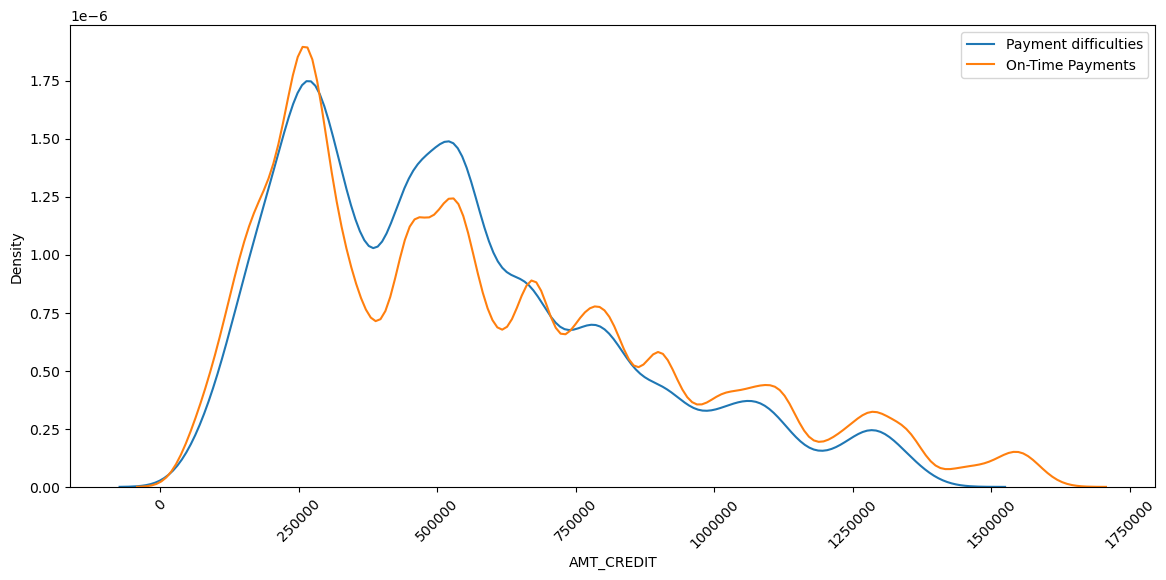

In [243]:
kde_no_outliers(df0, df1, Max_value0, Max_value1, 'AMT_CREDIT')

**Спостереження**

- Для `AMT_CREDIT` від 250000 до приблизно 650000 більше клієнтів мають труднощі з оплатою
- Для `AMT_CREDIT` > 750000 більше клієнтів, які вчасно здійснюють платежі

# ДЗ 5. Одновимірний аналіз числової колонки

 Проведіть подібний до прикладу одновимірний аналіз (виявлення викидів, їх усунення та побудова KDE  графіку) для числових змінних
- `YEARS_BIRTH`
- `AMT_GOODS_PRICE`
- `DAYS_EMPLOYED`

Опціонально
- `CNT_CHILDREN`
- `AMT_INCOME_TOTAL`

Для цього винесіть функціонал для аналізу у функцію та викличіть функцію для кожної двійки змінних.

Зробіть висновки з аналізу.

In [244]:
#Створимо функцію для аналізу значень викидів 
def IQR_max_value(column):
    Q1 = df1[column].quantile(0.25)
    Q3 = df1[column].quantile(0.75)
    IQR = Q3 - Q1
    print(IQR)
    Min_value1 = (Q1 - 1.5 * IQR)
    Max_value1 = (Q3 + 1.5 * IQR)
    print("Мінімальне значення, до якого існують викиди: {}".format(Min_value1))
    print("Максимальне значення, після якого існують викиди: {}".format(Max_value1))
    Q1 = df0[column].quantile(0.25)
    Q3 = df0[column].quantile(0.75)
    IQR = Q3 - Q1
    print(IQR)
    Min_value0 = (Q1 - 1.5 * IQR)
    Max_value0 = (Q3 + 1.5 * IQR)
    print("Мінімальне значення, до якого існують викиди: {}".format(Min_value0))
    print("Максимальне значення, після якого існують викиди: {}".format(Max_value0))

    return Max_value0, Max_value1

### Аналіз стовпця - YEARS_BIRTH


Визначимо викиди для обмеження та побудуємо графік для аналізу 

In [245]:
Max_value0, Max_value1 = IQR_max_value('YEARS_BIRTH')

18.0
Мінімальне значення, до якого існують викиди: 4.0
Максимальне значення, після якого існують викиди: 76.0
20.0
Мінімальне значення, до якого існують викиди: 4.0
Максимальне значення, після якого існують викиди: 84.0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


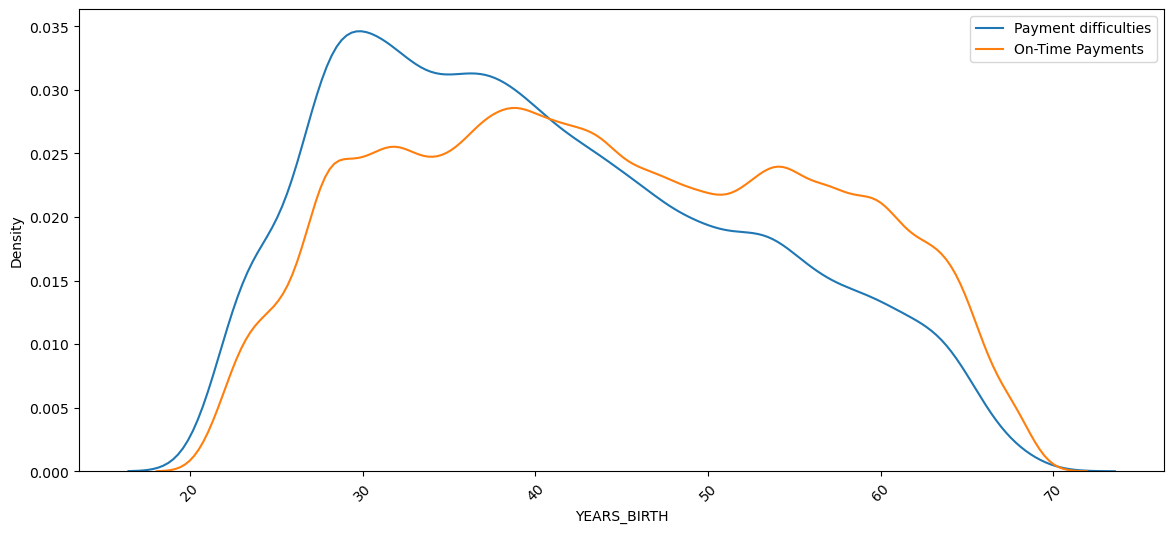

In [246]:
kde_no_outliers(df0, df1, Max_value0, Max_value1, 'YEARS_BIRTH')

**Спостереження**

- Для `YEARS_BIRTH`, більше клієнтів до 41 року, мають труднощі з оплатою
- Для `YEARS_BIRTH` > 41 більше клієнтів, які вчасно здійснюють платежі

### Аналіз стовпця `AMT_GOODS_PRICE`

In [247]:
Max_value0, Max_value1 = IQR_max_value('AMT_GOODS_PRICE')

436500.0
Мінімальне значення, до якого існують викиди: -416250.0
Максимальне значення, після якого існують викиди: 1329750.0
446502.375
Мінімальне значення, до якого існують викиди: -431253.5625
Максимальне значення, після якого існують викиди: 1354755.9375


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


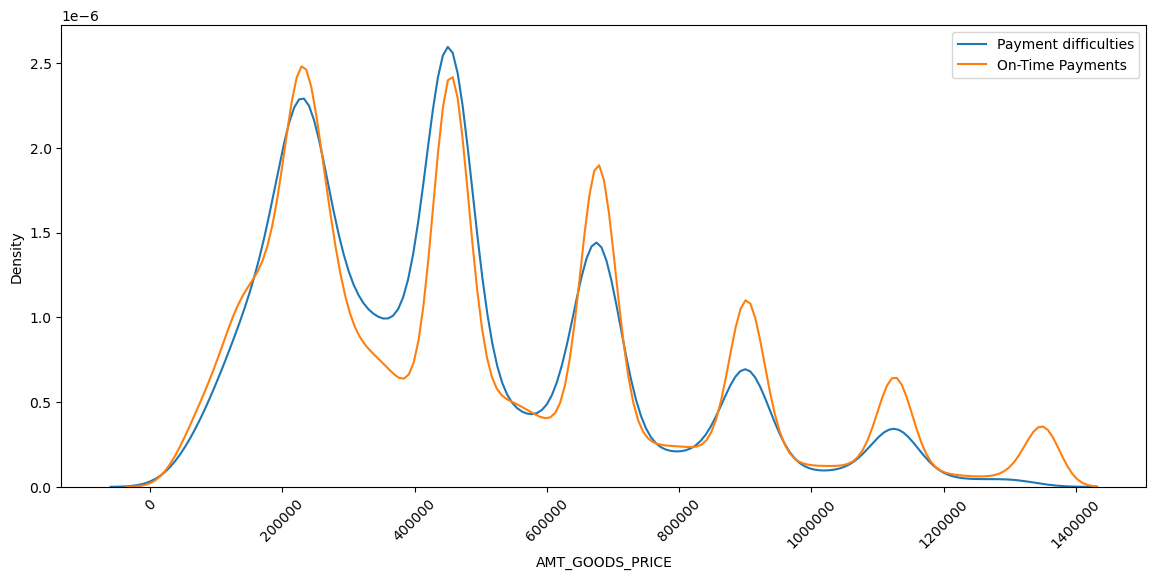

In [248]:
kde_no_outliers(df0, df1, Max_value0, Max_value1, 'AMT_GOODS_PRICE')

**Спостереження**

- Для `AMT_GOODS_PRICE` від 280000 до приблизно 630000 більше клієнтів мають труднощі з оплатою
- Для `AMT_GOODS_PRICE` до 280000 від приблизно 630000 більше клієнтів, які вчасно здійснюють платежі

### Аналіз стовпця `DAYS_EMPLOYED`

In [249]:
#Для полекшення аналізу ми можемо використати колонку, яку створили раніше де дні перетворили в роки 
Max_value0, Max_value1 = IQR_max_value('YEARS_EMPLOYED')

7.0
Мінімальне значення, до якого існують викиди: -8.5
Максимальне значення, після якого існують викиди: 19.5
14.0
Мінімальне значення, до якого існують викиди: -18.0
Максимальне значення, після якого існують викиди: 38.0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


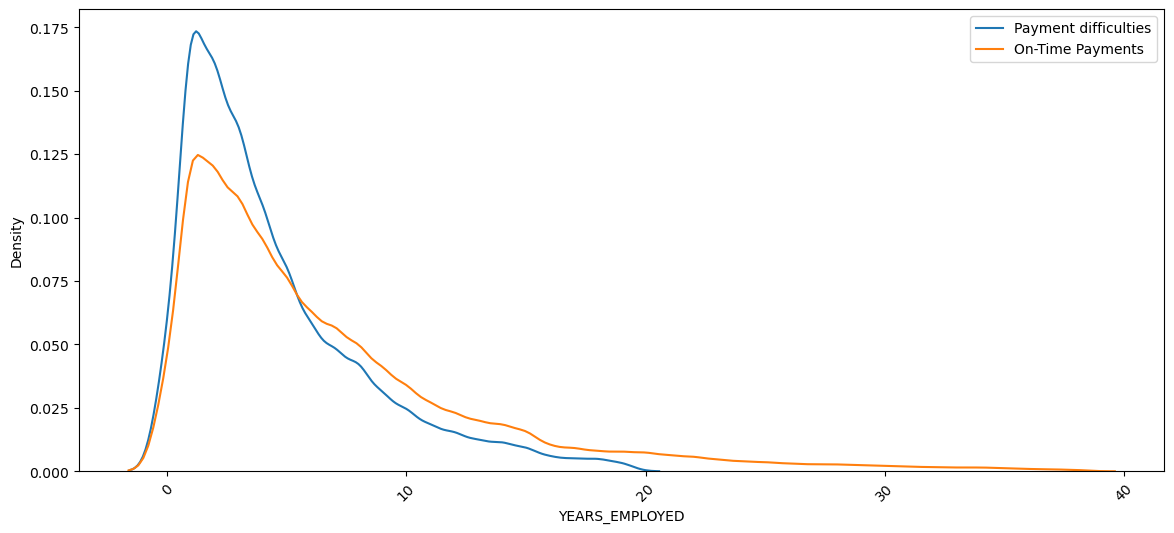

In [250]:
kde_no_outliers(df0, df1, Max_value0, Max_value1, 'YEARS_EMPLOYED')

**Спостереження**

- Для `YEARS_EMPLOYED` до 6-7 років роботи більше клієнтів мають труднощі з оплатою
- Для `YEARS_EMPLOYED` від 7 років роботи більше клієнтів, які вчасно здійснюють платежі

### Аналіз стовпця `CNT_CHILDREN`

In [251]:
Max_value0, Max_value1 = IQR_max_value('CNT_CHILDREN')

1.0
Мінімальне значення, до якого існують викиди: -1.5
Максимальне значення, після якого існують викиди: 2.5
1.0
Мінімальне значення, до якого існують викиди: -1.5
Максимальне значення, після якого існують викиди: 2.5


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


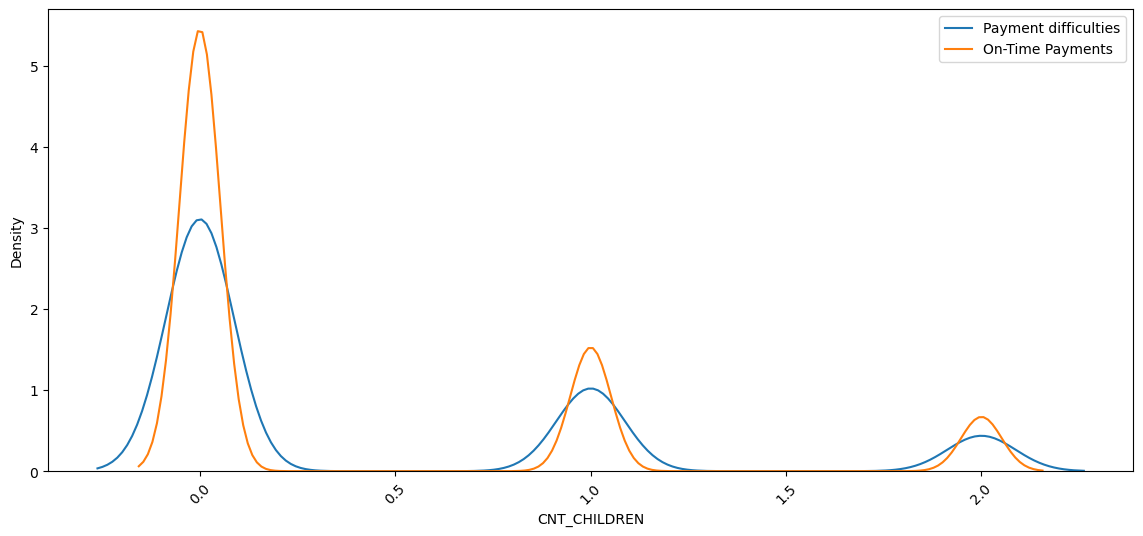

In [252]:
kde_no_outliers(df0, df1, Max_value0, Max_value1, 'CNT_CHILDREN')

**Спостереження**

- Для `CNT_CHILDREN`, клієнти, які не мають дітей мають кращий відсоток вчасно здійснених платежів 
- Для `CNT_CHILDREN`,клієнти, які мають 1-2 дітей мають менший відсоток вчасних оплат, але в цілому к-ть дітей не впливає на труднощі з оплатою

### Аналіз стовпця `AMT_INCOME_TOTAL`

In [253]:
Max_value0, Max_value1 = IQR_max_value('AMT_INCOME_TOTAL')

90000.0
Мінімальне значення, до якого існують викиди: -22500.0
Максимальне значення, після якого існують викиди: 337500.0
90000.0
Мінімальне значення, до якого існують викиди: -22500.0
Максимальне значення, після якого існують викиди: 337500.0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


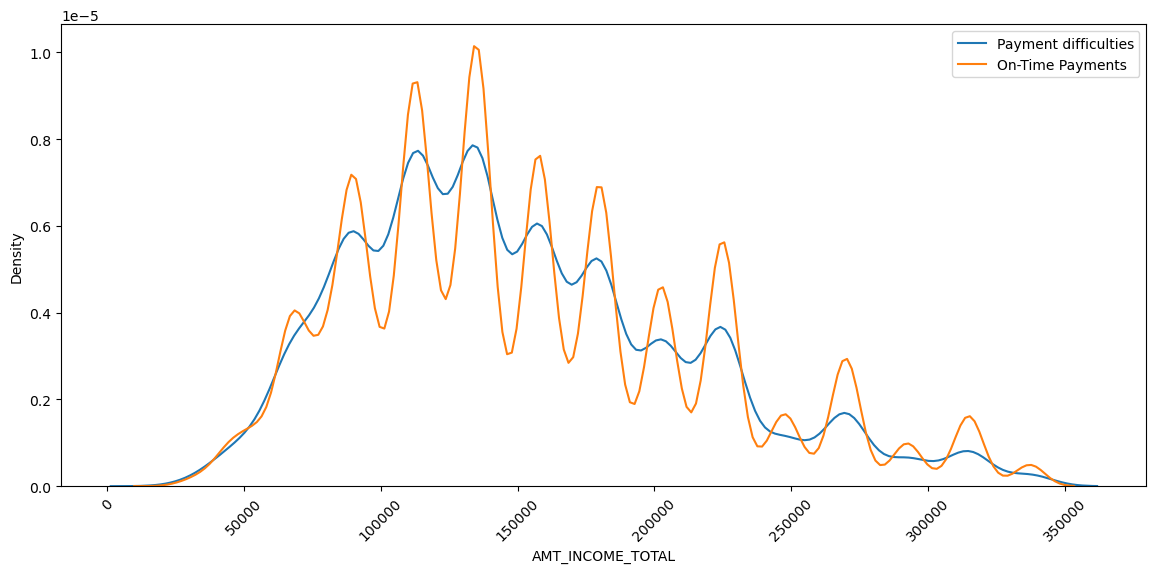

In [256]:
kde_no_outliers(df0, df1, Max_value0, Max_value1, 'AMT_INCOME_TOTAL')

**Спостереження**

- Для `AMT_INCOME_TOTAL`, більшість клієнтів з доходом від 60000 вчасно здійснюють платежі, але графік нестабільний

# Двовимірний/Багатовимірний аналіз

## Неперервні vs неперервні змінні

### Аналіз стовпця `AMT_GOODS_PRICE` vs `AMT_CREDIT`

**Пошук викидів для ствопця `AMT_GOODS_PRICE ` для групи із платіжними труднощами**

In [257]:
max_value1_AMT_GOODS_PRICE = outlier_range(df1,'AMT_GOODS_PRICE')
max_value1_AMT_GOODS_PRICE

1329750.0

**Пошук викидів для ствопця `AMT_CREDIT` для групи із платіжними труднощами**

In [258]:
max_value1_AMT_CREDIT = outlier_range(df1,'AMT_CREDIT')
max_value1_AMT_CREDIT

1406688.75

**Пошук викидів для `AMT_GOODS_PRICE `для групи із вчасними оплатами**

In [259]:
max_value0_AMT_GOODS_PRICE = outlier_range(df0,'AMT_GOODS_PRICE')
max_value0_AMT_GOODS_PRICE

1354755.9375

**Пошук викидів для `AMT_CREDIT `для групи із вчасними оплатами**

In [260]:
max_value0_AMT_CREDIT = outlier_range(df0,'AMT_CREDIT')
max_value0_AMT_CREDIT

1620000.0

Побудова діаграми розсіювання для порівняння з видаленими викидами

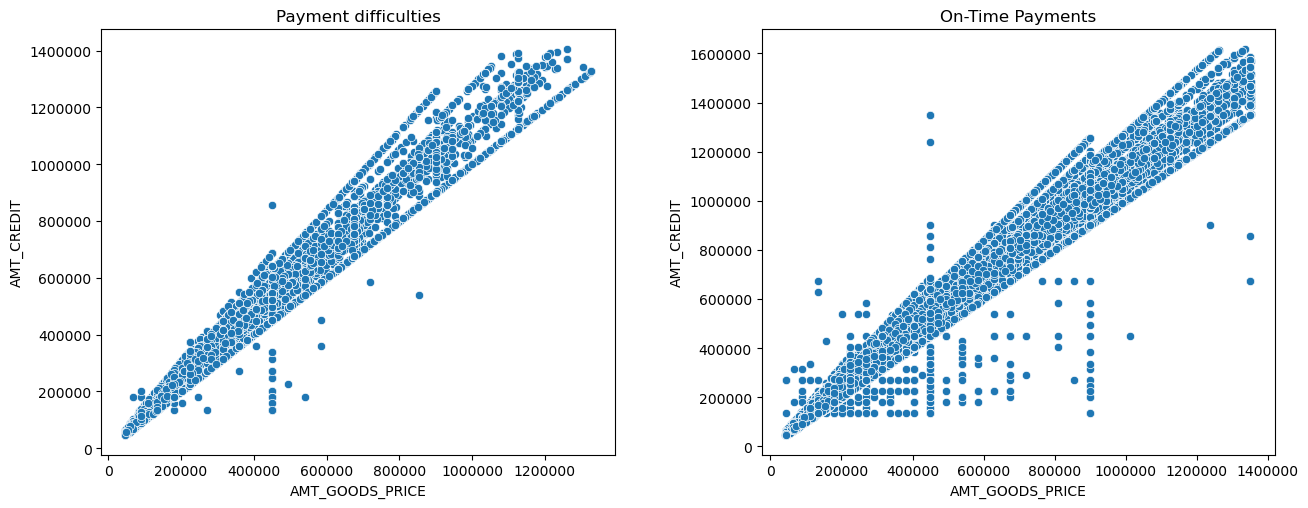

In [261]:
plt.figure(figsize = (14, 6))

plt.subplot(1,2,1)
plt.title('Payment difficulties')
sns.scatterplot(x = df1[df1['AMT_GOODS_PRICE'] < max_value1_AMT_GOODS_PRICE].AMT_GOODS_PRICE,
                y = df1[df1['AMT_CREDIT'] < max_value1_AMT_CREDIT].AMT_CREDIT, data = df1)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.subplot(1,2,2)
plt.title('On-Time Payments')
sns.scatterplot(x = df0[df0['AMT_GOODS_PRICE'] < max_value0_AMT_GOODS_PRICE].AMT_GOODS_PRICE,
                y = df0[df0['AMT_CREDIT'] < max_value0_AMT_CREDIT].AMT_CREDIT, data = df0)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout(pad = 4)
plt.show()

**Спостереження**
- AMT_GOODS_PRICE та AMT_CREDIT мають сильну позитивну кореляцію. Це означає, що зі збільшенням ціни товару зростає і сума кредиту

# ДЗ 6. Кореляційний аналіз для пари числових змінних

Проведіть подібний до прикладу кореляційний аналіз для пар змінних
- AMT_ANNUITY і AMT_CREDIT
- DAYS_EMPLOYED і AMT_INCOME_TOTAL
- AMT_CREDIT і DAYS_BIRTH

Для цього винесіть функціонал для аналізу у функцію та викличіть функцію для кожної двійки змінних.
Зробіть висновок про наявність кореляції між змінними.

In [262]:
#використаю попередню функцію для розрахунку максимальних значень,
#та створю додаткову для візуалізації даних
def subplot_no_outliers(df0, df1, column1, column2, max_value1_column1, max_value1_column2, max_value0_column1, max_value0_column2):
    plt.figure(figsize = (14, 6))

    plt.subplot(1,2,1)
    plt.title('Payment difficulties')
    sns.scatterplot(x = df1[df1[column1] < max_value1_column1][column1],
                    y = df1[df1[column2] < max_value1_column2][column2], data = df1)
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')

    plt.subplot(1,2,2)
    plt.title('On-Time Payments')
    sns.scatterplot(x = df0[df0[column1] < max_value0_column1][column1],
                    y = df0[df0[column2] < max_value0_column2][column2], data = df0)
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')

    plt.tight_layout(pad = 4)
    plt.show()


### Аналіз стовпця AMT_ANNUITY і AMT_CREDIT

In [263]:
max_value0_column1, max_value1_column1 = IQR_max_value('AMT_ANNUITY')
max_value0_column2, max_value1_column2 = IQR_max_value('AMT_CREDIT')

15615.0
Мінімальне значення, до якого існують викиди: -6061.5
Максимальне значення, після якого існують викиди: 56398.5
18292.5
Мінімальне значення, до якого існують викиди: -10982.25
Максимальне значення, після якого існують викиди: 62187.75
448915.5
Мінімальне значення, до якого існують викиди: -388973.25
Максимальне значення, після якого існують викиди: 1406688.75
540000.0
Мінімальне значення, до якого існують викиди: -540000.0
Максимальне значення, після якого існують викиди: 1620000.0


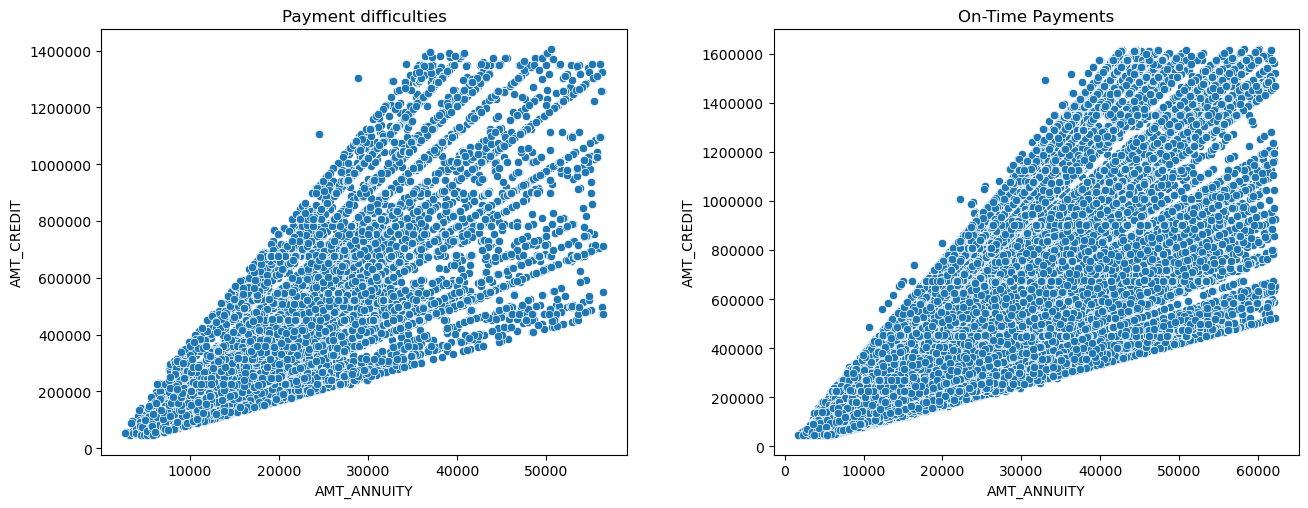

In [264]:
subplot_no_outliers(df0, df1, 'AMT_ANNUITY', 'AMT_CREDIT', max_value1_column1, max_value1_column2, max_value0_column1, max_value0_column2)

**Спостереження**
- AMT_ANNUITY та AMT_CREDIT мають сильну позитивну кореляцію. Це означає, що зі збільшенням доходу від оренди збільшуеться і сума кредиту

### Аналіз стовпця DAYS_EMPLOYED і AMT_INCOME_TOTAL

In [265]:
max_value0_column1, max_value1_column1 = IQR_max_value('DAYS_EMPLOYED')
max_value0_column2, max_value1_column2 = IQR_max_value('AMT_INCOME_TOTAL')

2603.0
Мінімальне значення, до якого існують викиди: -3227.5
Максимальне значення, після якого існують викиди: 7184.5
5107.0
Мінімальне значення, до якого існують викиди: -6693.5
Максимальне значення, після якого існують викиди: 13734.5
90000.0
Мінімальне значення, до якого існують викиди: -22500.0
Максимальне значення, після якого існують викиди: 337500.0
90000.0
Мінімальне значення, до якого існують викиди: -22500.0
Максимальне значення, після якого існують викиди: 337500.0


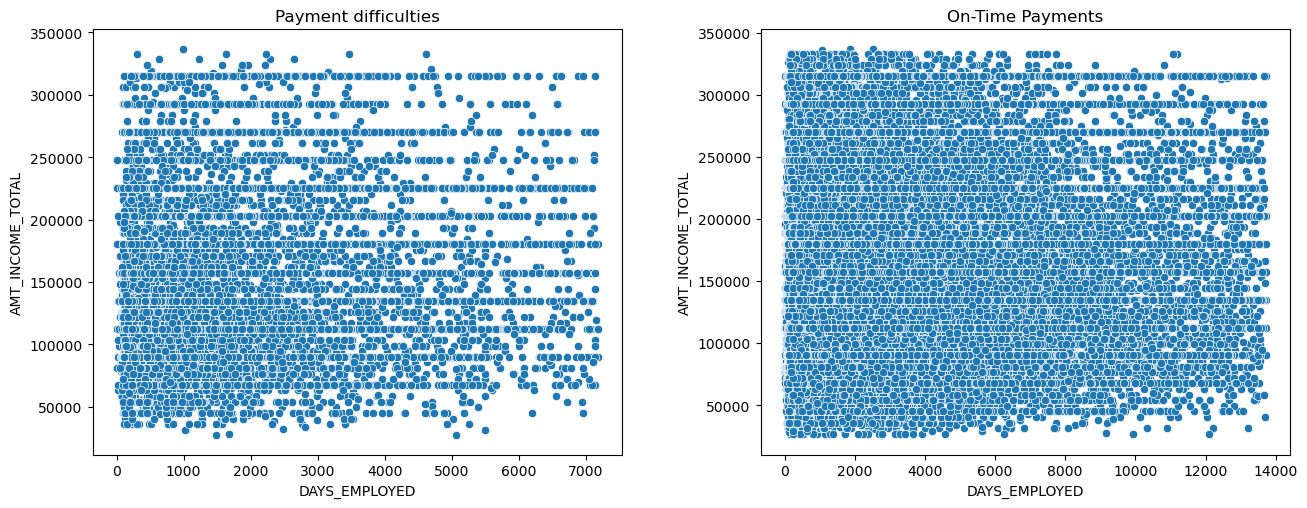

In [266]:
subplot_no_outliers(df0, df1, 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', max_value1_column1, max_value1_column2, max_value0_column1, max_value0_column2)

**Спостереження**
- DAYS_EMPLOYED і AMT_INCOME_TOTAL мають лінійну кореляцію. Це означає, що ці значення не мають залежності, або вона дуже неочевидна

### Аналіз стовпця AMT_CREDIT і DAYS_BIRTH

In [267]:
max_value0_column1, max_value1_column1 = IQR_max_value('AMT_CREDIT')
max_value0_column2, max_value1_column2 = IQR_max_value('DAYS_BIRTH')

448915.5
Мінімальне значення, до якого існують викиди: -388973.25
Максимальне значення, після якого існують викиди: 1406688.75
540000.0
Мінімальне значення, до якого існують викиди: -540000.0
Максимальне значення, після якого існують викиди: 1620000.0
6641.0
Мінімальне значення, до якого існують викиди: 1434.5
Максимальне значення, після якого існують викиди: 27998.5
7257.75
Мінімальне значення, до якого існують викиди: 1649.375
Максимальне значення, після якого існують викиди: 30680.375


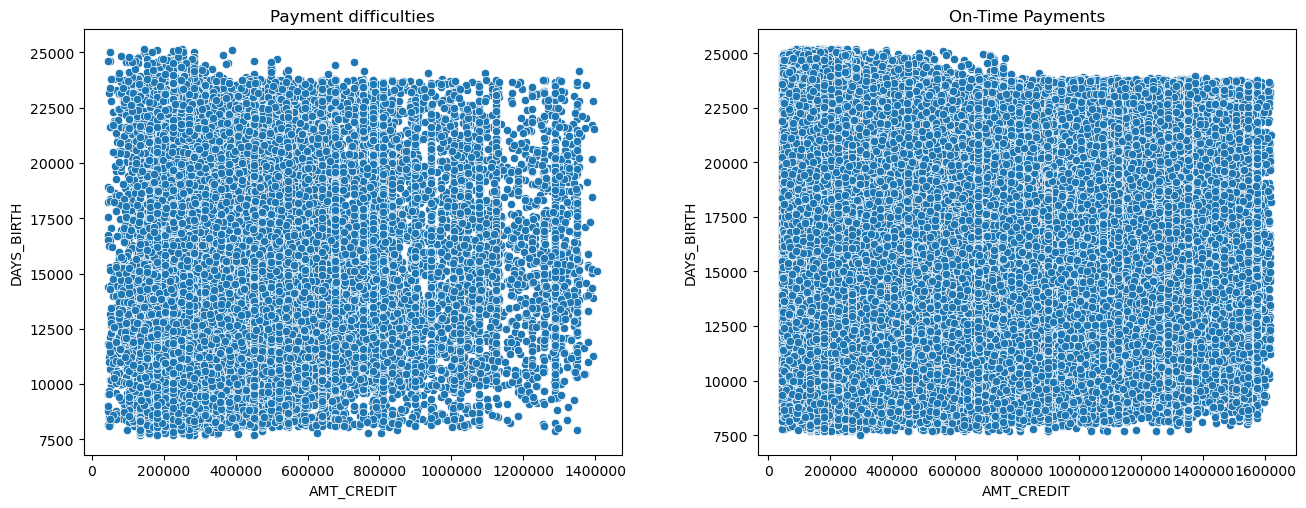

In [268]:
subplot_no_outliers(df0, df1, 'AMT_CREDIT', 'DAYS_BIRTH', max_value1_column1, max_value1_column2, max_value0_column1, max_value0_column2)

**Спостереження**
- AMT_CREDIT і DAYS_BIRTH мають лінійну кореляцію. Це означає, що ці значення не мають залежності, або вона дуже неочевидна

## Неперервні та категоріальні змінні

In [269]:
def draw_boxplot(df, categorical, continuous, max_continuous, title, hue_column, subplot_position):
    """
    Малює блок-діаграму для заданого DataFrame, категоріальної та неперервної змінної.
    """
    plt.subplot(1, 2, subplot_position)
    plt.title(title)
    red_diamond = dict(markerfacecolor='r', marker='D')
    sns.boxplot(x=categorical,
                y=df[df[continuous] < max_continuous][continuous],
                data=df,
                flierprops=red_diamond,
                order=sorted(df[categorical].unique(), reverse=True),
                hue=hue_column, hue_order=sorted(df[hue_column].unique(), reverse=True))
    plt.ticklabel_format(style='plain', axis='y')
    plt.xticks(rotation=90)

def bi_boxplot(categorical, continuous, max_continuous1, max_continuous0, hue_column):
    """
    Створює паралельні блок-діаграми для двох груп, визначених у наборі даних, на основі
    категоріальної та неперервної змінної, виділяючи відмінності за допомогою відтінків.
    """
    plt.figure(figsize=(16, 10))

    # Графік для першо групи "Труднощі з платежами" (Payment Difficulties)
    draw_boxplot(df1, categorical, continuous, max_continuous1, 'Payment Difficulties', hue_column, 1)

    # Графік для другої групи "Вчасні оплати" (On-Time Payments)
    draw_boxplot(df0, categorical, continuous, max_continuous0, 'On-Time Payments', hue_column, 2)

    plt.tight_layout(pad=4)
    plt.show()

### Аналіз стовпців `AMT_CREDIT` vs `NAME_EDUCATION_TYPE` vs `CODE_GENDER`

**Пошук викидів для `AMT_CREDIT `для групи із платіжними труднощами**

In [270]:
max_value1_AMT_CREDIT = outlier_range(df1,'AMT_CREDIT')
max_value1_AMT_CREDIT

1406688.75

**Пошук викидів для `AMT_CREDIT ` для групи із вчасними платежами**

In [271]:
max_value0_AMT_CREDIT = outlier_range(df0,'AMT_CREDIT')
max_value0_AMT_CREDIT

1620000.0

**Клієнт з платіжними труднощами**

In [272]:
df1.groupby(by = ['NAME_EDUCATION_TYPE','CODE_GENDER']).AMT_CREDIT.describe().head()

count      mean       std       min  \
NAME_EDUCATION_TYPE CODE_GENDER                                         
Academic degree     F              3.00 950245.50 504711.38 544491.00   
Higher education    F           2438.00 648500.58 410415.70  47970.00   
                    M           1571.00 642070.94 409695.93  45000.00   
Incomplete higher   F            504.00 520150.35 352227.49  91692.00   
                    M            368.00 554723.82 347843.71  74628.00   

                                      25%       50%        75%        max  
NAME_EDUCATION_TYPE CODE_GENDER                                            
Academic degree     F           667660.50 790830.00 1153122.75 1515415.50  
Higher education    F           323595.00 545040.00  877500.00 2687355.00  
                    M           329202.00 545040.00  832797.00 2695500.00  
Incomplete higher   F           269550.00 450000.00  675000.00 2695500.00  
                    M           284400.00 497520.00  699976.12 2013840.00

**Клієнт зі вчасними платежами**

In [273]:
df0.groupby(by = ['NAME_EDUCATION_TYPE','CODE_GENDER']).AMT_CREDIT.describe().head()

count      mean       std       min  \
NAME_EDUCATION_TYPE CODE_GENDER                                          
Academic degree     F              97.00 708770.74 463052.42 130824.00   
                    M              64.00 735235.38 497739.97  74182.50   
Higher education    F           47852.00 682485.00 456642.78  45000.00   
                    M           23002.00 713144.54 486073.66  45000.00   
Incomplete higher   F            5780.00 555340.53 385980.60  45000.00   

                                      25%       50%        75%        max  
NAME_EDUCATION_TYPE CODE_GENDER                                            
Academic degree     F           354469.50 607500.00 1006920.00 2463840.00  
                    M           309519.00 610056.00 1036890.00 1984500.00  
Higher education    F           302206.50 568057.50  916470.00 4050000.00  
                    M           315000.00 592560.00  973503.00 4050000.00  
Incomplete higher   F           253737.00 454500.00  760225.50 2517300.00

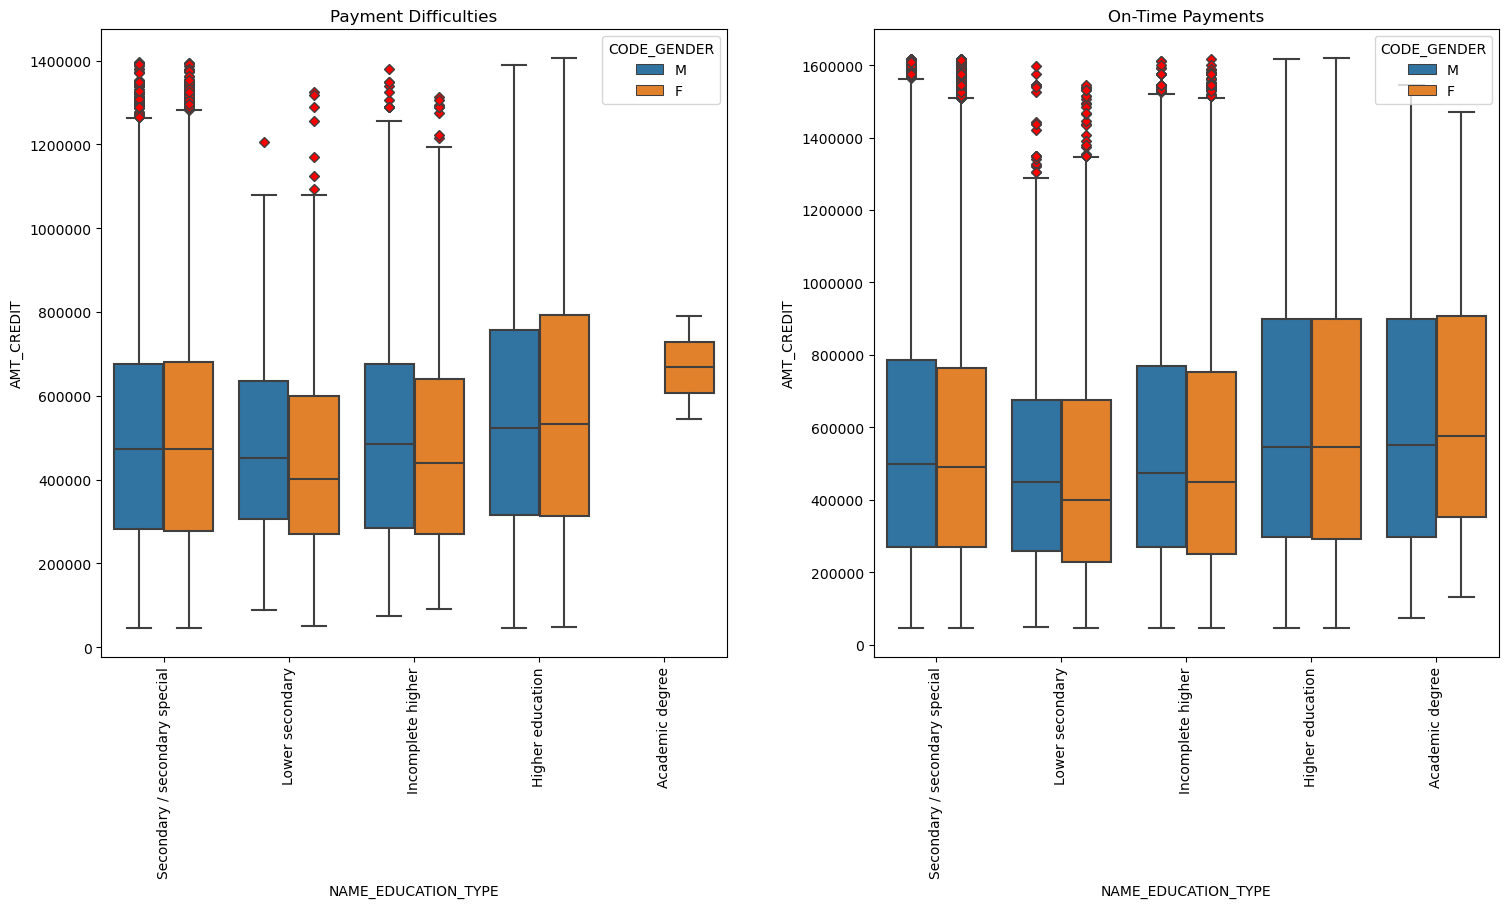

In [274]:
bi_boxplot('NAME_EDUCATION_TYPE','AMT_CREDIT',max_value1_AMT_CREDIT, max_value0_AMT_CREDIT, 'CODE_GENDER')


**Спостереження**
- Клієнти з "академічним ступенем" мають широкий діапазон кредитів для своєчасних платежів, тоді як для клієнтів з проблемами з оплатою цей діапазон значно нижчий
- Якщо поглянути на зведену статистику, то клієнти з "академічним ступенем" та проблемами з оплатою беруть середній та медіанний кредит у значно більшому діапазоні, ніж клієнти з вчасною оплатою.
- Клієнти-чоловіки з "академічним ступенем" завжди сплачують кредит вчасно

# ДЗ 7. Кореляційний аналіз між двома категоріальними змінними і числовою

Проведіть аналогічний кореляційний аналіз для трійок змінних

- AMT_INCOME_TOTAL vs NAME_FAMILY_STATUS vs CODE_GENDER
- AMT_INCOME_TOTAL vs YEARS_BIRTH_CATEGORY vs NAME_HOUSING_TYPE
- AMT_GOODS_PRICE vs NAME_INCOME_TYPE vs CODE_GENDER
- AMT_INCOME_TOTAL vs OCCUPATION_TYPE vs CODE_GENDER

Можете також проаналізувати додатково свою трійку 

Для цього винесіть функціонал для аналізу у функцію та викличіть функцію для кожної трійки змінних.

Зробіть висновок про наявність кореляції між змінними.


In [289]:
#створимо функцію для швидкого аналізу 
def three_dim_analysis(column1, column2, column3):
    max_value0_column1, max_value1_column1 = IQR_max_value(column1)
    desr_for_df1 = df1.groupby(by = [column2, column3])[column1].describe().head(10)
    print (desr_for_df1)
    desr_for_df0 = df0.groupby(by = [column2, column3])[column1].describe().head(10)
    print (desr_for_df0)
    bi_boxplot(column2, column1, max_value1_column1, max_value0_column1, column3)

### Аналіз стовпців AMT_INCOME_TOTAL vs NAME_FAMILY_STATUS vs CODE_GENDER

90000.0
Мінімальне значення, до якого існують викиди: -22500.0
Максимальне значення, після якого існують викиди: 337500.0
90000.0
Мінімальне значення, до якого існують викиди: -22500.0
Максимальне значення, після якого існують викиди: 337500.0
                                   count      mean        std      min  \
NAME_FAMILY_STATUS   CODE_GENDER                                         
Civil marriage       F           1753.00 153620.72  101045.86 25650.00   
                     M           1208.00 173949.99   92449.17 36000.00   
Married              F           8324.00 159907.85 1283283.40 27000.00   
                     M           6526.00 182233.06   94787.77 31500.00   
Separated            F           1045.00 161159.55   82633.33 36000.00   
                     M            575.00 178888.28   85034.85 45000.00   
Single / not married F           2220.00 150373.57   76996.14 31500.00   
                     M           2237.00 166827.99   80471.61 40500.00   
Widow           

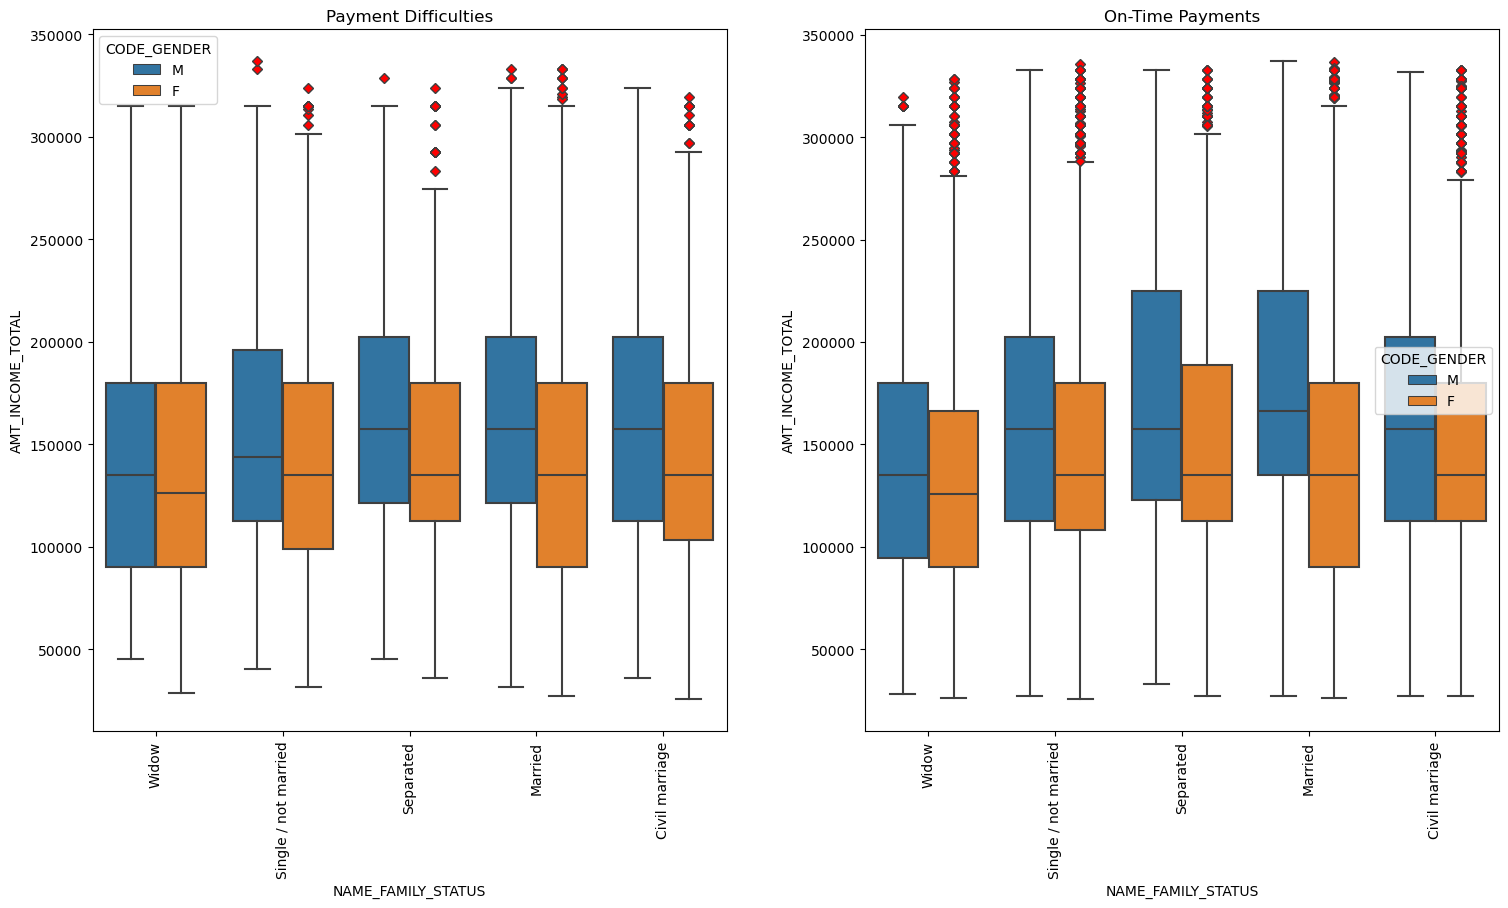

In [288]:
three_dim_analysis('AMT_INCOME_TOTAL', 'NAME_FAMILY_STATUS', 'CODE_GENDER')


**Спостереження**
- Жінки в середньому беруть менші суми кредиту ніж чоловіки 
- Сімейний статус не дає особливих спостережень на вплив оплат по кредиту 


### Аналіз стовпців AMT_INCOME_TOTAL vs YEARS_BIRTH_CATEGORY vs NAME_HOUSING_TYPE

90000.0
Мінімальне значення, до якого існують викиди: -22500.0
Максимальне значення, після якого існують викиди: 337500.0
90000.0
Мінімальне значення, до якого існують викиди: -22500.0
Максимальне значення, після якого існують викиди: 337500.0
                                           count      mean        std  \
YEARS_BIRTH_CATEGORY NAME_HOUSING_TYPE                                  
20-30                Co-op apartment       40.00 148628.70   59516.24   
                     House / apartment   4201.00 151897.22   70874.65   
                     Municipal apartment  153.00 153608.82   78282.79   
                     Office apartment      40.00 147375.00   50817.26   
                     Rented apartment     229.00 144210.10   59998.66   
                     With parents         930.00 143226.04   68189.31   
30-40                Co-op apartment       27.00 199515.00   96443.31   
                     House / apartment   6606.00 184272.70 1440563.87   
                     Munic

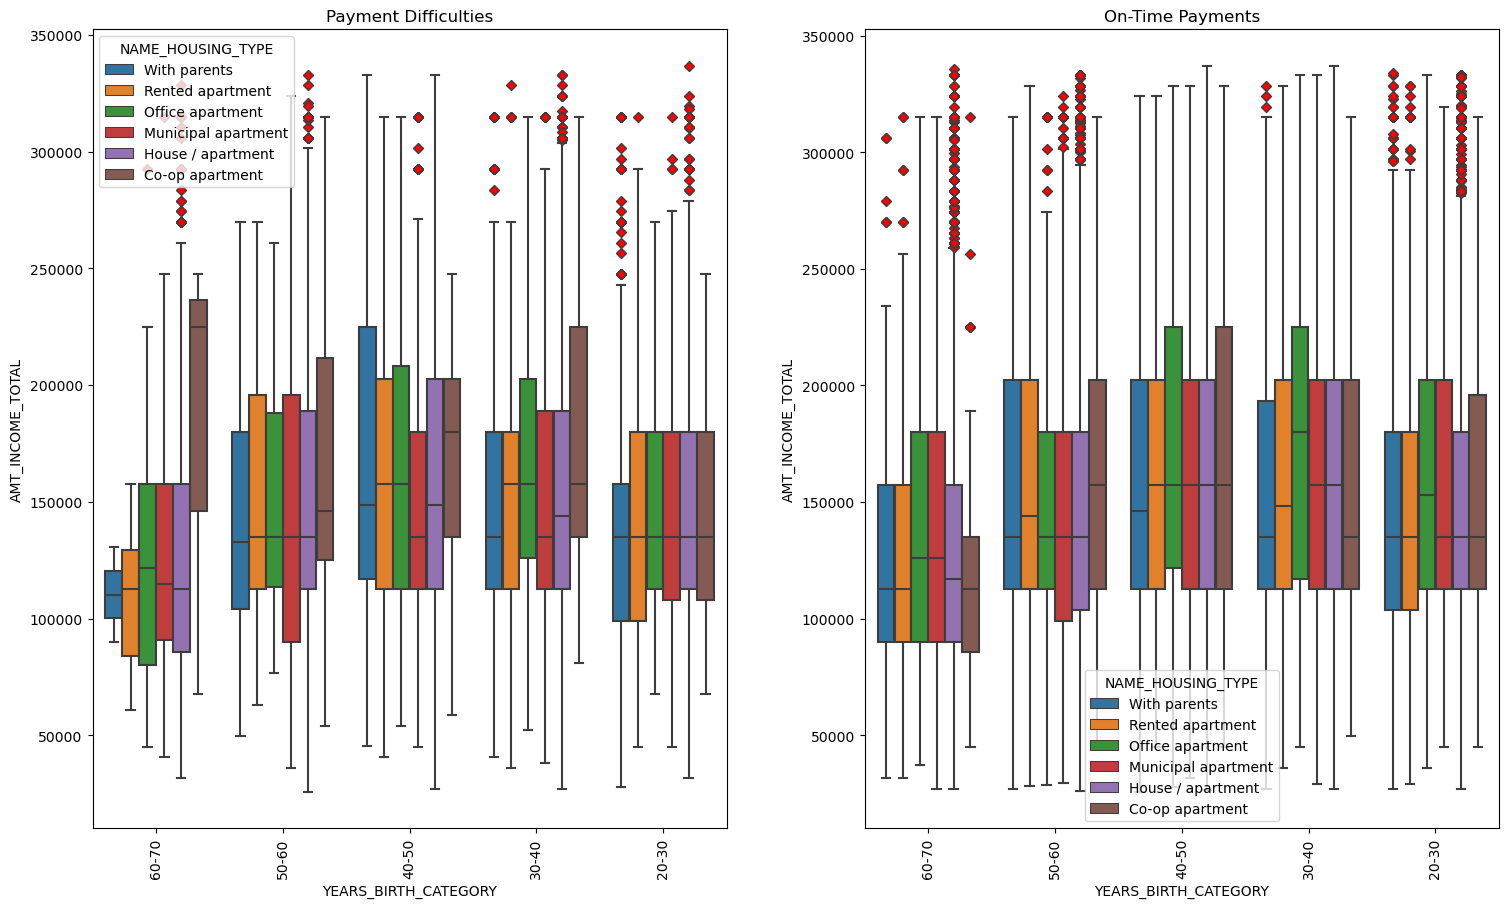

In [290]:
three_dim_analysis('AMT_INCOME_TOTAL', 'YEARS_BIRTH_CATEGORY', 'NAME_HOUSING_TYPE')


**Спостереження**
- Клієнти в віковій категорії 60-70 років, з типом житла ко-апартаментів, з доходом близько 150000 - 250000 мають проблеми з платежами по кредиту 

### Аналіз стовпців AMT_GOODS_PRICE vs NAME_INCOME_TYPE vs CODE_GENDER

436500.0
Мінімальне значення, до якого існують викиди: -416250.0
Максимальне значення, після якого існують викиди: 1329750.0
446502.375
Мінімальне значення, до якого існують викиди: -431253.5625
Максимальне значення, після якого існують викиди: 1354755.9375
                                   count      mean       std       min  \
NAME_INCOME_TYPE     CODE_GENDER                                         
Commercial associate F           2968.00 536304.02 353598.52  45000.00   
                     M           2392.00 526355.38 335793.33  45000.00   
Maternity leave      F              2.00 929250.00 715945.62 423000.00   
Pensioner            F           2243.00 494976.12 316903.86  45000.00   
                     M            739.00 486543.08 321104.43  45000.00   
State servant        F            847.00 544120.88 336074.93  45000.00   
                     M            402.00 536955.22 339694.98  45000.00   
Unemployed           F              6.00 653250.00 321180.44 328500.00   
  

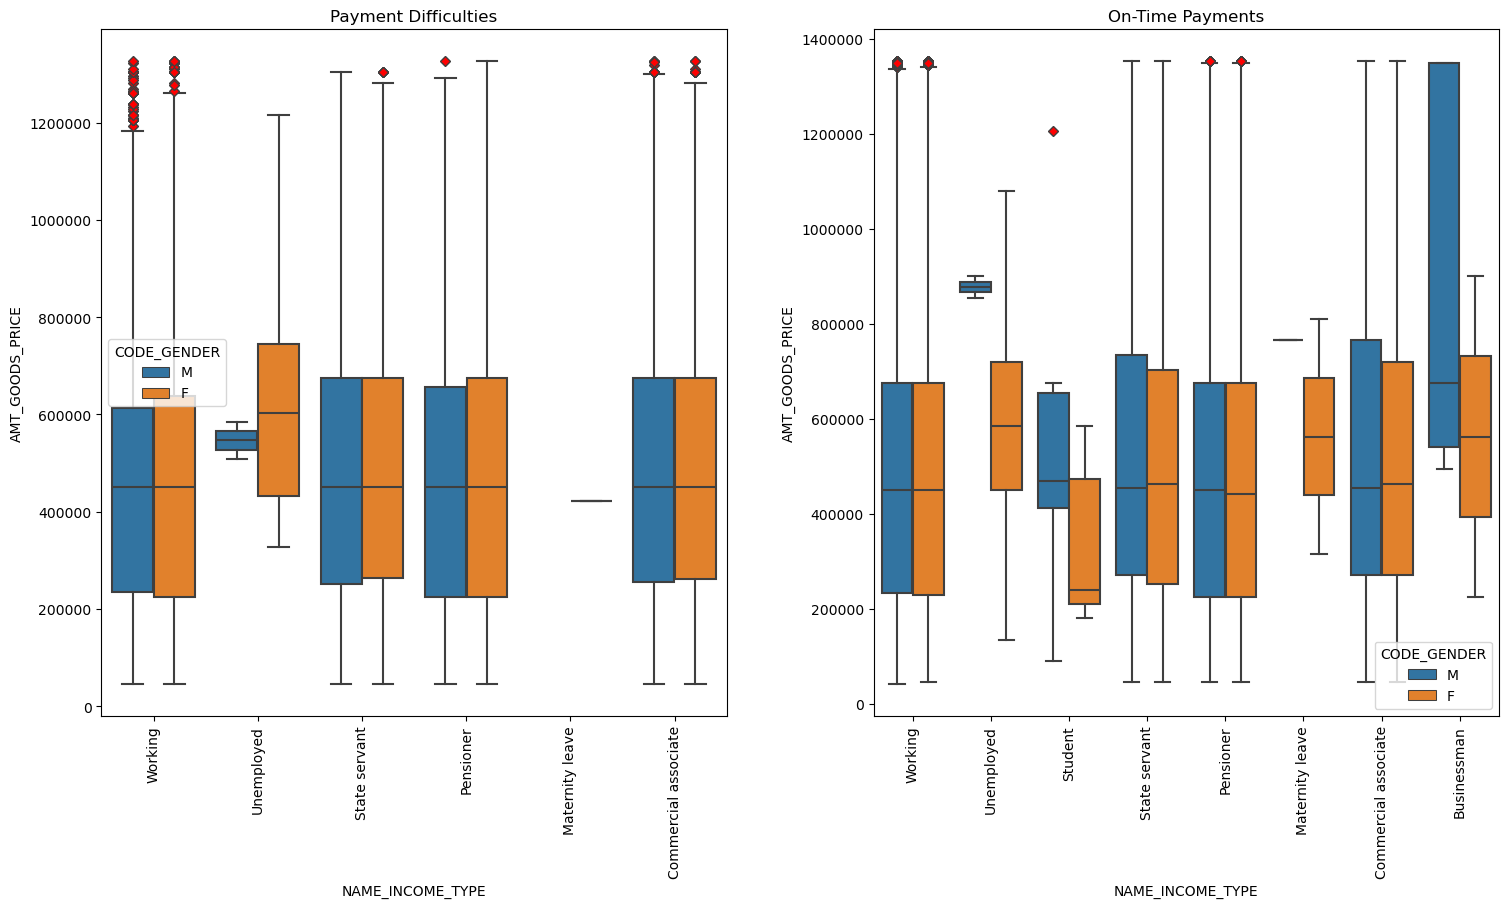

In [292]:
three_dim_analysis('AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'CODE_GENDER')


**Спостереження**
- Нетрудовлаштовані чоловіки з сумою речей до 600000 - завжди мають проблеми з оплатою, а з сумою речей від 800000 - завжди сплачують вчасно
- Клієнти-бізнесмени, студенти та ті що в декреті - завжди сплачують кредит вчасно

### Аналіз стовпців AMT_INCOME_TOTAL vs OCCUPATION_TYPE vs CODE_GENDER

90000.0
Мінімальне значення, до якого існують викиди: -22500.0
Максимальне значення, після якого існують викиди: 337500.0
90000.0
Мінімальне значення, до якого існують викиди: -22500.0
Максимальне значення, після якого існують викиди: 337500.0
                              count      mean       std      min       25%  \
OCCUPATION_TYPE CODE_GENDER                                                  
Accountants     F            457.00 174840.64  79021.04 54000.00 112500.00   
                M             17.00 202367.65  98623.66 81000.00 121500.00   
Cleaning staff  F            410.00 128907.99  70328.23 31500.00  90000.00   
                M             37.00 119493.24  45786.21 45000.00  90000.00   
Cooking staff   F            555.00 129298.38  55531.88 32400.00  90000.00   
                M             66.00 177136.36  70219.69 54000.00 135000.00   
Core staff      F           1300.00 151346.91  82703.03 27900.00  99000.00   
                M            438.00 186997.33 105677.7

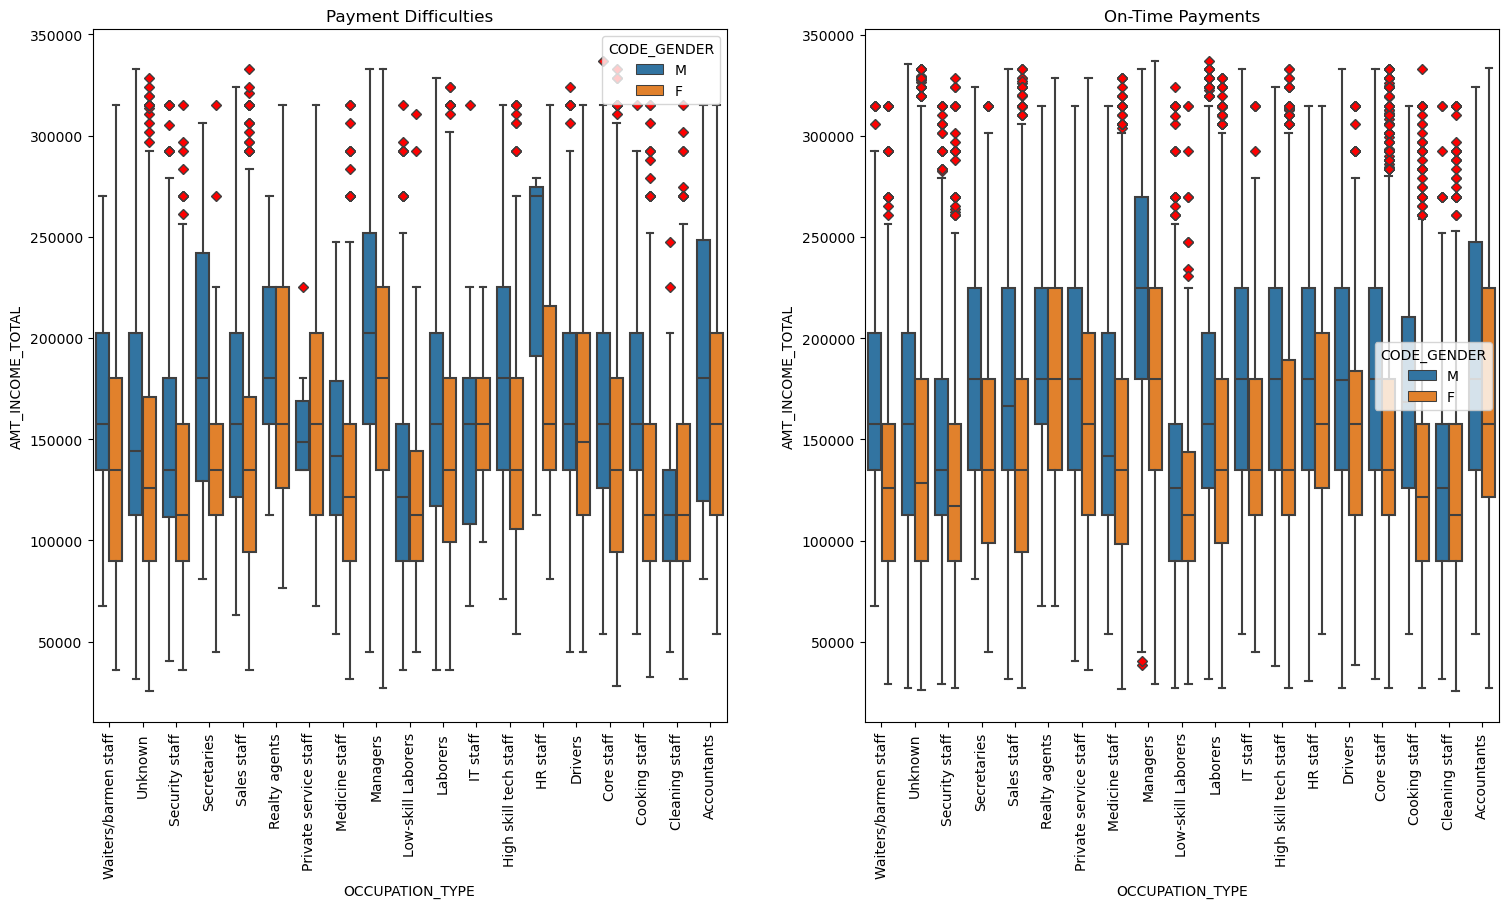

In [300]:
three_dim_analysis('AMT_INCOME_TOTAL', 'OCCUPATION_TYPE', 'CODE_GENDER')


**Спостереження**
- Клієнти чоловіки HR-Staff з зарплатою більше 240000 мають проблеми з оплатою

### Аналіз стовпців AMT_INCOME_TOTAL vs NAME_INCOME_TYPE vs CODE_GENDER

проведемо ще один додатковий аналіз 

90000.0
Мінімальне значення, до якого існують викиди: -22500.0
Максимальне значення, після якого існують викиди: 337500.0
90000.0
Мінімальне значення, до якого існують викиди: -22500.0
Максимальне значення, після якого існують викиди: 337500.0
                                   count      mean        std      min  \
NAME_INCOME_TYPE     CODE_GENDER                                         
Commercial associate F           2968.00 172962.54   94922.97 36000.00   
                     M           2392.00 207145.51  120281.01 45000.00   
Maternity leave      F              2.00  58500.00   12727.92 49500.00   
Pensioner            F           2243.00 133275.59   71580.63 25650.00   
                     M            739.00 142481.26   76941.74 31500.00   
State servant        F            847.00 153820.07  129116.41 27900.00   
                     M            402.00 187665.11   83834.74 40500.00   
Unemployed           F              6.00  79500.00   35280.31 45000.00   
                

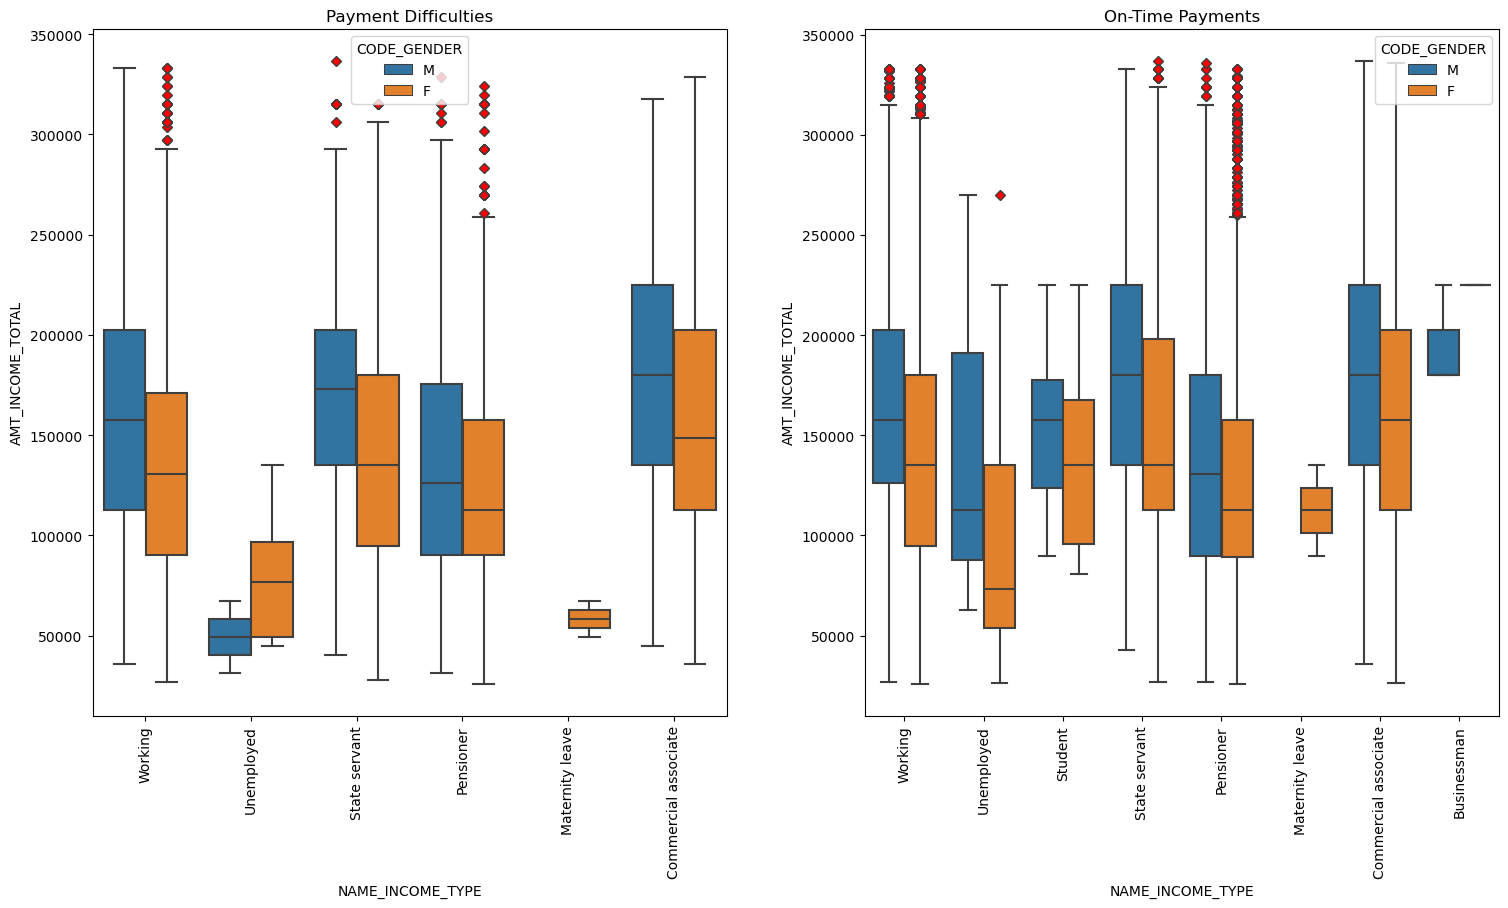

In [301]:
three_dim_analysis('AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'CODE_GENDER')

**Спостереження**
- Нетрудовлаштовані чоловіки з доходом до 60000 - завжди мають проблеми з оплатою, а з доходом від 60000 - завжди сплачують вчасно
- жінки в декретній відпустці з доходом до 60000 - завжди мають проблеми з оплатою, а з доходом від 70000 - завжди сплачують вчасно
- Клієнти-бізнесмени, студенти - завжди сплачують кредит вчасно

## Залежності між категоріальними змінними

### Аналіз стовпців `NAME_INCOME_TYPE` vs `CODE_GENDER`

In [302]:
def bi_countplot_target(df0, df1, column, hue_column):
  group_name = f'Нормалізований розподіл значень за категорією: {column}'
  print(group_name.upper())

  pltname = 'Клієнт зі складнощами щодо платності'
  unique_hue_values = df1[hue_column].unique()
  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.set_size_inches(14,4)

  proportions = df1.groupby(hue_column)[column].value_counts(normalize=True)
  proportions = (proportions*100).round(2)
  ax = proportions.unstack(hue_column).sort_values(
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[0], title=pltname)

  # анотація значень в барплоті
  for container in ax.containers:
      ax.bar_label(container, fmt='{:,.1f}%')

  pltname = 'Клієнти зі своєчасними платежами'
  unique_hue_values = df0[hue_column].unique()

  proportions = df0.groupby(hue_column)[column].value_counts(normalize=True)
  proportions = (proportions*100).round(2)
  ax = proportions.unstack(hue_column).sort_values(
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[1], title=pltname)

  for container in ax.containers:
      ax.bar_label(container, fmt='{:,.1f}%')

  plt.show()

  # ---------------
  group_name = f'Кількість значень за категорією: {column}'
  print(group_name.upper())

  pltname = 'Клієнт зі складнощами щодо платності'
  unique_hue_values = df1[hue_column].unique()
  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.set_size_inches(14,4)

  counts = df1.groupby(hue_column)[column].value_counts()
  ax = counts.unstack(hue_column).sort_values(
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[0], title=pltname)

  for container in ax.containers:
    ax.bar_label(container)

  pltname = 'Клієнти зі своєчасними платежами'
  unique_hue_values = df0[hue_column].unique()

  counts = df0.groupby(hue_column)[column].value_counts()
  ax = counts.unstack(hue_column).sort_values(
      by=unique_hue_values[0], ascending=False
      ).plot.bar(ax=axes[1], title=pltname)

  for container in ax.containers:
    ax.bar_label(container)

  plt.show()

НОРМАЛІЗОВАНИЙ РОЗПОДІЛ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: NAME_INCOME_TYPE


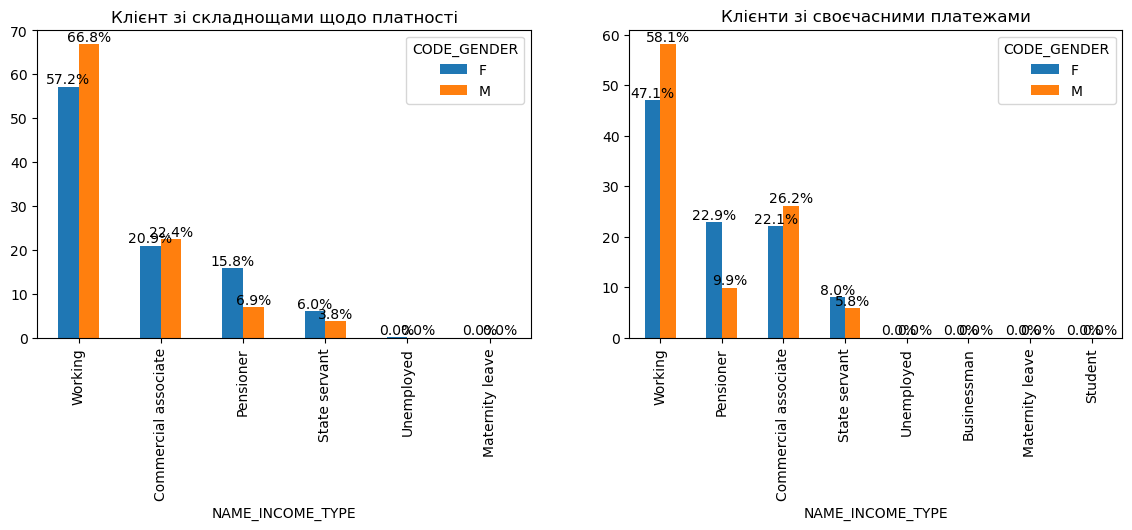

КІЛЬКІСТЬ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: NAME_INCOME_TYPE


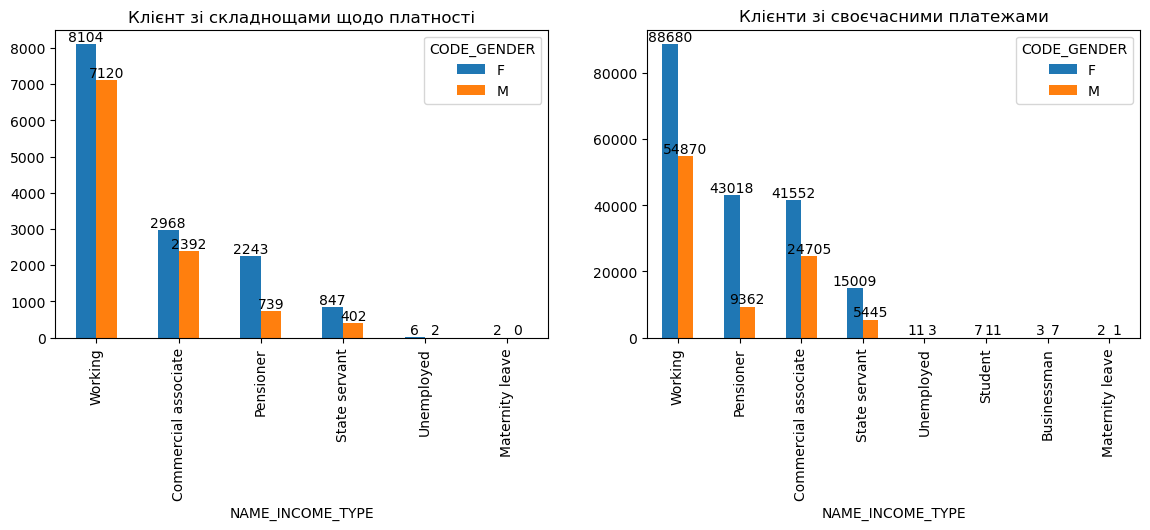

In [295]:
bi_countplot_target(df0, df1, 'NAME_INCOME_TYPE','CODE_GENDER');

**Спостереження**
- Серед клієнтів, які мають складнощі з платністю людей категорії "Працюючі" та "Чоловіки" відсотково значно більше, ніж серед клієнтів, які складнощів з платністю не мають.
- Серед клієнтів, які мають складнощі з платністю людей категорії "Працюючі" та "Жінки" відсотково значно більше, ніж серед клієнтів, які складнощів з платністю не мають.
- Оскільки за обома CODE_GENDER бачимо, що найбільший відсоток клієнтів мають NAME_INCOME_TYPE Working - важливо проаналізувати ще додаткові змінні, які можуть впливати на те, чи буде клієнт мати складнощі з платежами, адже група клієнтів NAME_INCOME_TYPE Working - є в цілому найбільшою в наших даних.
- Клієнти категорії "Бізнесмени" та "Студенти" здійснюють платежі вчасно, хоча їхня історія невелика

# ДЗ 8. Аналіз взаємозалежностей між двома категоріальними змінними

Проведіть подібний до прикладу аналіз залежностей між категоріальними змінними для пар змінних

- NAME_EDUCATION_TYPE vs CODE_GENDER
- NAME_FAMILY_STATUS vs OCCUPATION_TYPE
- OCCUPATION_TYPE vs NAME_CONTRACT_TYPE

Опишіть спостереження щодо того, чи є цікаві знахідки стосовно цільової змінної з цього аналізу.

### Аналіз стовпців NAME_EDUCATION_TYPE vs CODE_GENDER

НОРМАЛІЗОВАНИЙ РОЗПОДІЛ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: NAME_EDUCATION_TYPE


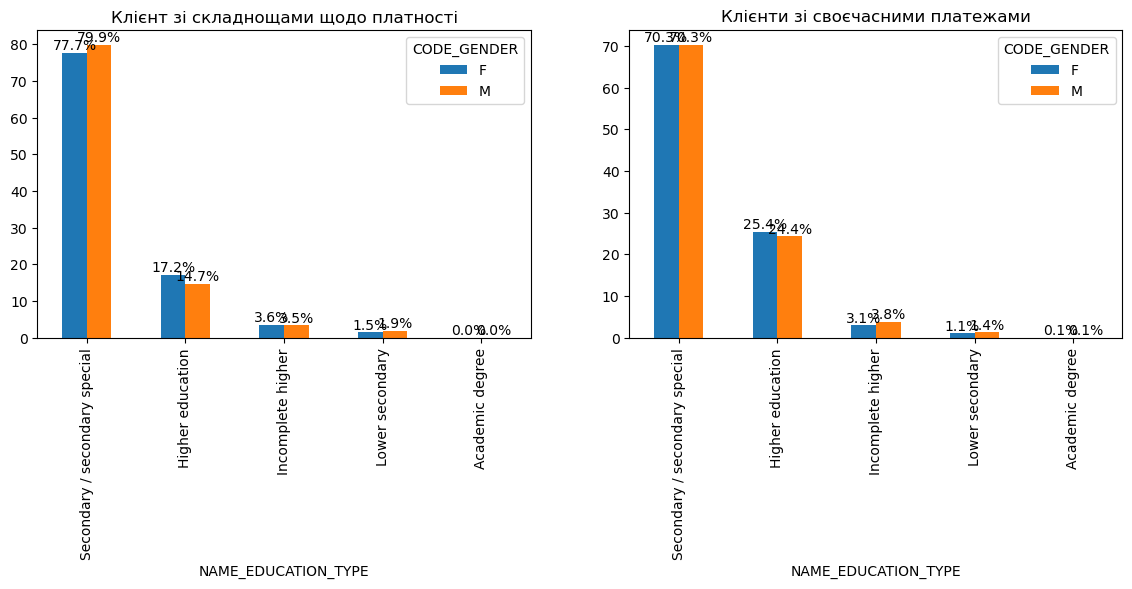

КІЛЬКІСТЬ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: NAME_EDUCATION_TYPE


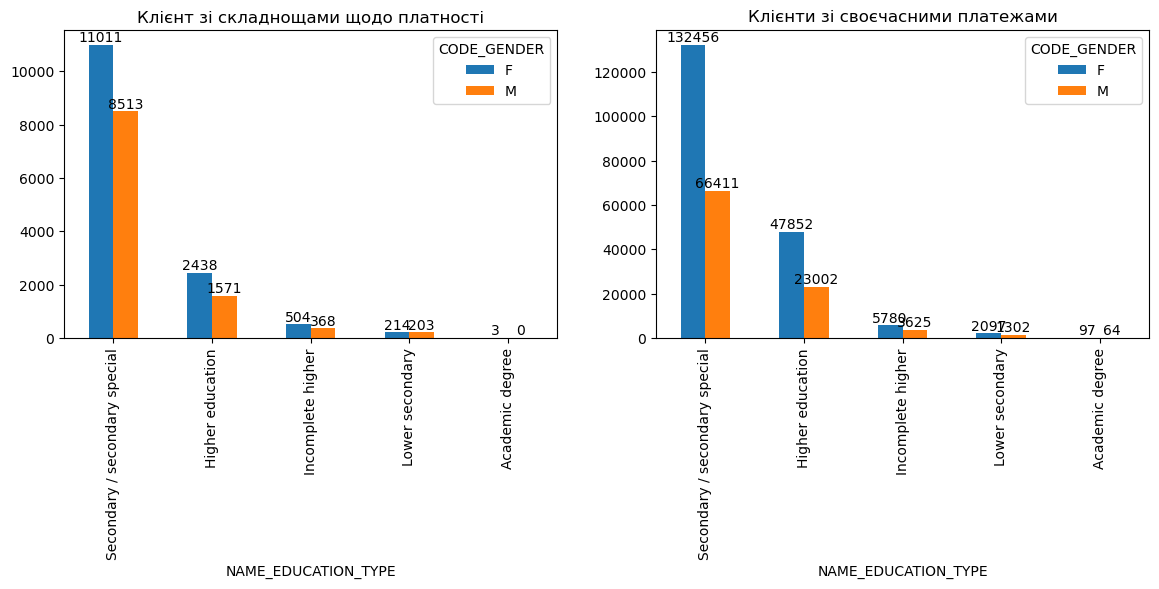

In [303]:
bi_countplot_target(df0, df1, 'NAME_EDUCATION_TYPE','CODE_GENDER');

**Спостереження**
- найбільша к-ть клієнтів має середню освіту і має найбільший відсоток проблем з оплатими - необхідно проаналізувати ще додаткові змінні, які можуть впливати на те, чи буде клієнт мати складнощі з платежами
- Клієнти які мають академічну ступінь освіти здійснюють платежі вчасно, хоча їхня історія невелика
- Чим менший рівень освіти у клієнта тим більша к-ть кредитів та більший відсоток труднощей з оплатами, що ми вже підмічали в попередніх кеййах

### Аналіз стовпців NAME_FAMILY_STATUS vs OCCUPATION_TYPE

НОРМАЛІЗОВАНИЙ РОЗПОДІЛ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: NAME_FAMILY_STATUS


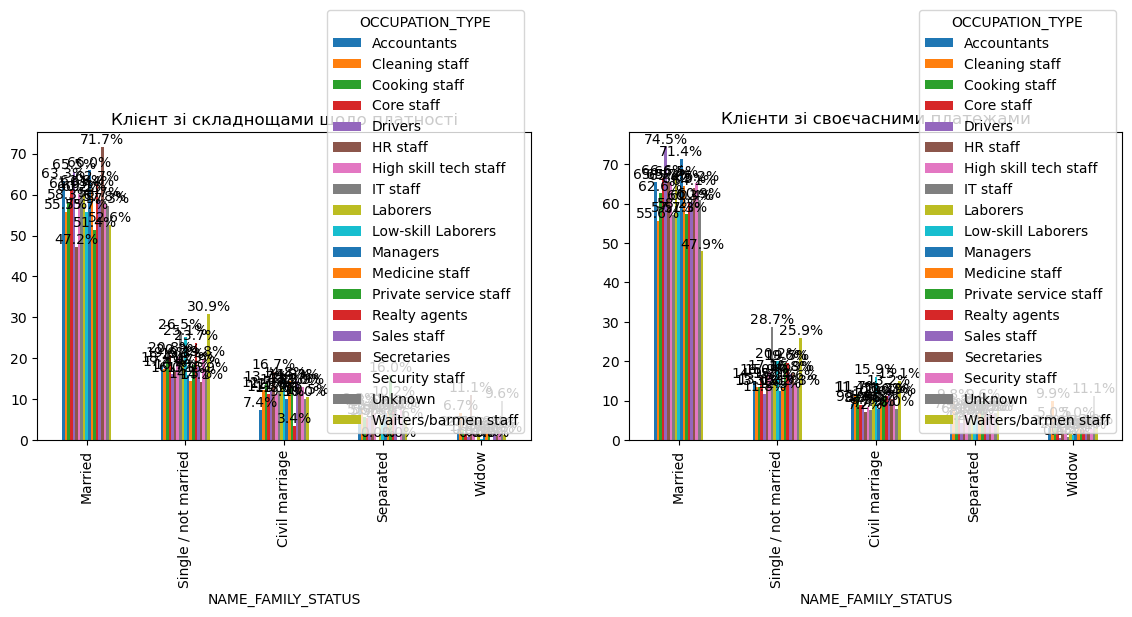

КІЛЬКІСТЬ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: NAME_FAMILY_STATUS


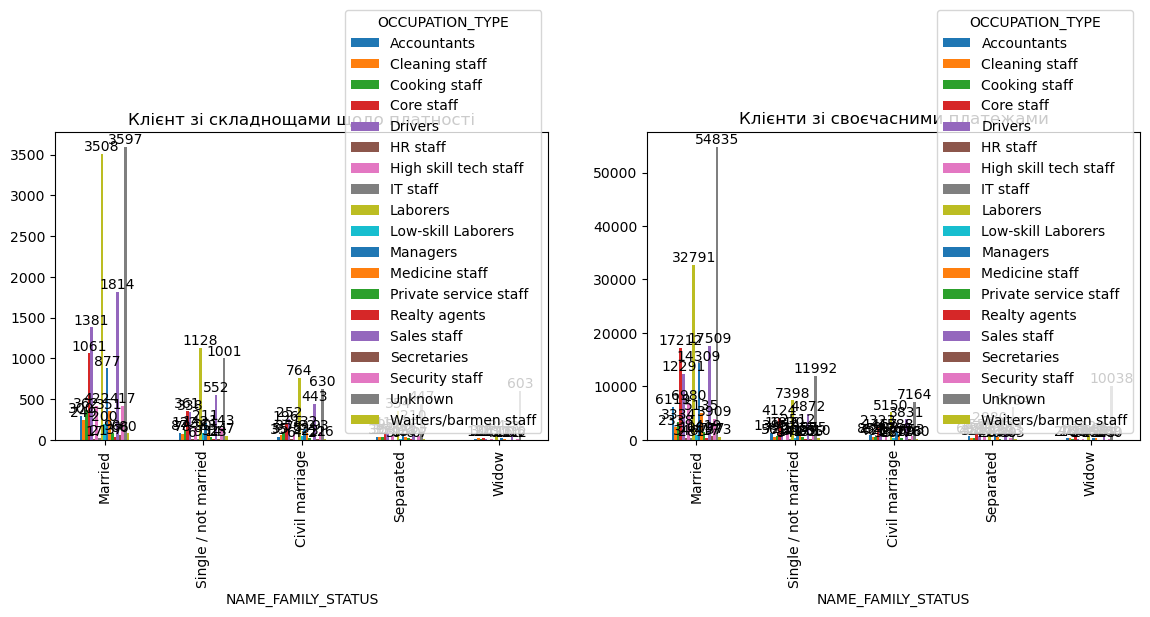

In [297]:
bi_countplot_target(df0, df1, 'NAME_FAMILY_STATUS','OCCUPATION_TYPE');

**Спостереження**
- найбілше клієнтів беруть кредити одружені з невизначиною сферою роботи 
- найбільший відсоток проблемних оплат в одружених секретарів, та працівників   

### Аналіз стовпців OCCUPATION_TYPE vs NAME_CONTRACT_TYPE

НОРМАЛІЗОВАНИЙ РОЗПОДІЛ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: OCCUPATION_TYPE


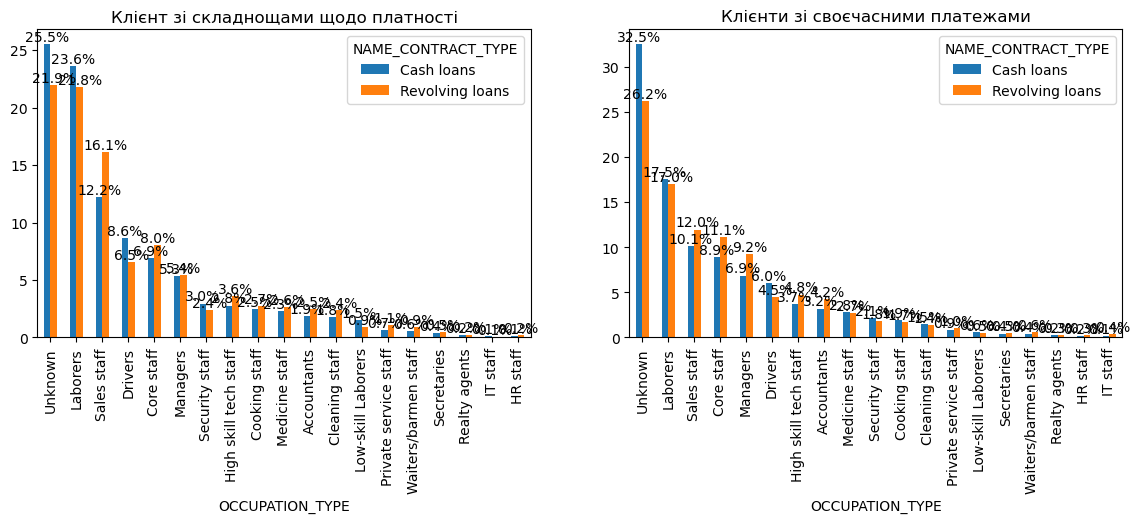

КІЛЬКІСТЬ ЗНАЧЕНЬ ЗА КАТЕГОРІЄЮ: OCCUPATION_TYPE


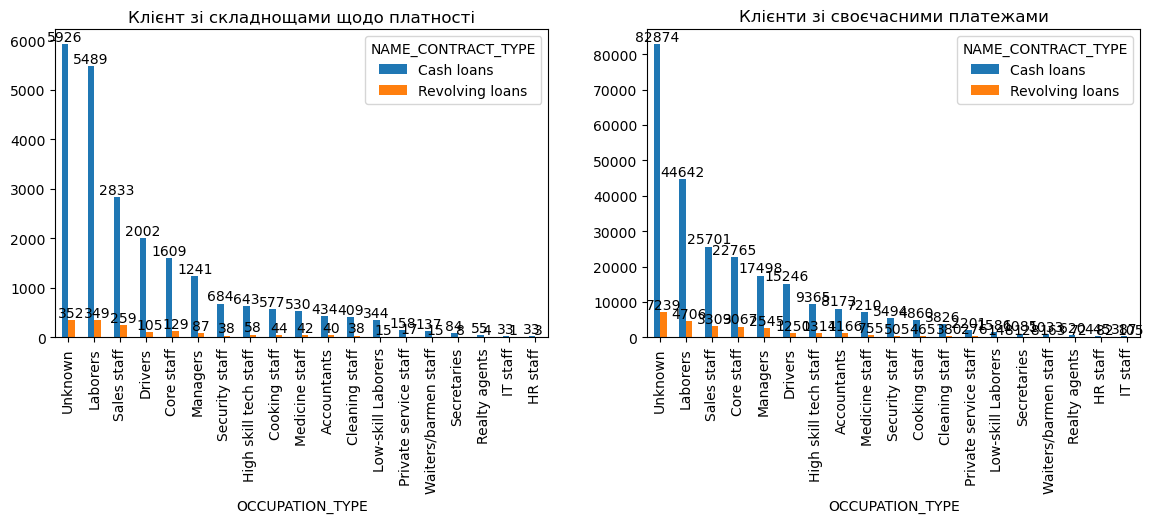

In [298]:
bi_countplot_target(df0, df1, 'OCCUPATION_TYPE','NAME_CONTRACT_TYPE');

**Спостереження**
- найбільше кредитів беруть по контракту готівки клієнти з невизначеною сферою діяльнності 

In [307]:
filename = "application_data.csv"
#"drive/MyDrive/Machine Learning для людей/data/credit/application_data_processed"
compression_options = dict(method='zip', archive_name=f'{filename}.csv')
df.to_csv(f'{filename}.zip', compression=compression_options, index=False)

***
# ДЗ 9. Висновок з проведеного аналізу
Напишіть Ваш висновок з проведеного ананлізу, яким категоріям осіб Ви б видали кредит? Категорія може бути, наприклад, люди з такою-то освітою, з таким-то доходом, з таким-то досвідом роботи.

# Висновок: Категорії клієнтів, на яких слід орієнтуватися при наданні кредиту


Так як головна задача нашого дослідження була виявити ознаки клієнтів, яким не варто надавати кредити, підсумуємо спостереження акцентуючи увагусаме на ці ознаки :

Перший показник це TARGET, який вказує чи були прострочені платежі у клієнтів і він становить 8% від загальної к-ті, порівняємо з клієнтами, які не мають проблем з оплатами і визначимо основні ознаки ,які можуть вказувати ,що клієнт буде проблемним 
- Маємо два типи кредитних контрактів, які не є показником за яким можемо робити висновки 
- По гендерній відмінності саме чоловіки мають більше випадків проблемних виплат 
- Найбільша к-ть  кредитів було видано для робочого класу людей і в цій категорії ми маємо найбільшу к-ть проблемних виплат 
- Проблеми з виплатами можуть залежати від рівня освіти клієнта і чим нижча освіта тим більше ймовірність невиконання платежів 
- Сума кредиту від 250000 до приблизно 650000 більше клієнтів мають труднощі з оплатою
- Більше клієнтів до 41 року, мають труднощі з оплатою
- Сума цінних речей, які має клієнт від 280000 до приблизно 630000 більше клієнтів мають труднощі з оплатою
- Стаж роботи до 6-7 років роботи більше клієнтів мають труднощі з оплатою
- Чим більша сума цінних речей або дохід від оренди зростає і сума кредиту
- Клієнти в віковій категорії 60-70 років, з типом житла ко-апартаментів, з доходом близько 150000 - 250000 мають проблеми з плптежпми по кредиту 
- Нетрудовлаштовані чоловіки з сумою речей до 600000 завжди мають проблеми з оплатою 
- Клієнти чоловіки HR-Staff з зарплатою більше 240000 мають проблеми з оплатою
- Нетрудовлаштовані чоловіки з доходом до 60000 - завжди мають проблеми з оплатою
- Жінки в декретній відпустці з доходом до 60000 - завжди мають проблеми з оплатою
- - найбільший відсоток проблемних оплат в одружених секретарів, та працівників 

Категорії клієнтів яким би НЕ видавали кредити:
Чоловік - робочий клас/непрацевлаштований - середня освіта - сума кредиту від 250000 - до 41 року - стаж роботи до 6-7 років  - дохід до 60000 
Жінка  - жінки в декретній відпустці - дохід до 60000 

Категорії клієнтів яким би видавали кредити:
Бізнесмен/студент/робочий клас - академічна ступінь освіти/вищий - дохід від 150000 - сума цінних речей від 600000

Це точні умови ,які можна брати до уваги, але необхідно провести більше досліджень , щоб описати остаточну вибірку 


